In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_259582/1256517549.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import numpy as np
from tqdm import tqdm as tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os
import optparse
import os.path as osp
import math
import torch_geometric
import torch
import sys
from torch_geometric.data import Data
import glob


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch.jit as jit

In [21]:
# tt=torch.load("/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/ntup_pho_18082024/data_499.pt")
# np.unique(tt[0].clus2d_feat[:,5])

### tensors features

In [22]:
#########################################
# clus2d_feats = np.stack((ak.to_numpy(sel_clusters[ts].position_x),
#                          ak.to_numpy(sel_clusters[ts].position_y),
#                          ak.to_numpy(sel_clusters[ts].position_z),
#                          ak.to_numpy(sel_clusters[ts].energy),
#                          ak.to_numpy(sel_clusters[ts].cluster_time),
#                          ak.to_numpy(sel_clusters[ts].cluster_layer_id))).T

#                     #print(clus2d_feats.shape)
# clus3d_feats = np.stack((sel_tseta[ts][0],
#                          sel_tsphi[ts][0],
#                          sel_tsen[ts][0],
#                          sel_tst[ts][0],
#                          min(ak.to_numpy(sel_clusters[ts].cluster_layer_id)),
#                          max(ak.to_numpy(sel_clusters[ts].cluster_layer_id)))).T
# gun_feats = np.stack((sel_cpeta[ts][0],
#                       sel_cpphi[ts][0],
#                       sel_cpen[ts][0],
#                       sel_cpent[ts][0], 
#                       sel_ratem[ts][0]    trk_em/ sim_em
#                       sel_rattot[ts][0]   trk/sim
#                        )).T
########################################

### Load input data

In [3]:
from torch.utils.data import Dataset

class ClassificationDataset(Dataset):
    def __init__(self, datapath, numLC, feats, signal, ispi, abz):
        self.datapath_ = datapath
        self.numLC_ = numLC
        self.signal_ = signal
        self.ispi_ = ispi
        self.abz_ = abz
        self.feats_ = feats
        self.process = self.load_datafiles(self.datapath_)
        self.data = torch.stack(self.process[0],dim=0)
        self.labels = torch.stack(self.process[1],dim=0)
        self.masks = torch.stack(self.process[2],dim=0)
        self.info3d = torch.stack(self.process[3],dim=0)
        self.infogun = torch.stack(self.process[4],dim=0)


    def load_datafiles(self, filepath) :
        "filepath of the form /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_DATA/ntup_pho_frac0p8/ "
        print("processing files from:",filepath)
        filelist = [filen for filen in glob.glob(filepath+'data*.pt')]
        output_tensor_list = []
        label = []
        mask_tensor_list = []
        info3d_tensor_list = []
        infogun_tensor_list = []
        
        ctot = 0
        cll = 0
        
        
        for i in tqdm(filelist):
            if (len(label)>50000):
                    break
            
            for filei in torch.load(i) :
                ctot += 1
                #print(filei.gun_feat)
                passpi = False
                passpu = False
                nlay = len(np.unique(filei.clus2d_feat[:,5]))
                ratrec_true = (filei.clus3d_feat[2]/filei.gun_feat[:,3]).item()

                if (self.signal_):
#                    if (nlay < 13) :
                    if (ratrec_true < 0.7):
                        cll += 1                        
                        continue
                else:
                    feat2da = filei.clus2d_feat
                    fracen26 = torch.sum(feat2da[feat2da[:,5] <=26][:,3])/torch.sum(feat2da[:,3])
                    if self.ispi_:
                        #if (nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15) :
                        passpi = True
                        if not(passpi):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay , fracen26)
                    else:
                        #if ((nlay < 10)and(fracen26 < 0.7))or ((nlay > 10)and(fracen26 < 0.7)) or ((nlay < 10)and(fracen26 > 0.7)):
                        #if not((nlay > 10)and(fracen26 > 0.7)and(min(feat2da[:,5]) < 15)):
                        if not((nlay > 10)and(fracen26 > 0.6)and(min(feat2da[:,5]) < 15)and((np.average(filei.clus2d_feat[:,2], weights=filei.clus2d_feat[:,3])) < 360)):
                            passpu = True
                        else:
                            pass
                            #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
                        if not(passpu):
                            cll += 1
                            continue
                        #print("self.ispi_ & nlay < 10 & fracen26< 0.7", self.ispi_, nlay, fracen26)
               
                
                
                
                
                
                optensor = self.transform_data(filei.clus2d_feat, self.numLC_)
                output_tensor_list.append(optensor[0])
                mask_tensor_list.append(optensor[1])
                info3d_tensor_list.append(filei.clus3d_feat[[0,1,2,4,5]])
                infogun_tensor_list.append(filei.gun_feat)
                if self.signal_:
                    label.append(torch.ones(1,dtype=torch.double))
                else:
                    label.append(torch.zeros(1,dtype=torch.double))
         
        
        print ("nskipped | ntotal:",cll," | ",ctot)
        return output_tensor_list, label, mask_tensor_list, info3d_tensor_list, infogun_tensor_list
                
    def transform_data(self, tensor, nLC) :            

        #feats = [0,1,2,5]
        target = torch.zeros(nLC, len(self.feats_))
        mask0 = torch.ones(nLC)
        source = tensor[:nLC,self.feats_]
        mask1 = torch.zeros(source.shape[0])
        if self.abz_:
            source[:,2] = np.abs(source[:,2])
        target[:source.shape[0], :] = source
        #source = source.T
        mask0[:source.shape[0]] = mask1
        mask0 
        #print(mask0)
        return target, mask0 > 0
    
        
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx): 
        return self.data[idx], self.labels[idx], self.masks[idx], self.info3d[idx], self.infogun[idx]

#### Photon dataset (energy spread: 10-1000 GeV)

In [4]:
pho_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/"
pho_dataset = ClassificationDataset(pho_path, 150, [0,1,5,3], True, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rmin_pho_30072024/


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:33<00:00, 14.94it/s]


nskipped | ntotal: 119  |  50000


#### Pion dataset: pion sample from where high energy early showering pions are removed

In [5]:
hizpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/"
hizpu_dataset = ClassificationDataset(hizpu_path, 150, [0,1,5,3], False, False, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2R0p9_pi_30072024/


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 484/500 [00:51<00:01,  9.44it/s]


nskipped | ntotal: 20625  |  70628


#### Pion dataset: low energy clusters within CEE + others (no CEE restrictions)

In [6]:
lowzpu_path = "/grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/"
lowzpu_dataset = ClassificationDataset(lowzpu_path, 150, [0,1,5,3], False, True, True)

processing files from: /grid_mnt/data__data.polcms/cms/sghosh/NEWPID_TICLDUMPER_DATA/S2Rno_PUenrich_05082024/


 17%|█████████████████████████████▌                                                                                                                                                   | 1/6 [00:41<03:26, 41.23s/it]


nskipped | ntotal: 0  |  95549


In [7]:
print("lenpho:",len(pho_dataset), " lenhizpu:",len(hizpu_dataset), " lenlozpu:",len(lowzpu_dataset))

lenpho: 49881  lenhizpu: 50003  lenlozpu: 95549


### Define training and testing datasets

In [8]:
nphos = len(pho_dataset)
idxstotsamp = np.arange(nphos)

### DEFINE Background COMPOSITION
hizpusel = torch.utils.data.Subset(hizpu_dataset, idxstotsamp[:int(0.3*nphos)])
lowzpusel = torch.utils.data.Subset(lowzpu_dataset, idxstotsamp[:int(0.7*nphos)])
#npusel = len(pho_dataset) - len(pisel)
#pusel = torch.utils.data.Subset(pu_dataset, idxstotsamp[:int(npusel)])

combdataset = torch.utils.data.ConcatDataset([pho_dataset, hizpusel, lowzpusel])

nsamp = len(combdataset)

idxs = np.arange(nsamp)
np.random.shuffle(idxs)
tridx = idxs[:int(0.8*nsamp)]
tsidx = idxs[int(0.8*nsamp):nsamp]
trdata = torch.utils.data.Subset(combdataset, tridx)
tsdata = torch.utils.data.Subset(combdataset, tsidx)

ntrainbatch = 600
## load train and test dataset
trainloader = torch.utils.data.DataLoader(trdata, batch_size=ntrainbatch ,shuffle=True)#, num_workers=2)
testloader = torch.utils.data.DataLoader(tsdata, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)
## load all data, for plots later
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=ntrainbatch,shuffle=True)#, num_workers=2)


print("total samples > npho | nhizpu | nlozpu | nTOT:",len(pho_dataset)," | ",len(hizpusel)," | ",len(lowzpusel)," | ",nsamp)
print("N_train, N_test:",len(trdata),",",len(tsdata))

total samples > npho | nhizpu | nlozpu | nTOT: 49881  |  14964  |  34916  |  99761
N_train, N_test: 79808 , 19953


### Define model

In [9]:
## Define model
## refer https://github.com/ludovicobuizza/HAR-Transformer/blob/main/src/transformer/transformer.py for batchnorm
import torch.nn as nn
import torch.nn.functional as F

class MHA_model(jit.ScriptModule):
    

    def __init__(
        self,
        input_dim = 6,
        dim_emb = 64,
        n_heads = 16,
        num_enclayers = 6,
        dim_feedforward = 64,
        n_seq = 150,
        output_dim = 2,
        norm=torch.tensor([1./100., 1./100., 1./100., 1./100.]),
    ):
        
        super(MHA_model, self).__init__()
        self.datanorm = nn.Parameter(norm, requires_grad=False) 
        self.emb_inp = nn.Sequential(
            nn.Linear(input_dim, dim_emb),
            nn.Dropout(0.2),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
            nn.Linear(dim_emb, dim_emb),
            nn.Dropout(0.2),
#            nn.LeakyReLU(negative_slope=0.4),
#            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ELU(),
            #nn.LeakyReLU(negative_slope=0.4),
        )
        
#        self.emb_inp =  nn.Linear(input_dim, dim_emb)      
        encoder_layer = nn.TransformerEncoderLayer(
                dim_emb,
                n_heads,
                dim_feedforward,
                dropout = 0.2,
                batch_first= True,
                activation=nn.ELU(),  #nn.LeakyReLU(negative_slope=0.4),
            )
        
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_enclayers)
        
        self.output_layer = nn.Sequential(nn.Linear(n_seq*dim_emb + 5, dim_emb//2),
                                    
                                    #nn.LeakyReLU(negative_slope=0.4),
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    nn.Linear(dim_emb//2, dim_emb//2),#added
                                    nn.Dropout(0.2),
                                    nn.ELU(),
                                    #nn.Softplus(),
                                    nn.Linear(dim_emb//2, output_dim)
                                   )
    
    
    @jit.script_method
    def forward(self, X, mask, info3d) :
        
        
        #project input to dim_emb dimensional space
        X = self.datanorm*X
        inp = self.emb_inp(X) #* math.sqrt(self.dim_embed)
        
        output = self.transformer_encoder(inp, src_key_padding_mask=mask)  # (batch, seq, feat)
        output = output.reshape(output.shape[0], -1)  # (batch, seq * feat)
        output = torch.concat((output,info3d), dim = -1)
        output = self.output_layer(output)  # (batch, num_classes)

        return F.log_softmax(output, dim=-1)

### define training and testing functions

In [10]:
### define training and testing functions
#from lr_modulation import *
device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#model = NetCNN().to(float) ### change to NetDNN().to(float) for DNN
#model = model.to(device)


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model = model.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
#scheduler = CyclicLRWithRestarts(optimizer, ntrainbatch, epoch_size, restart_period=10, t_mult=1.2, policy="cosine")
#scheduler = CyclicLRWithRestarts(optimizer, 200, 200, restart_period=30, t_mult=1.2, policy="cosine")
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,50)
#lossfunction = nn.BCELoss()



def train(epoch):
    model.train()
    torch.cuda.empty_cache()
    loss = []
    true_preds, num_preds = 0., 0.
    iters = len(trainloader)
    cc = 0
    for data in tqdm(trainloader):  ### change to loaderDNN for DNN
            #datax, label = data[0].to(device), data[1].to(device)
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
            label = label.to(torch.long).squeeze()
            optimizer.zero_grad()
            result = model(datax, masks, info3d)
            #print(result)
            
            #print(label)
            #print(result.dtype)
            #lossc = lossfunction(result, label)
            lossc = F.nll_loss(result, label)
            
            loss.append(lossc.item()) 
            lossc.backward()
            optimizer.step()
            scheduler.step(epoch + cc / iters)
            cc += 1
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    print('train acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)


def test(epoch):
    model.eval()
    loss = []
    true_preds, num_preds = 0., 0.
    for data in tqdm(testloader): ### change to loaderDNN for DNN
            datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)            
            label = label.to(torch.long).squeeze()
            result = model(datax, masks, info3d)
            lossc = F.nll_loss(result, label)
            loss.append(lossc.item())
            
            pred_labels = torch.argmax(result.cpu(), dim=-1) 
            true_preds += (pred_labels == label.cpu()).sum()
            num_preds += label.shape[0]
            
            
    acc = true_preds / num_preds
    #print( 'batches for train:',len(loss)) 
    print('test loss:',np.mean(np.array(loss)))
    print('test acc:',np.mean(np.array(acc)))
    return np.mean(np.array(loss)), np.array(acc)

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


### Define output, training parameters, and launch training

epoch: 0
Learning rate: 0.001


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:33<00:00,  3.95it/s]


train loss: 0.31573110646498737
train acc: 0.8930057


  0%|                                                                                                                                                                                        | 0/34 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.52it/s]


test loss: 0.12746418311315424
test acc: 0.954894
new best acc: 0.954894
epoch: 1
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.1288757528275696
train acc: 0.9650787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.08208118707818143
test acc: 0.97729665
new best acc: 0.97729665
epoch: 2
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.07746844792585653
train acc: 0.97705746


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.06941171921789646
test acc: 0.97890043
new best acc: 0.97890043
epoch: 3
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.05630621894387834
train acc: 0.98289645


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.23it/s]


test loss: 0.0837327447884223
test acc: 0.97318697
epoch: 4
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.04816116437788552
train acc: 0.9858034


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.06471986898823696
test acc: 0.98010325
new best acc: 0.98010325
epoch: 5
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.03635277767985392
train acc: 0.98939955


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.05714163581347641
test acc: 0.9838621
new best acc: 0.9838621
epoch: 6
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.0358537086216149
train acc: 0.98973787


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.1217434980413493
test acc: 0.9664712
epoch: 7
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.040063301768543114
train acc: 0.98768294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


test loss: 0.0506465873297523
test acc: 0.9869193
new best acc: 0.9869193
epoch: 8
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.031561086237527874
train acc: 0.99031425


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.0611037917654304
test acc: 0.98551595
epoch: 9
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.03128187938023414
train acc: 0.99090314


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.04327310550519649
test acc: 0.9888237
new best acc: 0.9888237


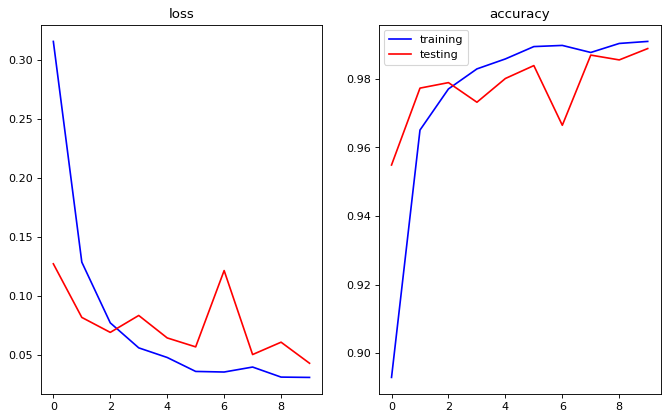

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.25it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


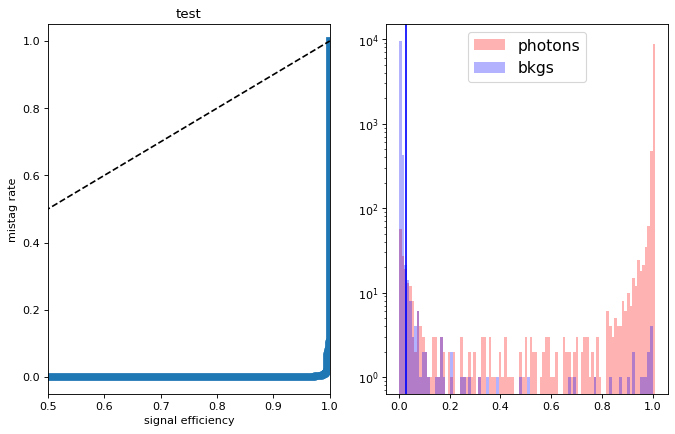

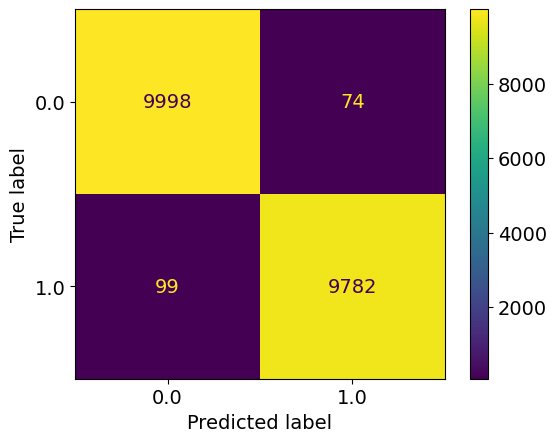

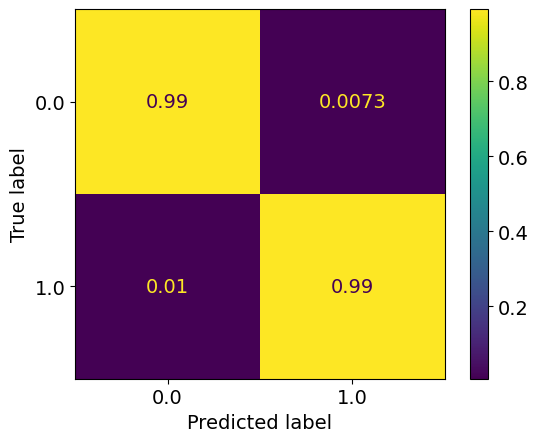

epoch: 10
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.027180730229688446
train acc: 0.9918304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.06178382126724019
test acc: 0.98466396
epoch: 11
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.026205142335848947
train acc: 0.9925822


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.58it/s]


test loss: 0.03369690779158298
test acc: 0.9895755
new best acc: 0.9895755
epoch: 12
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.025781397493608266
train acc: 0.9921061


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.028784880085903054
test acc: 0.9915301
new best acc: 0.9915301
epoch: 13
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.023177695938441625
train acc: 0.99297065


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.0749760004965698
test acc: 0.9826592
epoch: 14
Learning rate: 0.0008188926045137138


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0244135096540619
train acc: 0.99239427


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.031700245289625055
test acc: 0.9907783
epoch: 15
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.023016468709536286
train acc: 0.9928954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.058866141254411024
test acc: 0.98521525
epoch: 16
Learning rate: 0.0007681113183592135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.02318762655634044
train acc: 0.992695


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.02074354994864039
test acc: 0.99333435
new best acc: 0.99333435
epoch: 17
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.026178582274327195
train acc: 0.9917928


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.01950822220704354
test acc: 0.99363506
new best acc: 0.99363506
epoch: 18
Learning rate: 0.0007131017565522499


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.021085767955918894
train acc: 0.99372244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.042251765015808976
test acc: 0.98967576
epoch: 19
Learning rate: 0.0006842802396059903


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.02182101311825421
train acc: 0.99325883


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.04640579122283003
test acc: 0.9889741


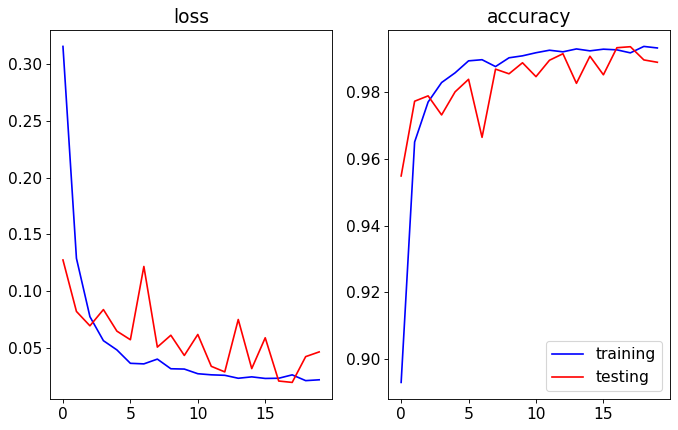

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


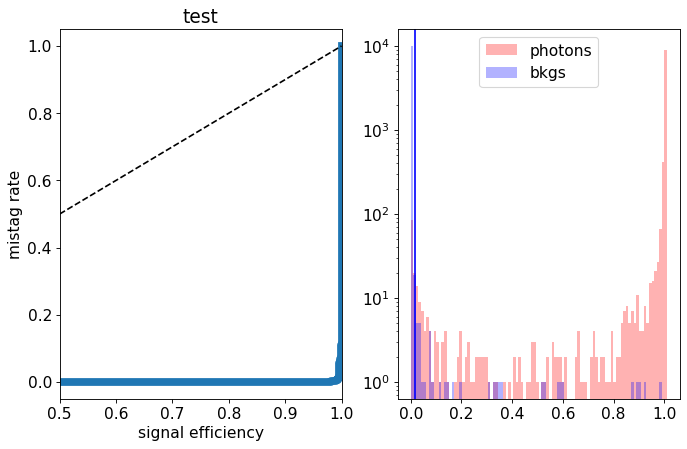

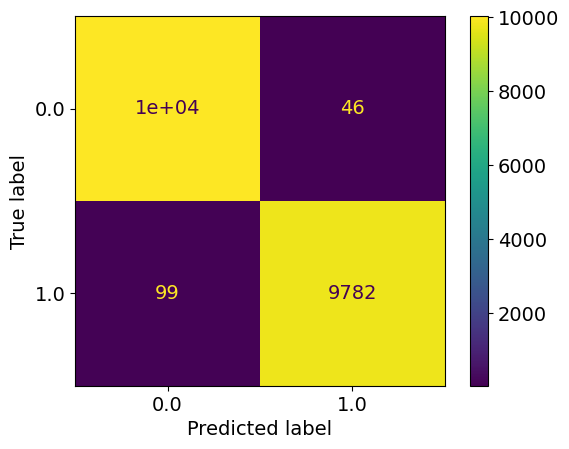

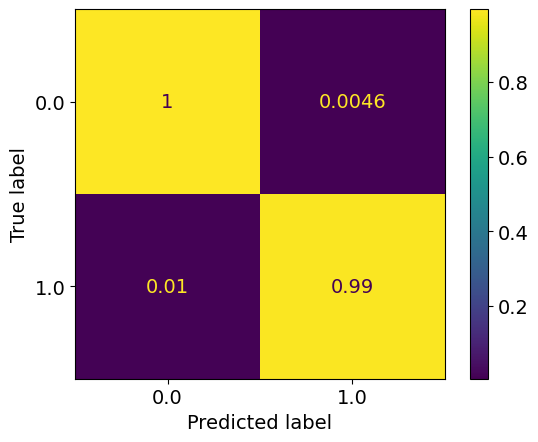

epoch: 20
Learning rate: 0.0006547314527436388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.022141975593933865
train acc: 0.9937851


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.029768978498930877
test acc: 0.992332
epoch: 21
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.0227161673572129
train acc: 0.9929957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.015653924126287595
test acc: 0.9951887
new best acc: 0.9951887
epoch: 22
Learning rate: 0.0005939209414931709


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.018801936459268875
train acc: 0.9944241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.02580886328017668
test acc: 0.99278307
epoch: 23
Learning rate: 0.0005628992084112799


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.019819793489469745
train acc: 0.9939229


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.029822990531101823
test acc: 0.9923821
epoch: 24
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.018944306559721704
train acc: 0.99422365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.016185424304293358
test acc: 0.99503833
epoch: 25
Learning rate: 0.0005002344472043634


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.02025680013657756
train acc: 0.9937099


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.02374697015586528
test acc: 0.9936852
epoch: 26
Learning rate: 0.0004688387282630152


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.016731293887636667
train acc: 0.9947624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.57it/s]


test loss: 0.026739121674943495
test acc: 0.9939859
epoch: 27
Learning rate: 0.0004375659886249822


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.018108309879065004
train acc: 0.9942988


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.02065797892625115
test acc: 0.9945372
epoch: 28
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.016665469987992086
train acc: 0.99451184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]


test loss: 0.029821695937939426
test acc: 0.99213153
epoch: 29
Learning rate: 0.0003758821517012554


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01819128382242104
train acc: 0.994374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.02427480069694438
test acc: 0.9933845


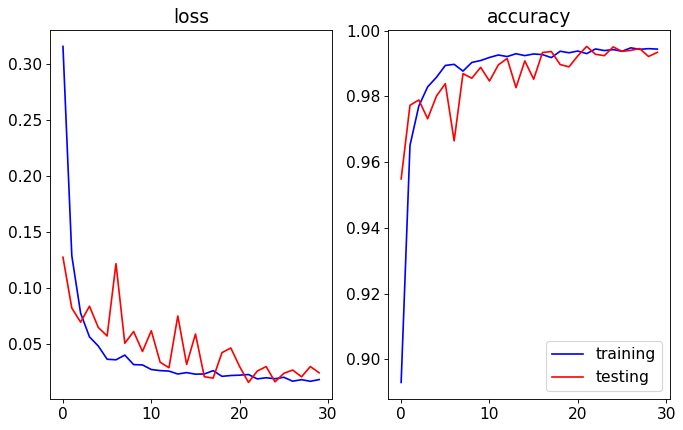

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.91it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


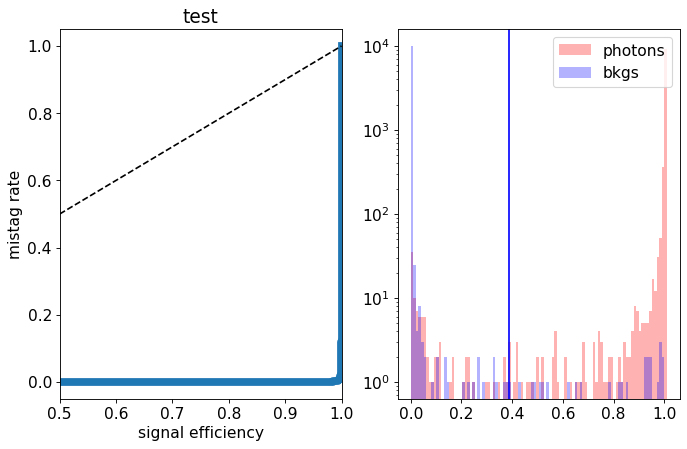

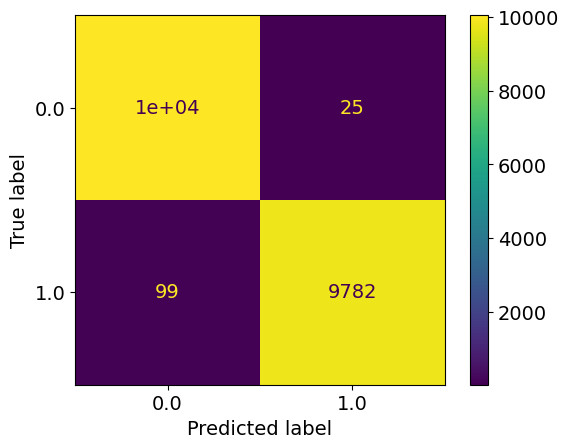

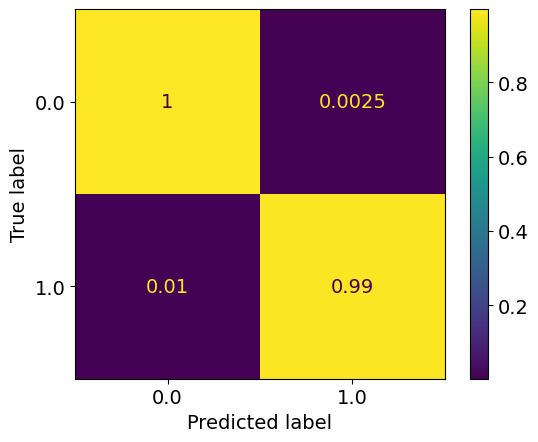

epoch: 30
Learning rate: 0.00034571449233923525


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.016607104168176207
train acc: 0.99463713


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.08it/s]


test loss: 0.030338164963348603
test acc: 0.9926828
epoch: 31
Learning rate: 0.0003161557273896085


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.017543297177326167
train acc: 0.9944366


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.030660019886186895
test acc: 0.9917807
epoch: 32
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.017783560889161457
train acc: 0.994374


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.035558377960970736
test acc: 0.99112916
epoch: 33
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.016601594137166862
train acc: 0.99495035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.027946689179824555
test acc: 0.9926828
epoch: 34
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.016943118785351163
train acc: 0.99464965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.020990744748012408
test acc: 0.9942866
epoch: 35
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.016142732316085984
train acc: 0.9950757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.020974927746197757
test acc: 0.9943868
epoch: 36
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01565691346212276
train acc: 0.99512583


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.023281180909286964
test acc: 0.9940861
epoch: 37
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.01564977488675113
train acc: 0.9951759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.028424804958323127
test acc: 0.99258256
epoch: 38
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.015702607498863458
train acc: 0.9948752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.021674573166819755
test acc: 0.9937854
epoch: 39
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.58it/s]


train loss: 0.0154671583024076
train acc: 0.9949003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.02it/s]


test loss: 0.023749389110461754
test acc: 0.99423647


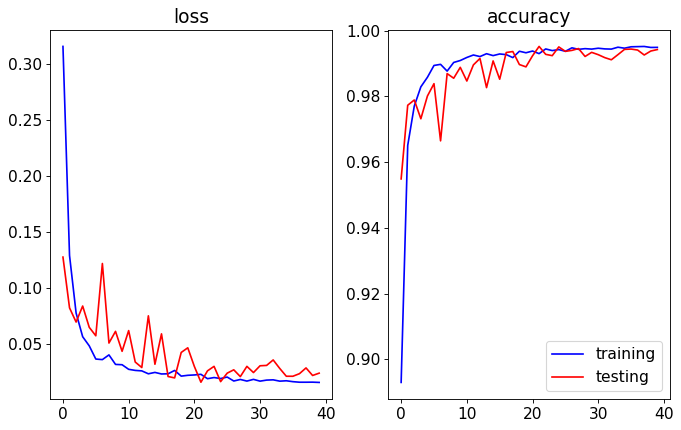

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


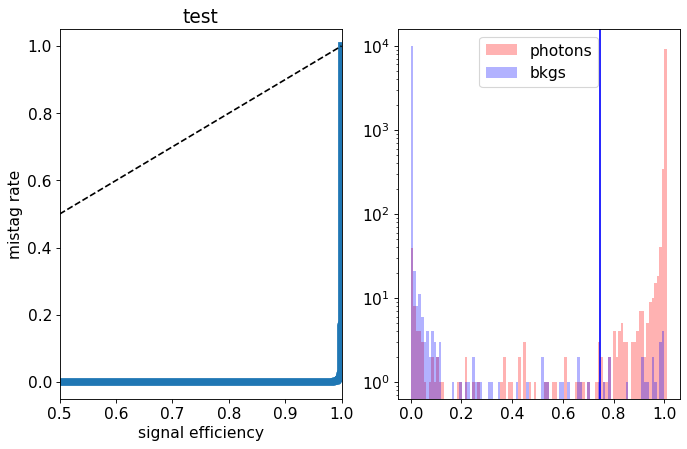

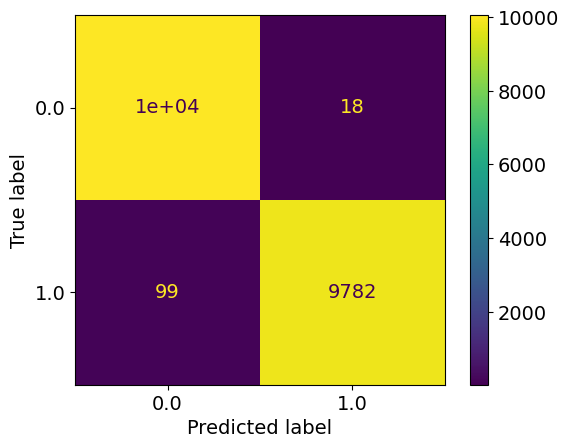

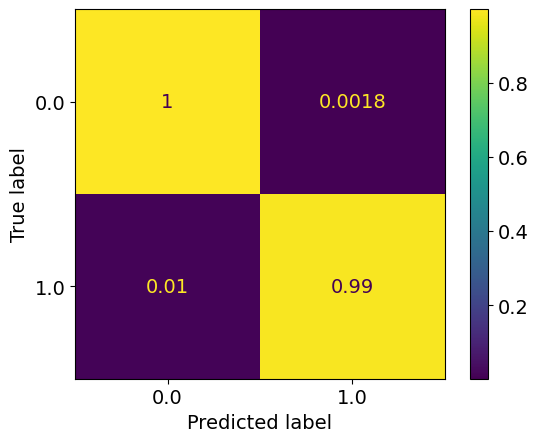

epoch: 40
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.015115476893860526
train acc: 0.99510074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.024772003354669055
test acc: 0.9934847
epoch: 41
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.015582234456217777
train acc: 0.9953263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.01785872696671183
test acc: 0.99523884
new best acc: 0.99523884
epoch: 42
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.014850257767817827
train acc: 0.99495035


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.02399467776173397
test acc: 0.99418634
epoch: 43
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014920538974189157
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.07it/s]


test loss: 0.023636345710495815
test acc: 0.99388564
epoch: 44
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.013494595920027637
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.021913733697575107
test acc: 0.9949882
epoch: 45
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.014511410686892889
train acc: 0.9952511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.64it/s]


test loss: 0.021115418095552528
test acc: 0.9948379
epoch: 46
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.014202492657367751
train acc: 0.99530125


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.02198456711930168
test acc: 0.99478775
epoch: 47
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014477334444889684
train acc: 0.99556434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.02291994944543523
test acc: 0.9940861
epoch: 48
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.013888018298123132
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.024785535697660902
test acc: 0.99418634
epoch: 49
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014749473589819982
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.023477824158309138
test acc: 0.99418634


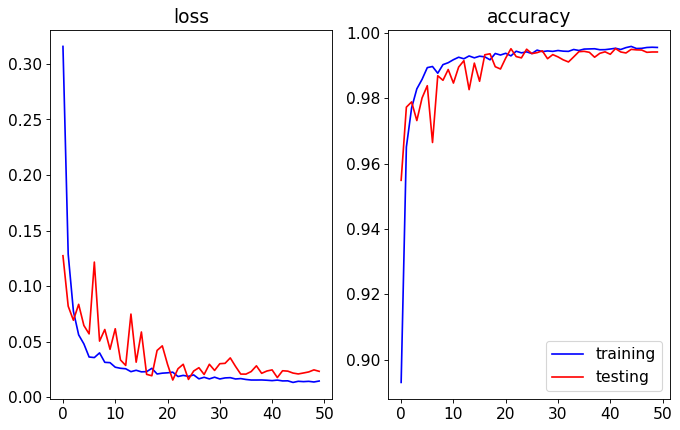

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


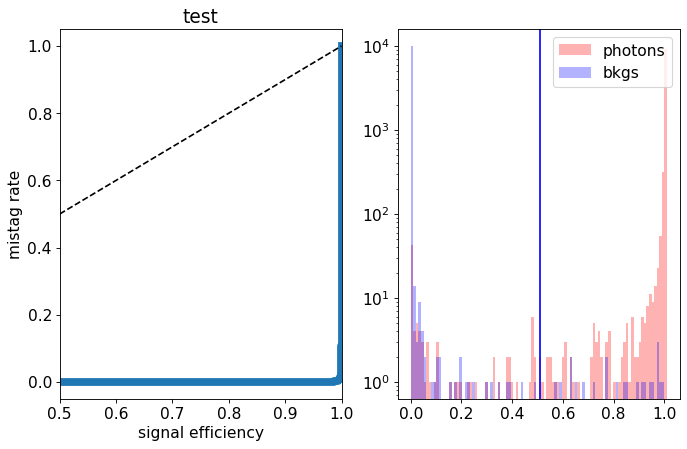

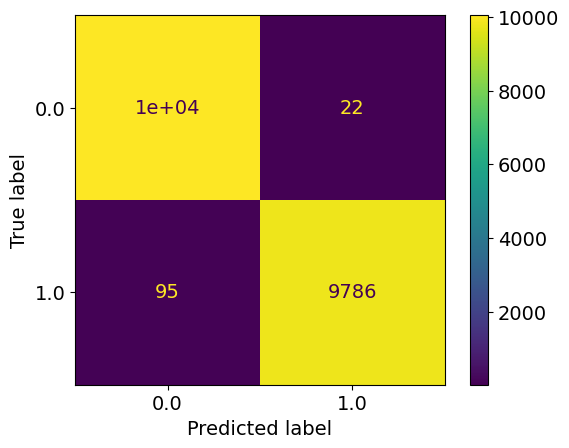

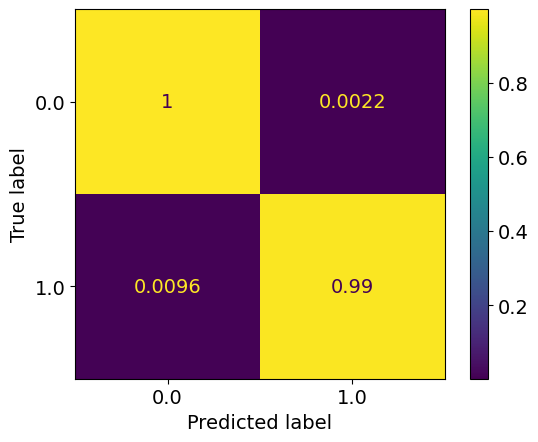

epoch: 50
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.027127900737713078
train acc: 0.9917051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.020983576035017475
test acc: 0.9935348
epoch: 51
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.021060169877802844
train acc: 0.993334


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.02331673149156439
test acc: 0.99333435
epoch: 52
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.019761050493567626
train acc: 0.99377257


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.37it/s]


test loss: 0.029174298993037903
test acc: 0.99253243
epoch: 53
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.017596760215654747
train acc: 0.9947123


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.56it/s]


test loss: 0.02406798429129755
test acc: 0.9923821
epoch: 54
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.0192264963511322
train acc: 0.9938101


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.60it/s]


test loss: 0.03283109305673005
test acc: 0.9904275
epoch: 55
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.019516623770095297
train acc: 0.9936473


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.57it/s]


test loss: 0.04500344298535578
test acc: 0.99002653
epoch: 56
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.018840309905988135
train acc: 0.9939104


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.57it/s]


test loss: 0.01927234375890454
test acc: 0.9951386
epoch: 57
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.01822523067863558
train acc: 0.993948


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.60it/s]


test loss: 0.012743465869468363
test acc: 0.99508846
epoch: 58
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.01698684252871534
train acc: 0.99431133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.74it/s]


test loss: 0.016022148877656198
test acc: 0.9946875
epoch: 59
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.019136881888427063
train acc: 0.99376005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.59it/s]


test loss: 0.033655524282949045
test acc: 0.9894251


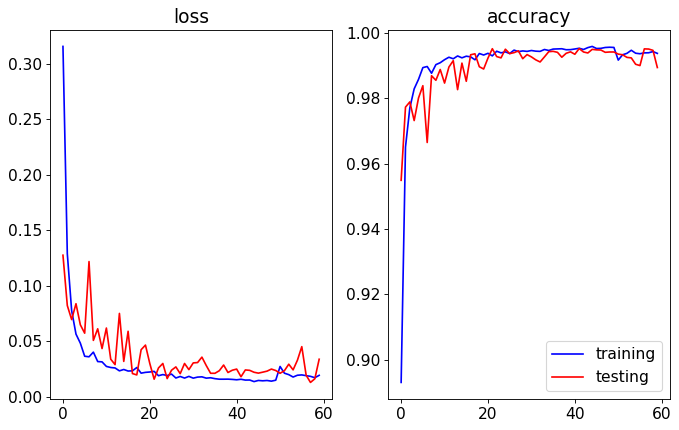

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.56it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


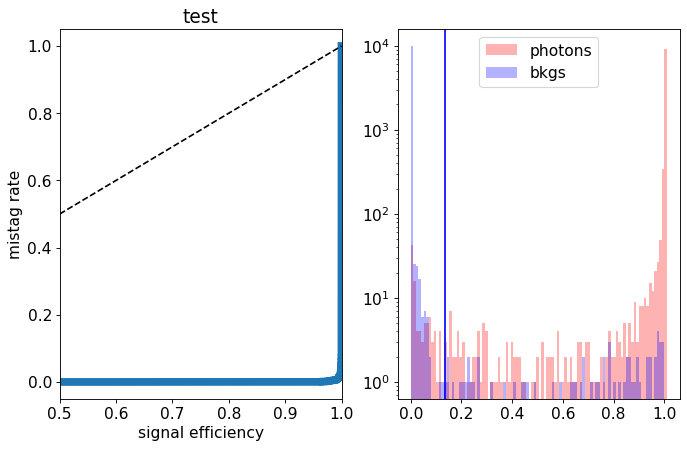

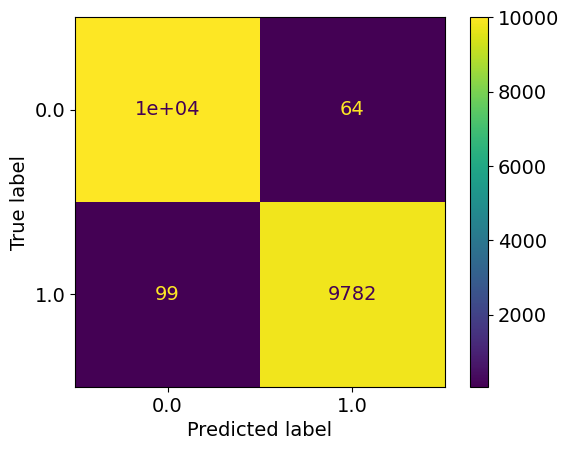

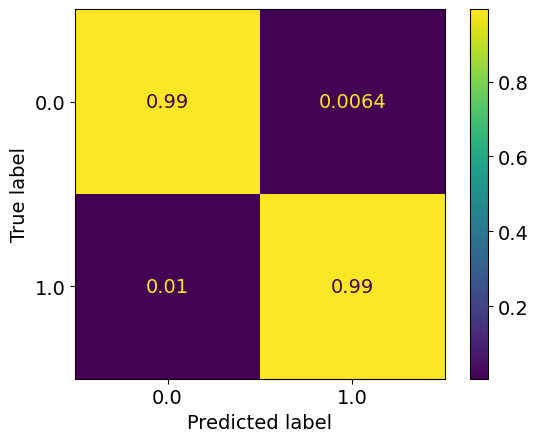

epoch: 60
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.016584168881987597
train acc: 0.9946246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.60it/s]


test loss: 0.01312240500770071
test acc: 0.99563974
new best acc: 0.99563974
epoch: 61
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.0167366561489423
train acc: 0.9942863


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.020350396838586998
test acc: 0.99448705
epoch: 62
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.016671336712941194
train acc: 0.99466217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01573176114984295
test acc: 0.99508846
epoch: 63
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.016653143175279918
train acc: 0.9945995


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.021523311649456017
test acc: 0.9936852
epoch: 64
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01635522927581541
train acc: 0.99466217


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.03it/s]


test loss: 0.012786933835527366
test acc: 0.99624115
new best acc: 0.99624115
epoch: 65
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.015085927602563942
train acc: 0.99482507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.27it/s]


test loss: 0.018709779735860032
test acc: 0.9946875
epoch: 66
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.016467527832154796
train acc: 0.994587


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.019037345537285814
test acc: 0.99433666
epoch: 67
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.014882595812616898
train acc: 0.9950256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.019747217829503557
test acc: 0.9949882
epoch: 68
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.016140947920548706
train acc: 0.99467474


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.024043260121663267
test acc: 0.99283314
epoch: 69
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.015289355878224735
train acc: 0.9949003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.019445611095494208
test acc: 0.99463737


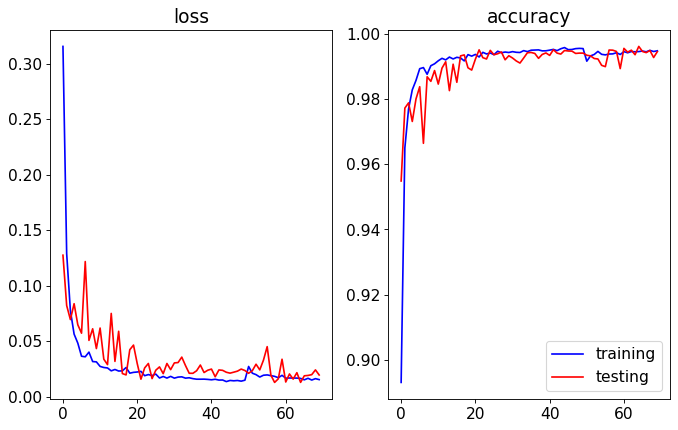

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


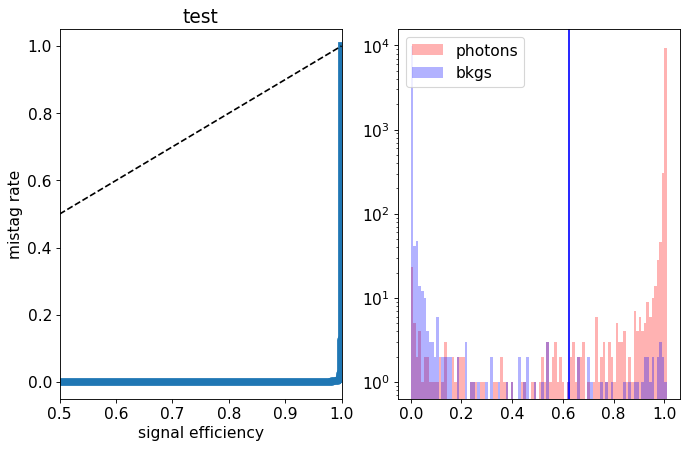

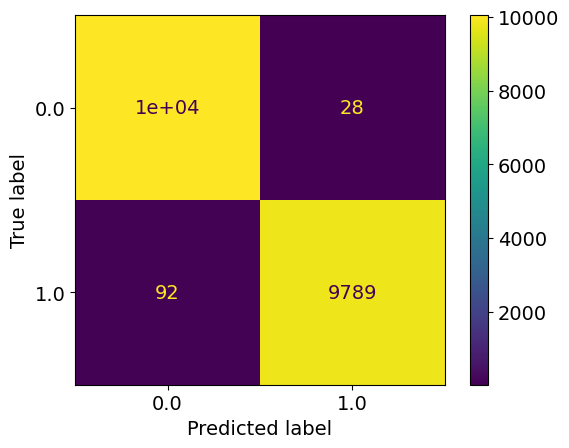

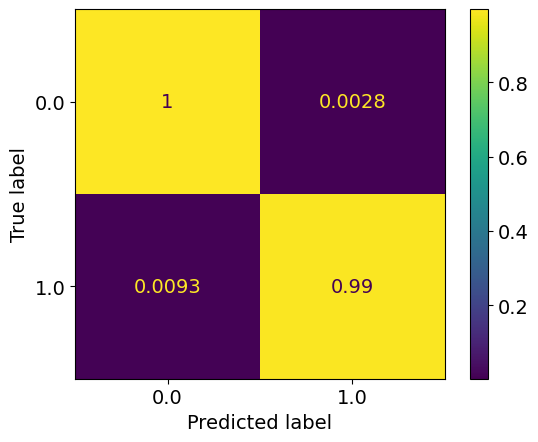

epoch: 70
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.53it/s]


train loss: 0.01451888803823559
train acc: 0.9951885


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.53it/s]


test loss: 0.01232401461696581
test acc: 0.99568987
epoch: 71
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.015324609075984012
train acc: 0.99510074


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.015016966365852995
test acc: 0.99563974
epoch: 72
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.014720031319715172
train acc: 0.99497545


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.017322473256653585
test acc: 0.99508846
epoch: 73
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.015305832519244625
train acc: 0.99480003


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.013976202678938588
test acc: 0.9959906
epoch: 74
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01493002496125027
train acc: 0.9950256


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.023314723724444562
test acc: 0.9933845
epoch: 75
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.01363692373777314
train acc: 0.9951634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.08it/s]


test loss: 0.016122621012661566
test acc: 0.9951887
epoch: 76
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013718308144184415
train acc: 0.9952135


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.02209173346636817
test acc: 0.9946875
epoch: 77
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013247118571272759
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02019740609188482
test acc: 0.9945372
epoch: 78
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.013896162264208175
train acc: 0.99527615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.015809477967730558
test acc: 0.9957901
epoch: 79
Learning rate: 0.0003758821517012555


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012844243947175026
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.02569604369209093
test acc: 0.9933845


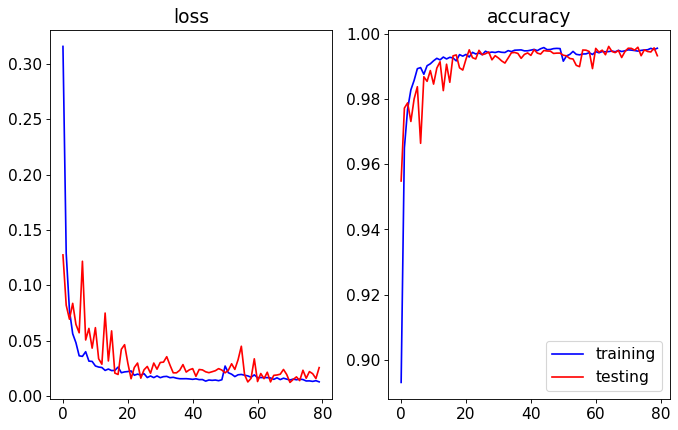

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


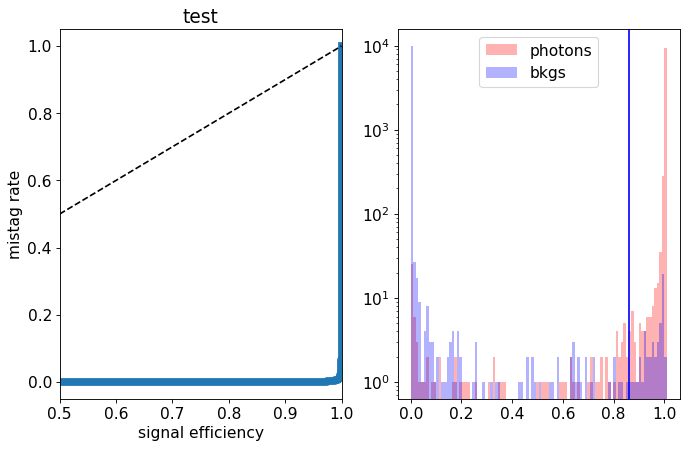

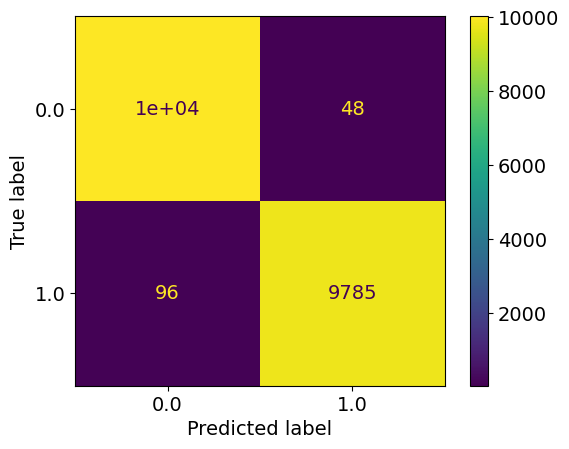

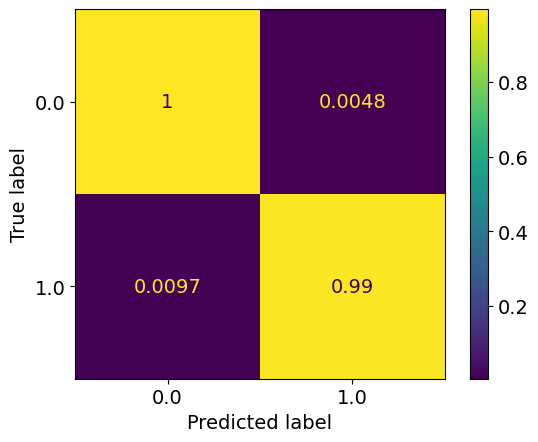

epoch: 80
Learning rate: 0.00034571449233923536


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.013134990552737405
train acc: 0.99558944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.013148482135661384
test acc: 0.9955896
epoch: 81
Learning rate: 0.00031615572738960855


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012963848055814698
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.11it/s]


test loss: 0.01790529877454152
test acc: 0.9949381
epoch: 82
Learning rate: 0.00028732251179351616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.013281505398780025
train acc: 0.9956521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.46it/s]


test loss: 0.01692215637612047
test acc: 0.99523884
epoch: 83
Learning rate: 0.00025932863708027284


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.01316176912242459
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.42it/s]


test loss: 0.014211687555550323
test acc: 0.99574
epoch: 84
Learning rate: 0.00023228458228418658


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.012353755284357927
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.80it/s]


test loss: 0.015360047685349213
test acc: 0.99553955
epoch: 85
Learning rate: 0.00020629707793428436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.012277912241921485
train acc: 0.9956771


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.022896949448348844
test acc: 0.99403596
epoch: 86
Learning rate: 0.00018146868483767388


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.012553804814160685
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.017419336391921045
test acc: 0.9951887
epoch: 87
Learning rate: 0.00015789738931889374


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.012035530401956734
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.66it/s]


test loss: 0.014711128617979257
test acc: 0.99553955
epoch: 88
Learning rate: 0.00013567621651265567


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.011753453491273016
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.11it/s]


test loss: 0.014768941933973967
test acc: 0.99563974
epoch: 89
Learning rate: 0.00011489286323613779


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01290176414726945
train acc: 0.99576485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.016096766515949962
test acc: 0.9955896


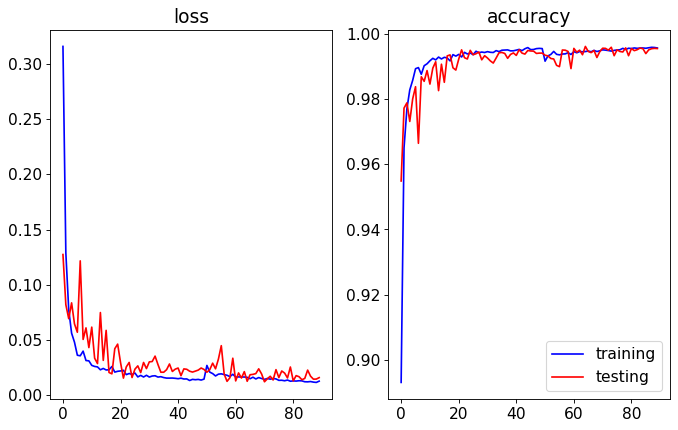

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


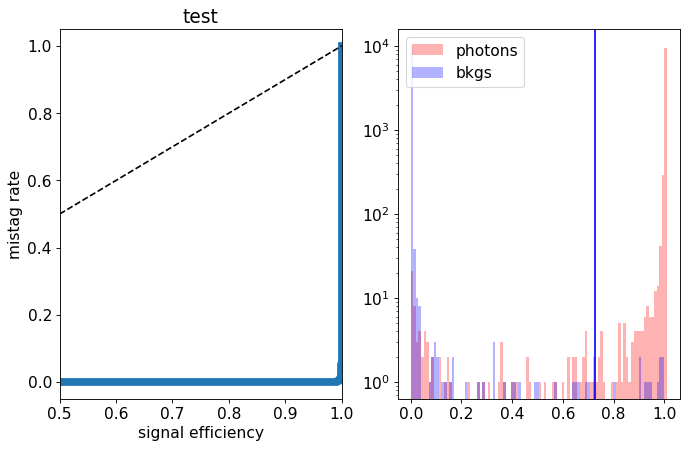

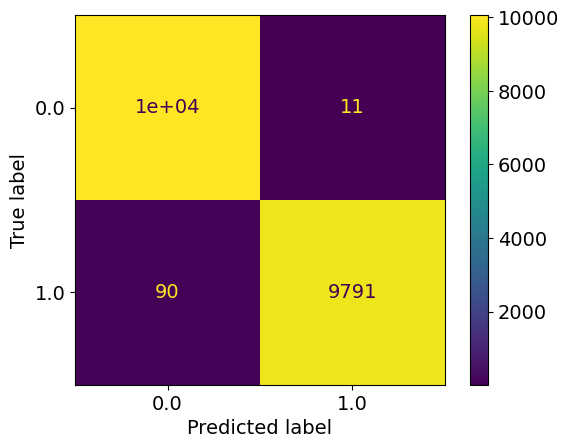

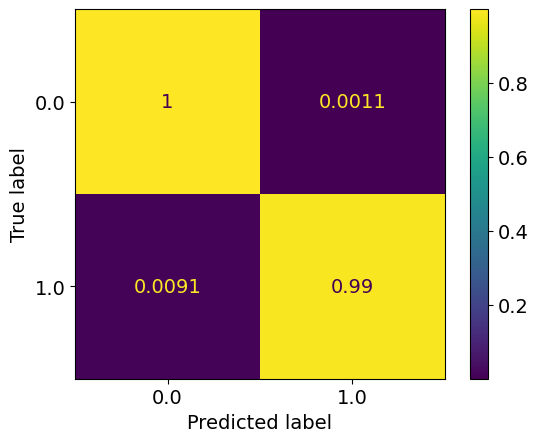

epoch: 90
Learning rate: 9.562935188971167e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.011441347515036756
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.014024401851416127
test acc: 0.99563974
epoch: 91
Learning rate: 7.796170675200053e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01191710131278776
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.013906153516419342
test acc: 0.99553955
epoch: 92
Learning rate: 6.195965394678333e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.01146618536336403
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.29it/s]


test loss: 0.014928619301987483
test acc: 0.9954393
epoch: 93
Learning rate: 4.768634626584012e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011398052881861022
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.016986568228115655
test acc: 0.99503833
epoch: 94
Learning rate: 3.519811393373329e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011807002818956667
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.015626406054841082
test acc: 0.9954393
epoch: 95
Learning rate: 2.4544242298147113e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.0113056136330819
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01360809917369967
test acc: 0.99563974
epoch: 96
Learning rate: 1.5766777323136307e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011436353848531231
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.015022814025595674
test acc: 0.9954393
epoch: 97
Learning rate: 8.900359652914913e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.01084712684005082
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.44it/s]


test loss: 0.015879525818437448
test acc: 0.9952889
epoch: 98
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011008433475499667
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.015643995203872156
test acc: 0.99533904
epoch: 99
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01115464822563089
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.016411540892851705
test acc: 0.99533904


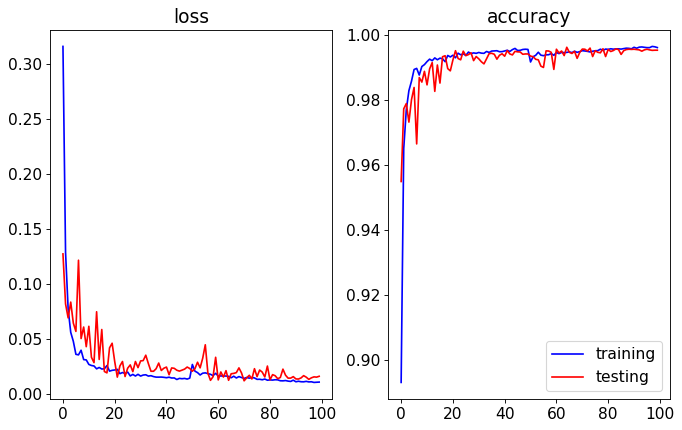

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


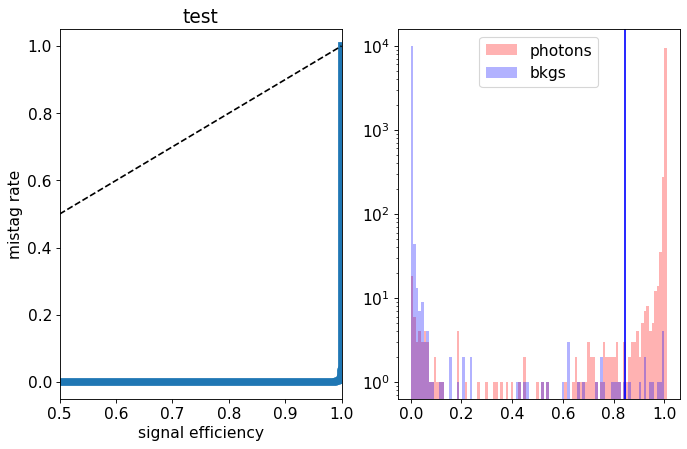

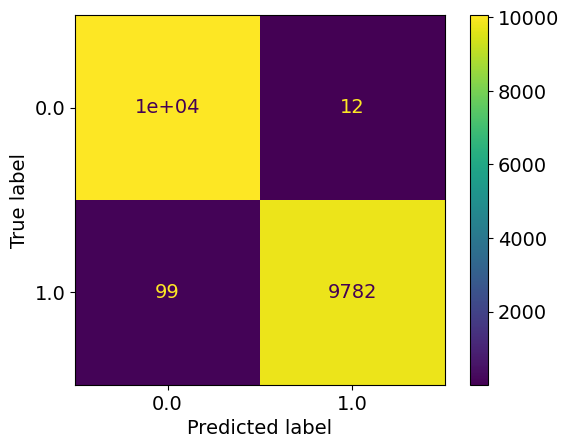

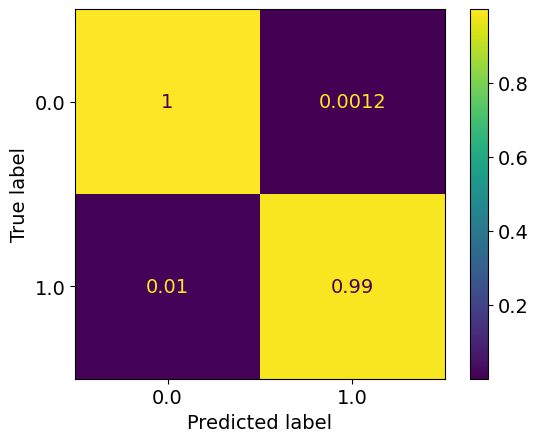

epoch: 100
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.017449675066364394
train acc: 0.9941735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.02436514458317748
test acc: 0.9942866
epoch: 101
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.017151191349335904
train acc: 0.99403566


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.02458642753224601
test acc: 0.9924823
epoch: 102
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.017613633224782325
train acc: 0.993973


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.83it/s]


test loss: 0.033699172603733396
test acc: 0.9913296
epoch: 103
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.017680611918374563
train acc: 0.9946246


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.0319951571907629
test acc: 0.9922317
epoch: 104
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01942333509496573
train acc: 0.9938477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.015803587136735374
test acc: 0.9951386
epoch: 105
Learning rate: 0.0009756006540427169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01599040603501472
train acc: 0.9947624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.07it/s]


test loss: 0.02177907367962796
test acc: 0.994888
epoch: 106
Learning rate: 0.0009649744976107358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.016911084987848664
train acc: 0.9945494


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.01769185223726227
test acc: 0.9945372
epoch: 107
Learning rate: 0.0009525132992633266


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.034122930382684206
train acc: 0.9952511


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.06197971894460566
test acc: 0.98346114
epoch: 108
Learning rate: 0.0009382662376573867


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.04349001909870265
train acc: 0.98463815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.02770362572525354
test acc: 0.9904776
epoch: 109
Learning rate: 0.0009222895394362114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01983909695426614
train acc: 0.99347186


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.022175166291965392
test acc: 0.99313384


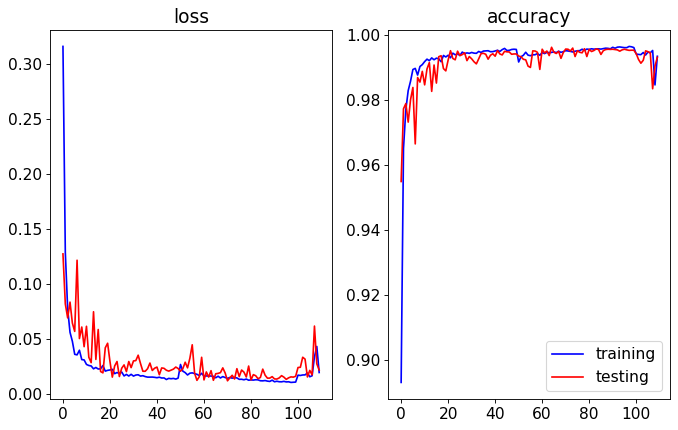

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


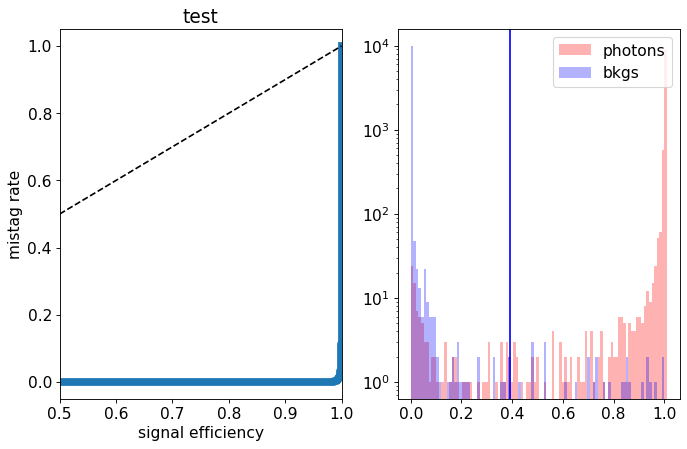

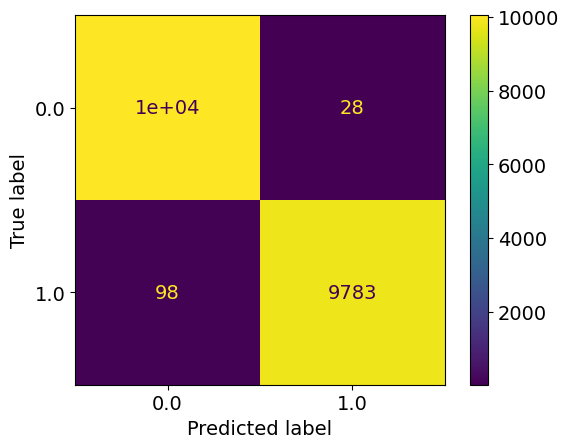

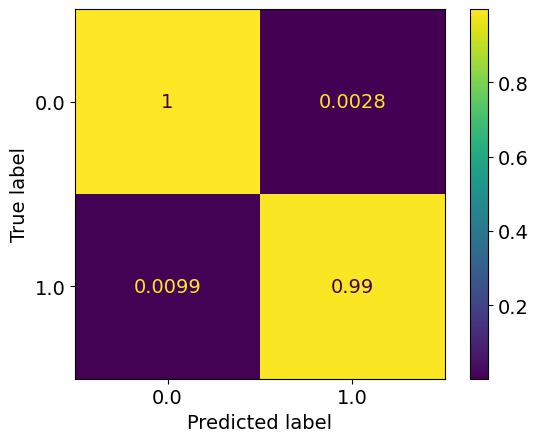

epoch: 110
Learning rate: 0.0009046462573286205


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01763546206196075
train acc: 0.9948877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.04073744456228964
test acc: 0.98917454
epoch: 111
Learning rate: 0.0008854060213086439


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.022872781877052134
train acc: 0.99231905


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.014606341189659467
test acc: 0.9948379
epoch: 112
Learning rate: 0.0008646447637978247


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.015239302485958854
train acc: 0.99493784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.02980117829900016
test acc: 0.99168044
epoch: 113
Learning rate: 0.0008424444199946417


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.014663522981399143
train acc: 0.99511325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.021894677812644446
test acc: 0.9940861
epoch: 114
Learning rate: 0.0008188926045137139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.013993821979097244
train acc: 0.99513835


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.024867031634237396
test acc: 0.99273294
epoch: 115
Learning rate: 0.0007940822656109432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.014204629187805773
train acc: 0.99540144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.016539617797688526
test acc: 0.9945873
epoch: 116
Learning rate: 0.0007681113183592136


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.013858370586685443
train acc: 0.9953889


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.018456178922754002
test acc: 0.99423647
epoch: 117
Learning rate: 0.00074108225822233


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013612118218582088
train acc: 0.9953263


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.017276230480467135
test acc: 0.9945873
epoch: 118
Learning rate: 0.0007131017565522502


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.014084830586954868
train acc: 0.9955268


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.022078247764832613
test acc: 0.9939859
epoch: 119
Learning rate: 0.0006842802396059904


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.01326379815675036
train acc: 0.99563956


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.014664514360072859
test acc: 0.9954894


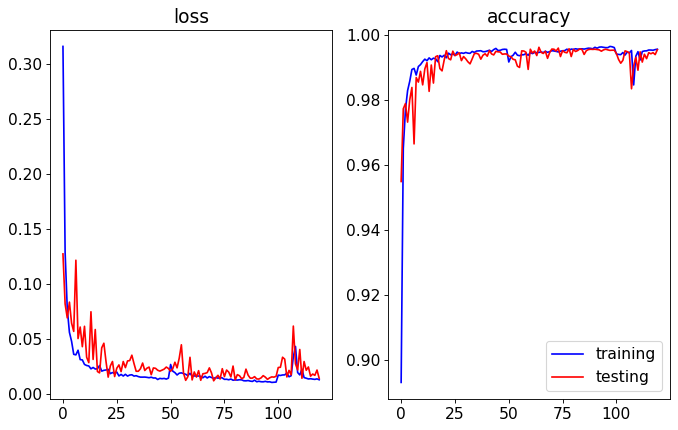

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


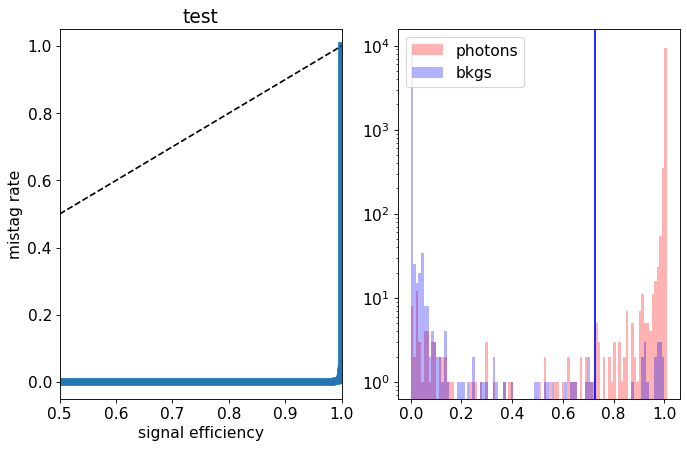

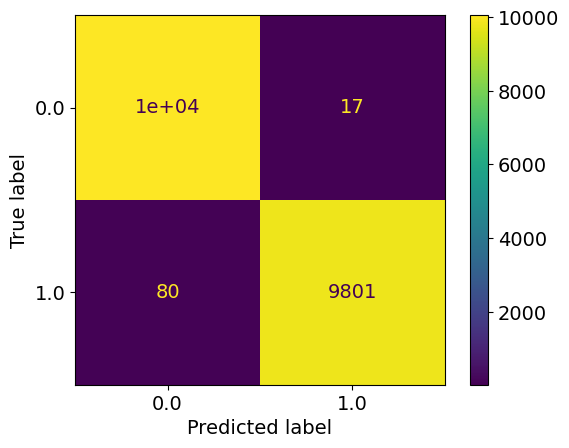

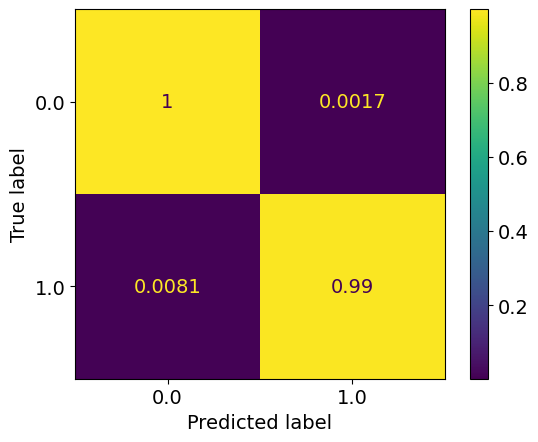

epoch: 120
Learning rate: 0.0006547314527436389


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.013808698683574018
train acc: 0.99540144


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.025165813324479935
test acc: 0.9926828
epoch: 121
Learning rate: 0.0006245720115273849


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013547692285440584
train acc: 0.99528867


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.010904886852265061
test acc: 0.9960407
epoch: 122
Learning rate: 0.000593920941493171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012506511965905553
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.06it/s]


test loss: 0.021170665893484566
test acc: 0.9937854
epoch: 123
Learning rate: 0.00056289920841128


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.012501563038503223
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.024755443162147832
test acc: 0.99388564
epoch: 124
Learning rate: 0.0005316292408897048


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012383354701898443
train acc: 0.99584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.0145323621280327
test acc: 0.9955896
epoch: 125
Learning rate: 0.0005002344472043636


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.012296780996865578
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.0210705755812609
test acc: 0.99403596
epoch: 126
Learning rate: 0.00046883872826301544


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.012203843874940232
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.020942535532145378
test acc: 0.99478775
epoch: 127
Learning rate: 0.0004375659886249823


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.011983070178133342
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.0223449118750389
test acc: 0.9940861
epoch: 128
Learning rate: 0.0004065396475064596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.011842906295231529
train acc: 0.9960405


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.019142980413401827
test acc: 0.9949381
epoch: 129
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.014078282031800542
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.02262077051872278
test acc: 0.99363506


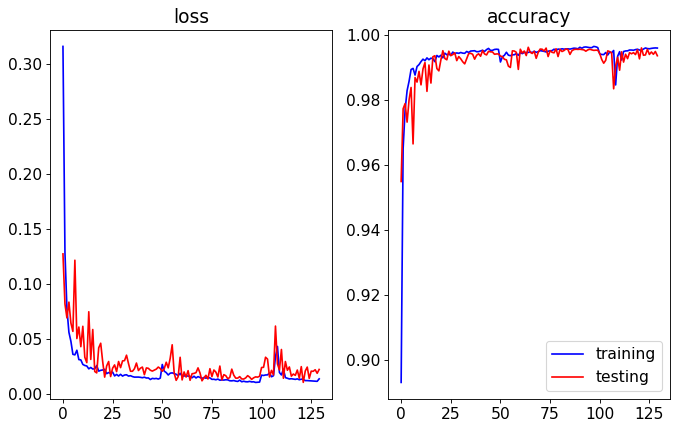

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


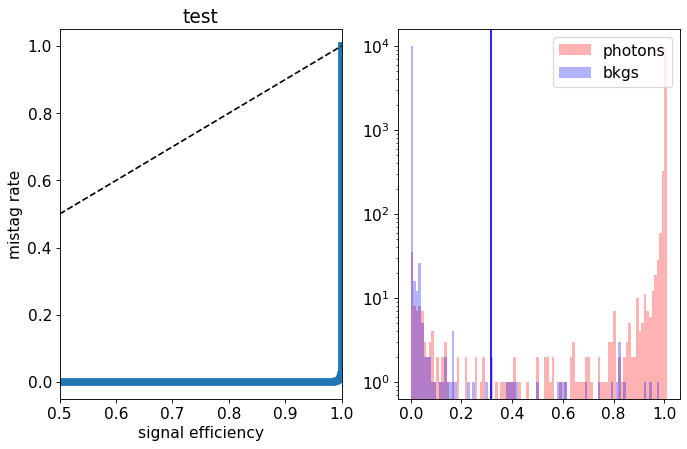

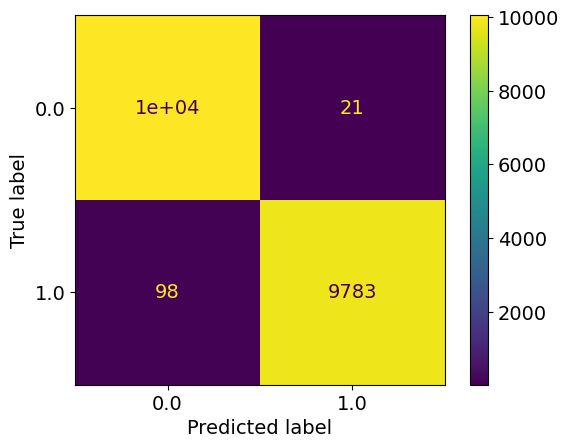

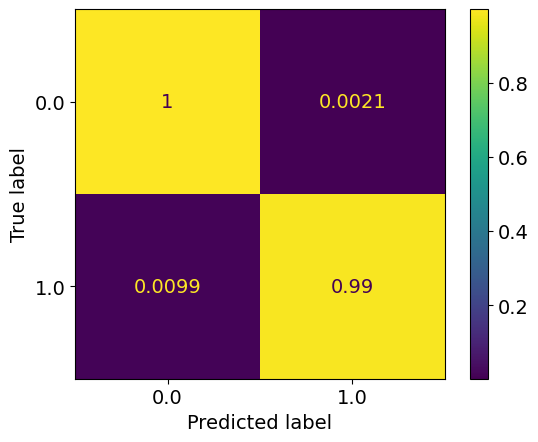

epoch: 130
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.021680086333332443
train acc: 0.9933841


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.018575615948066115
test acc: 0.9951386
epoch: 131
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01324907923986051
train acc: 0.99542654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.015097965328844594
test acc: 0.99523884
epoch: 132
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012160248328139311
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.013681504880557494
test acc: 0.9952889
epoch: 133
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.012016851300331973
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.015507138810147914
test acc: 0.9951887
epoch: 134
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011942215503624348
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.015558702979058795
test acc: 0.9952889
epoch: 135
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.011611930490818932
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.01498348790440051
test acc: 0.99563974
epoch: 136
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.0111168017537062
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.013496194832602186
test acc: 0.9955896
epoch: 137
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011605809401649523
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.98it/s]


test loss: 0.019654634566155866
test acc: 0.9945873
epoch: 138
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010597009918958282
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.015048666110755327
test acc: 0.99533904
epoch: 139
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010612355269758912
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.017188000985804724
test acc: 0.99508846


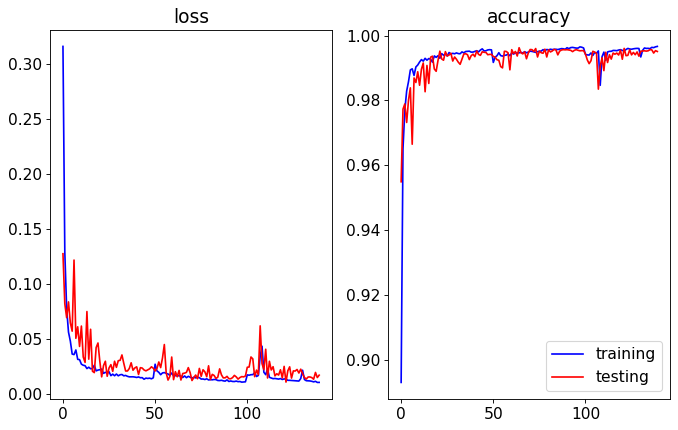

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  8.98it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


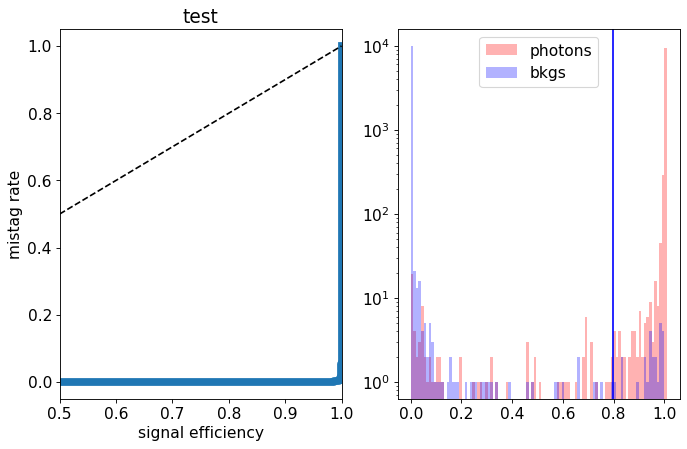

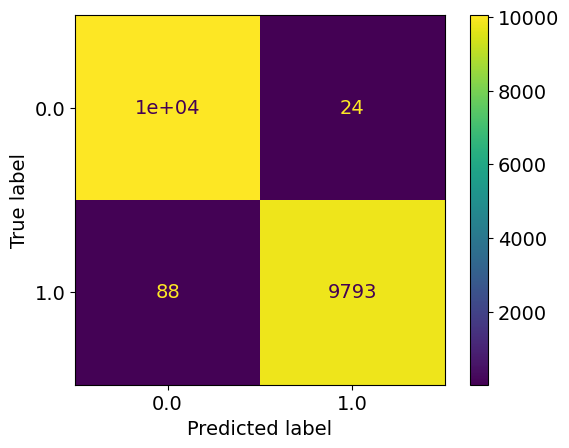

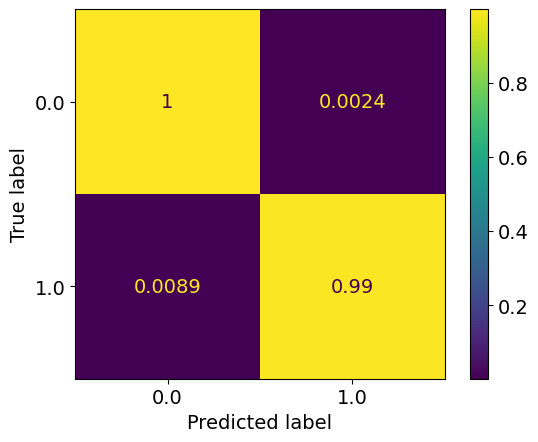

epoch: 140
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.011016181107654337
train acc: 0.99639136


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.05it/s]


test loss: 0.015174319894011953
test acc: 0.9954894
epoch: 141
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.011331459153756333
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.24it/s]


test loss: 0.014975360440610744
test acc: 0.99538916
epoch: 142
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.57it/s]


train loss: 0.010611558746574308
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.01517849086153814
test acc: 0.9955896
epoch: 143
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010969601092215474
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.016003456925425458
test acc: 0.99538916
epoch: 144
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.01884357472221409
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01506112889996182
test acc: 0.99574
epoch: 145
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.011690654079437373
train acc: 0.99589014


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.013613910701892832
test acc: 0.9955896
epoch: 146
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.01084178891606323
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.013773251995992134
test acc: 0.9954894
epoch: 147
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010314090699331015
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.014302081722930512
test acc: 0.9954894
epoch: 148
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.01086160059107829
train acc: 0.9962786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.014366189894430777
test acc: 0.9954393
epoch: 149
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010452827171130634
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01512963163515772
test acc: 0.9954894


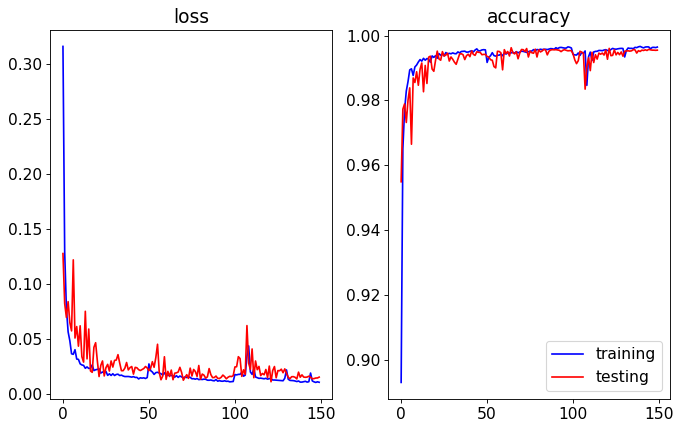

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


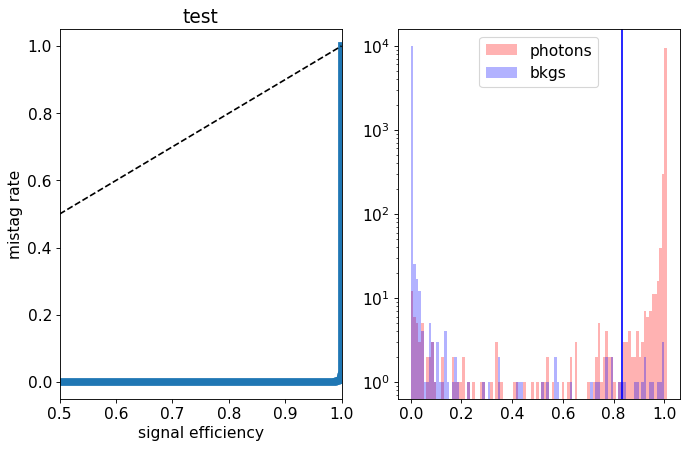

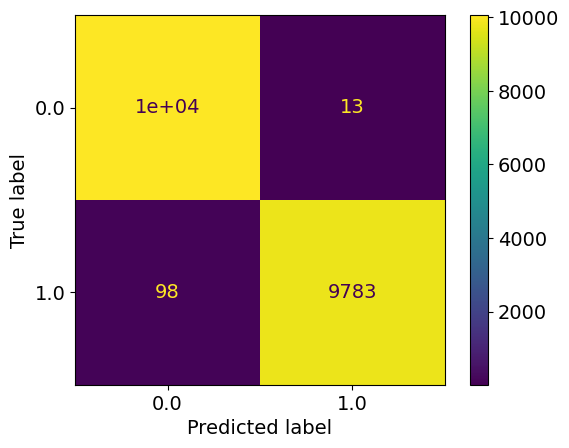

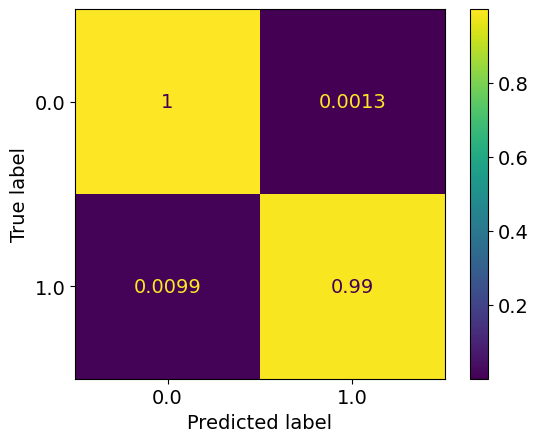

epoch: 150
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.015007736369856257
train acc: 0.9950631


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.01534780758597395
test acc: 0.994888
epoch: 151
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013000289998909642
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.017075231661746168
test acc: 0.9948379
epoch: 152
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.012624572183995042
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.01785284051712712
test acc: 0.99448705
epoch: 153
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01278403887126435
train acc: 0.99575233


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.012040997810853535
test acc: 0.9957901
epoch: 154
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013320538241402316
train acc: 0.99557686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.10it/s]


test loss: 0.024919105923104593
test acc: 0.9924823
epoch: 155
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013430031787937701
train acc: 0.9953388


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.016100346614942227
test acc: 0.99538916
epoch: 156
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014015845619588387
train acc: 0.99526364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.017656423478483167
test acc: 0.9948379
epoch: 157
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.01330392464818155
train acc: 0.99558944


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.0157550814362955
test acc: 0.99553955
epoch: 158
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.012811406798758057
train acc: 0.99560195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.019000867946648643
test acc: 0.99393576
epoch: 159
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.012734960420613192
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.025423713182510042
test acc: 0.99313384


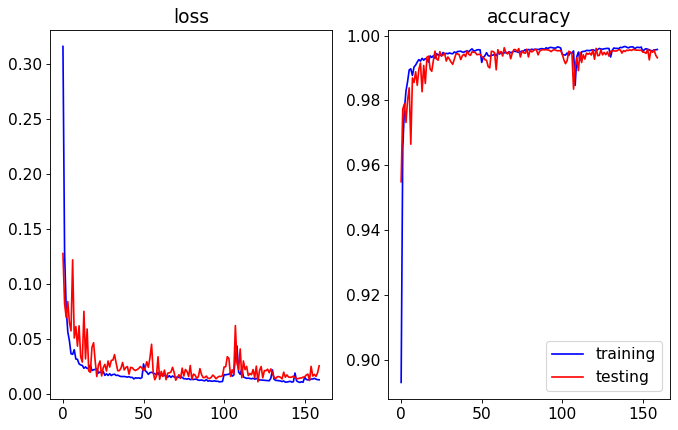

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


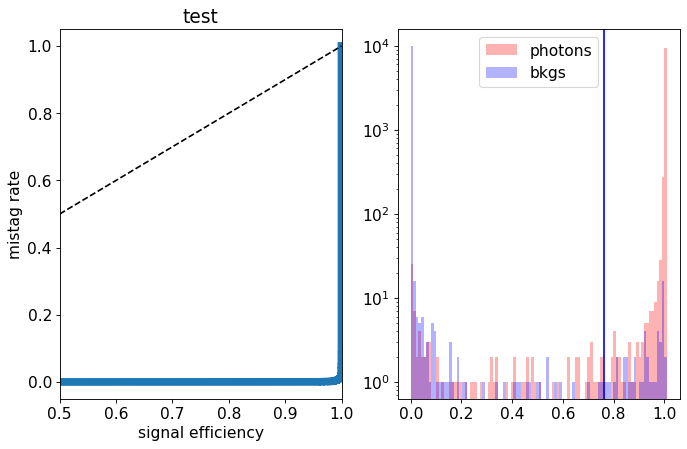

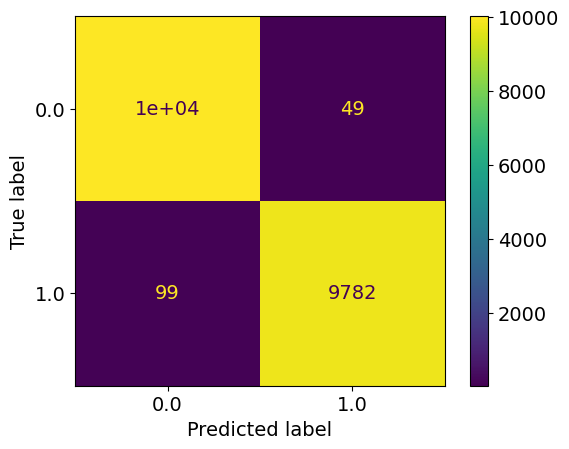

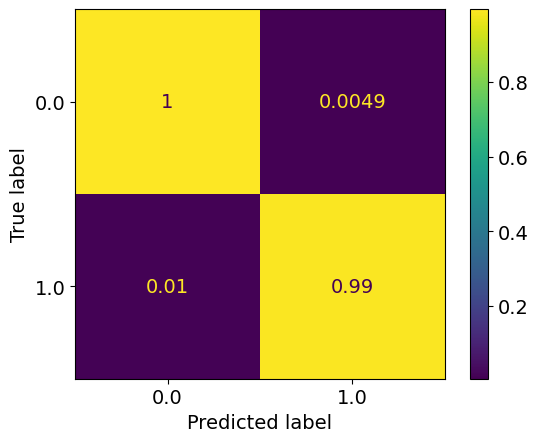

epoch: 160
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013263853885400207
train acc: 0.995815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.019529307748598512
test acc: 0.99393576
epoch: 161
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.34it/s]


train loss: 0.013592090755666314
train acc: 0.99547666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.018987074497785857
test acc: 0.9945873
epoch: 162
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.012682966326724793
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.01318194149472915
test acc: 0.99553955
epoch: 163
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.012475801911552563
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.02857960306060062
test acc: 0.992332
epoch: 164
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01615490071273951
train acc: 0.99451184


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.019115565305315507
test acc: 0.9947376
epoch: 165
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.013735243817791343
train acc: 0.9955142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.02009690194780192
test acc: 0.9935348
epoch: 166
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01370803800818976
train acc: 0.995201


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.021586553402491573
test acc: 0.99423647
epoch: 167
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012153905105721483
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.17it/s]


test loss: 0.019447288530714372
test acc: 0.9942866
epoch: 168
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.0122786924745123
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.030702376929933533
test acc: 0.99258256
epoch: 169
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01239447088507282
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.020209599766745027
test acc: 0.99423647


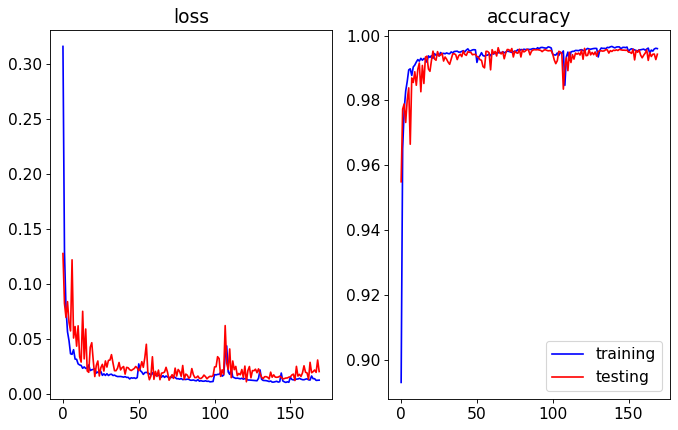

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.30it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


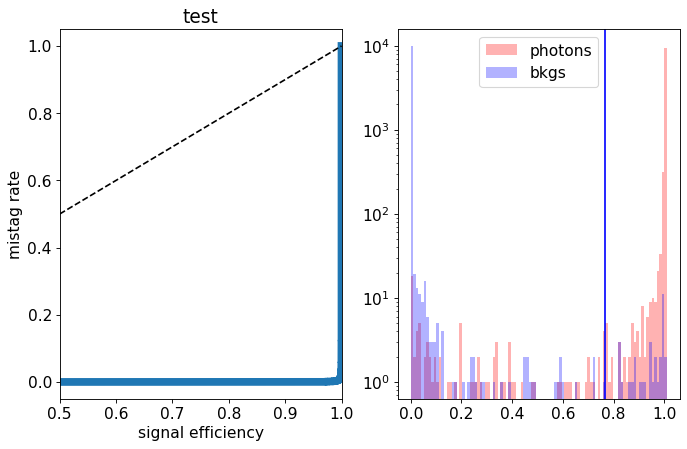

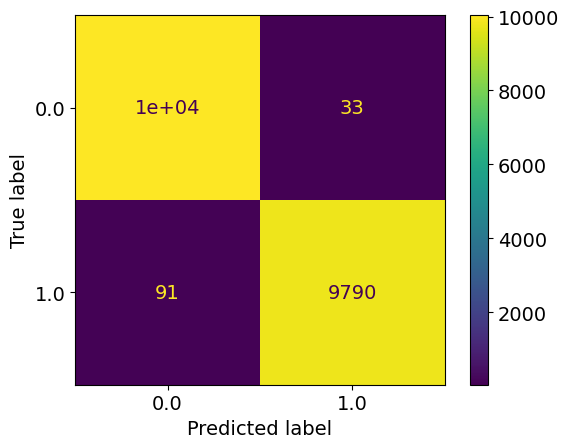

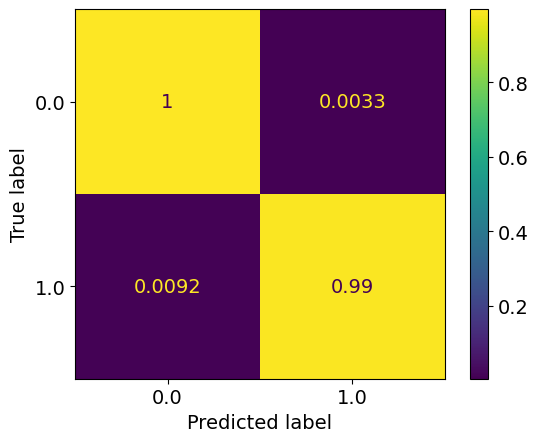

epoch: 170
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012483798272372571
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.017998425495427323
test acc: 0.9943868
epoch: 171
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.012143317630875911
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.21it/s]


test loss: 0.014695876058848464
test acc: 0.9951386
epoch: 172
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01148166848719511
train acc: 0.9957022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.017562760740367916
test acc: 0.99523884
epoch: 173
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.013278044737639156
train acc: 0.99560195


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.015989327111610156
test acc: 0.9945372
epoch: 174
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.014879307209819455
train acc: 0.99515086


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.01194329883711522
test acc: 0.9958903
epoch: 175
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01208228961766113
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.022005803102408263
test acc: 0.9936852
epoch: 176
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011774374910546883
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.02360726284720894
test acc: 0.99373525
epoch: 177
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013042402408544474
train acc: 0.99592775


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.023316803908742526
test acc: 0.9939859
epoch: 178
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011220602813752398
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.014875714633329635
test acc: 0.9949381
epoch: 179
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010732470574030638
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.017732146822655684
test acc: 0.9948379


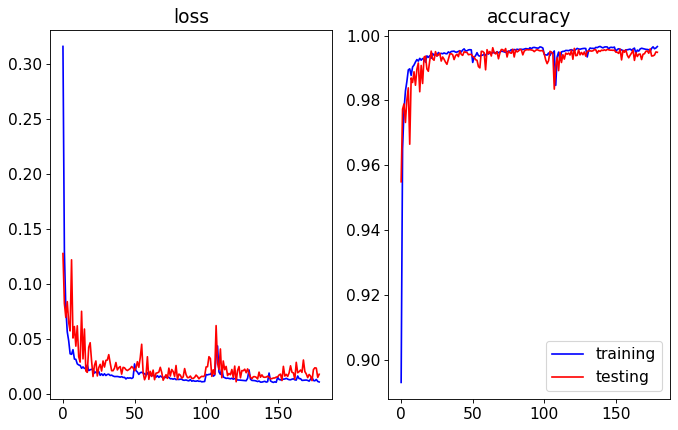

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


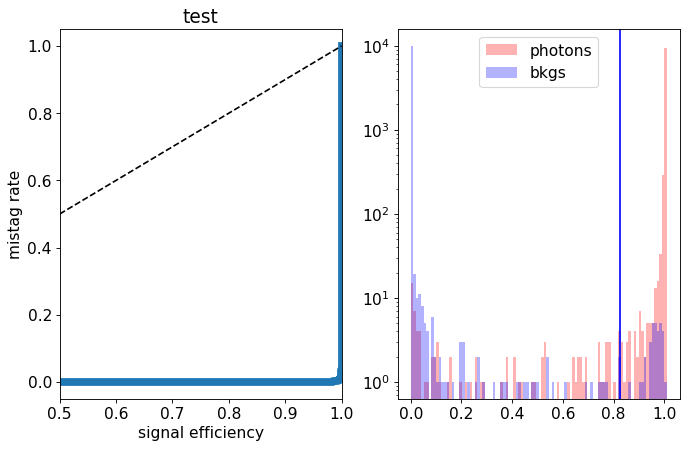

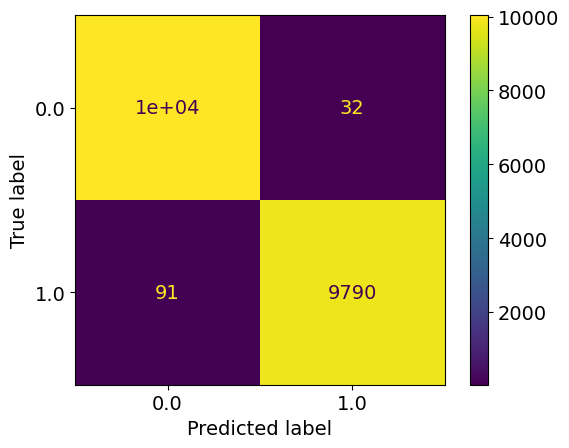

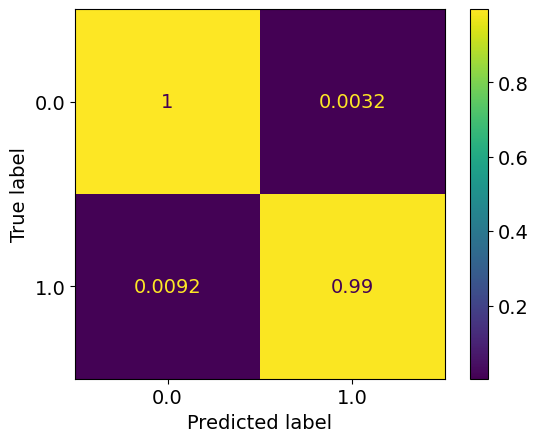

epoch: 180
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010708626636839124
train acc: 0.9962535


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.019334781706086632
test acc: 0.9945873
epoch: 181
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01054912995991867
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.010353932119495072
test acc: 0.9959906
epoch: 182
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010437867139403555
train acc: 0.99635375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.012326642761335653
test acc: 0.99553955
epoch: 183
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012073041347321123
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.022400969231966883
test acc: 0.9941362
epoch: 184
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.014803160855080932
train acc: 0.9950506


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.60it/s]


test loss: 0.018414206446751076
test acc: 0.99448705
epoch: 185
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010585934350287903
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.019204959011403844
test acc: 0.9946875
epoch: 186
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01081566097833383
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.017091887897870892
test acc: 0.9946875
epoch: 187
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009907838604230598
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.012700848310487345
test acc: 0.9957901
epoch: 188
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010377327847266709
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.01601251950898372
test acc: 0.9952889
epoch: 189
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009487399653316155
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.017116686716155315
test acc: 0.9948379


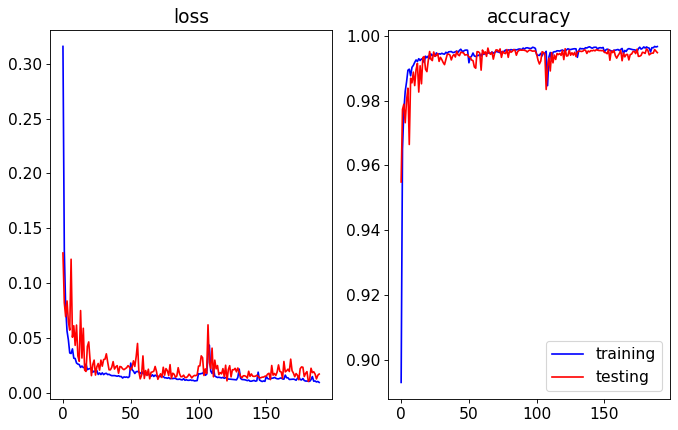

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


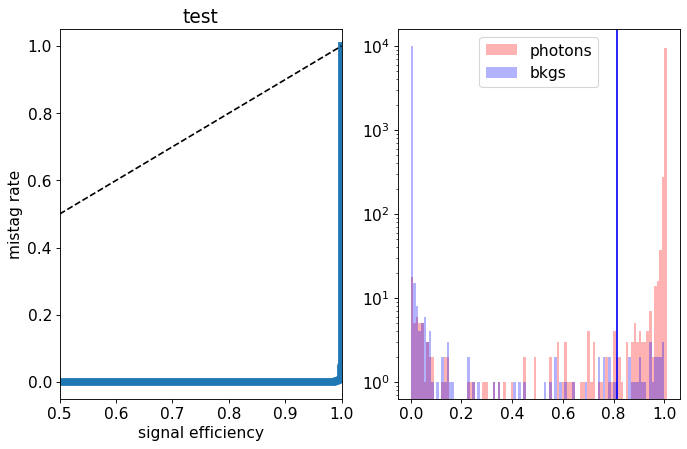

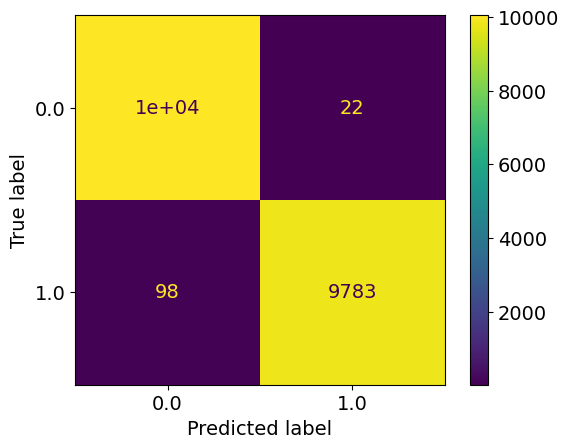

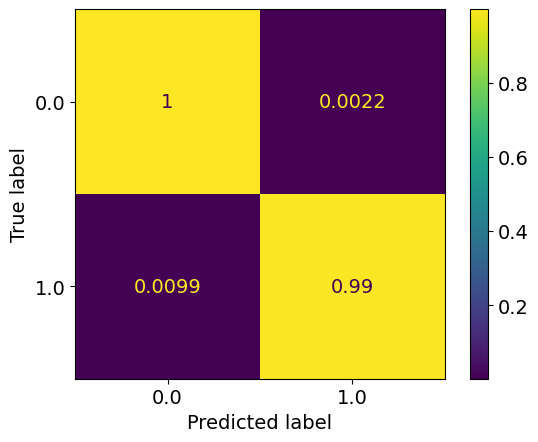

epoch: 190
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00977275066843368
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.016025307309652872
test acc: 0.9952889
epoch: 191
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009711598934842839
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.016993504070663166
test acc: 0.9948379
epoch: 192
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.009824025537590618
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.016137736479696983
test acc: 0.9948379
epoch: 193
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.0095775218415743
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.018103112367337897
test acc: 0.9948379
epoch: 194
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009049281753980166
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.017387546578367406
test acc: 0.9949381
epoch: 195
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.009734747232652075
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.016941911893595448
test acc: 0.994888
epoch: 196
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01003981039847626
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.01684144266661914
test acc: 0.994888
epoch: 197
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009580278599759054
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.98it/s]


test loss: 0.01755283784073339
test acc: 0.994888
epoch: 198
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009544397965043179
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.016425016293985264
test acc: 0.9948379
epoch: 199
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009872268890586696
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.016525637714520973
test acc: 0.9948379


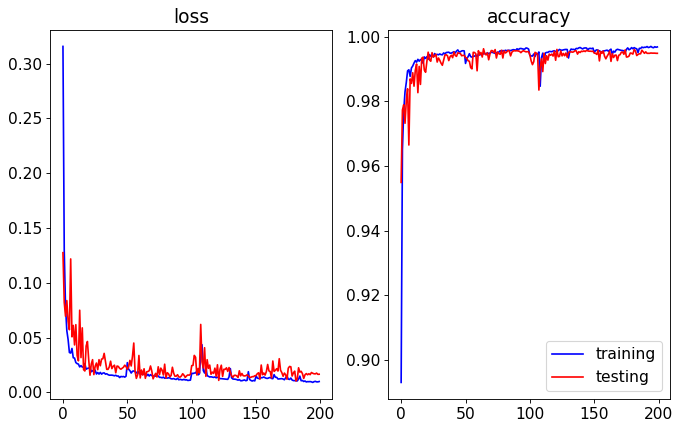

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.01it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


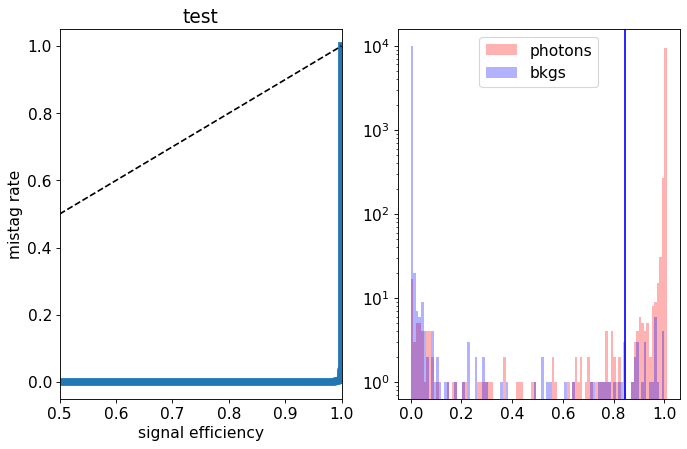

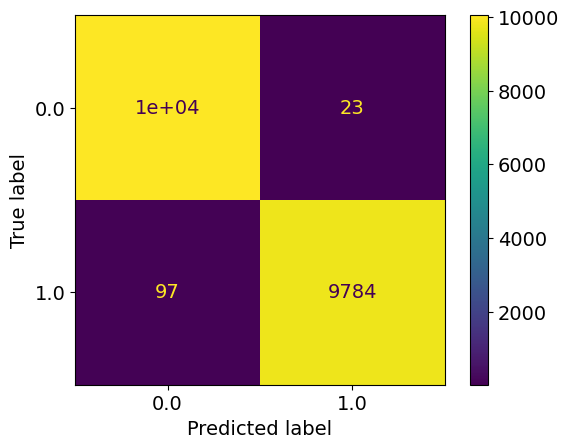

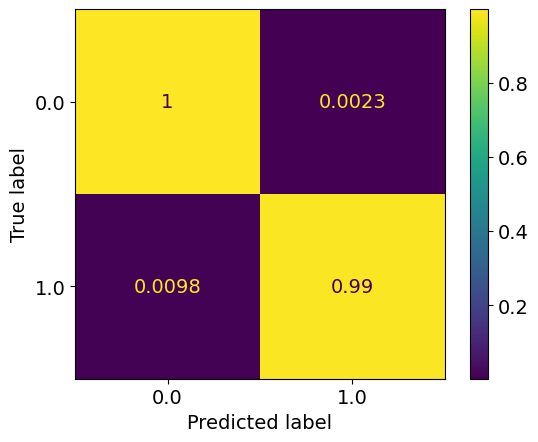

epoch: 200
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.016059122791986413
train acc: 0.9955142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.016252064658842488
test acc: 0.99393576
epoch: 201
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.021656601006901866
train acc: 0.9928704


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.15it/s]


test loss: 0.025740468648591024
test acc: 0.99273294
epoch: 202
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013918506853159086
train acc: 0.9951634


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.029146267123424503
test acc: 0.9938355
epoch: 203
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01239652510032183
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.99it/s]


test loss: 0.02921489727519014
test acc: 0.9926828
epoch: 204
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.014979956340159415
train acc: 0.99526364


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.023831887150128538
test acc: 0.9922317
epoch: 205
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012667431085372218
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.019137436350694557
test acc: 0.99478775
epoch: 206
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01325068644244094
train acc: 0.99545157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.01558607239241931
test acc: 0.99538916
epoch: 207
Learning rate: 0.0009525132992633265


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013536045460813198
train acc: 0.99542654


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.01803924043334144
test acc: 0.99503833
epoch: 208
Learning rate: 0.0009382662376573865


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.012218677317167618
train acc: 0.99568963


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.013375056312618065
test acc: 0.9954393
epoch: 209
Learning rate: 0.0009222895394362112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.012420613657475281
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.014918049951494835
test acc: 0.9951386


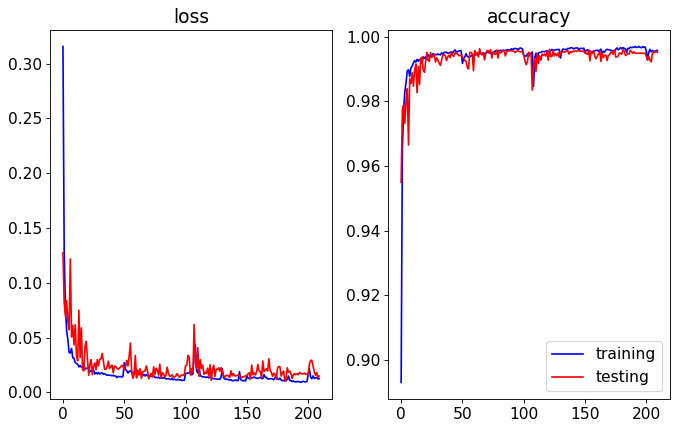

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


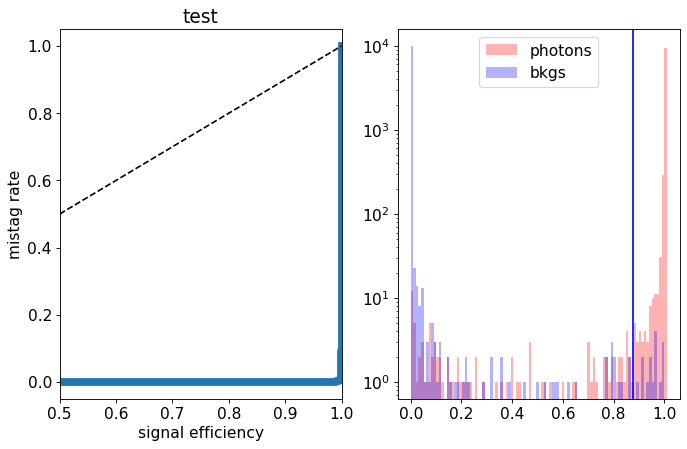

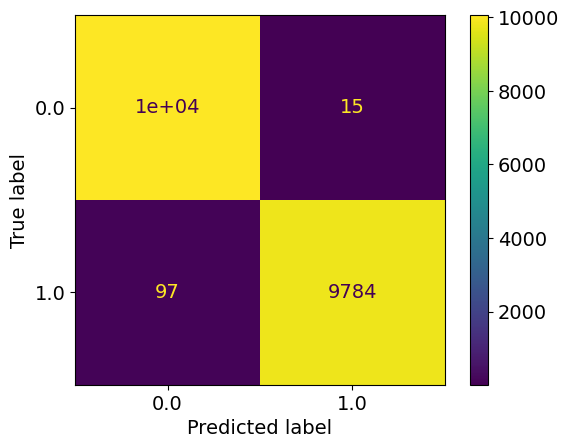

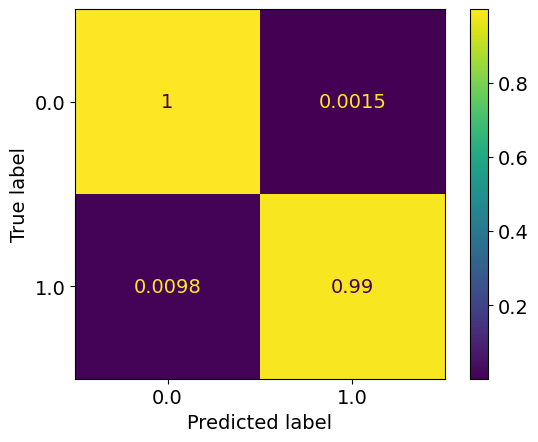

epoch: 210
Learning rate: 0.0009046462573286203


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.012268331480897102
train acc: 0.9960781


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.01788539532572031
test acc: 0.99418634
epoch: 211
Learning rate: 0.0008854060213086437


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.013778388052850827
train acc: 0.9953764


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.02165497008108479
test acc: 0.99393576
epoch: 212
Learning rate: 0.0008646447637978243


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011999303710113122
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.024162871422424147
test acc: 0.99403596
epoch: 213
Learning rate: 0.0008424444199946415


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011358112899388425
train acc: 0.9964289


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.02631311969119398
test acc: 0.9935348
epoch: 214
Learning rate: 0.0008188926045137135


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01218624762433178
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.29it/s]


test loss: 0.029500319006140616
test acc: 0.992332
epoch: 215
Learning rate: 0.0007940822656109428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01589940588942159
train acc: 0.9947624


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]


test loss: 0.02212731627685785
test acc: 0.9935348
epoch: 216
Learning rate: 0.0007681113183592132


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.012309626275638757
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.01654457680278403
test acc: 0.9945873
epoch: 217
Learning rate: 0.0007410822582223297


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.012580425399459843
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.016840253749465132
test acc: 0.99448705
epoch: 218
Learning rate: 0.0007131017565522497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012458389929091013
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.022659888996071565
test acc: 0.99373525
epoch: 219
Learning rate: 0.00068428023960599


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.011261973761776714
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.023894058379536384
test acc: 0.9934847


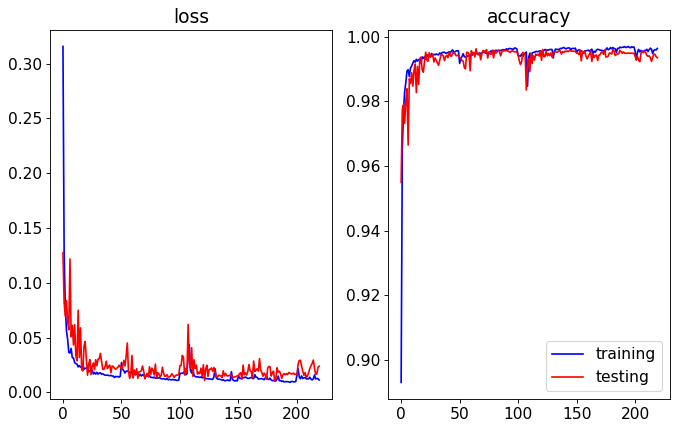

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


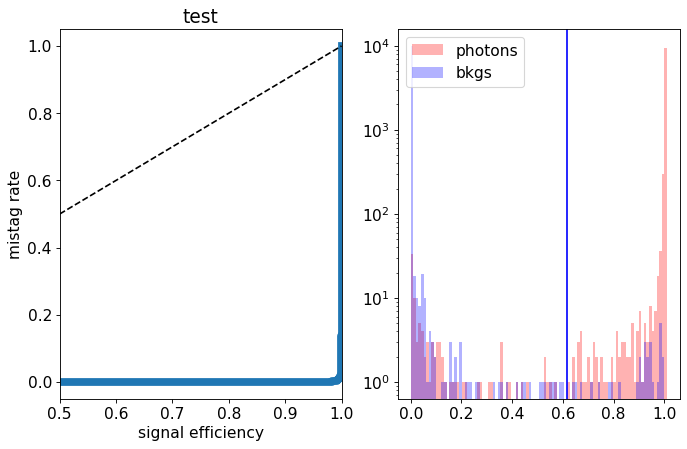

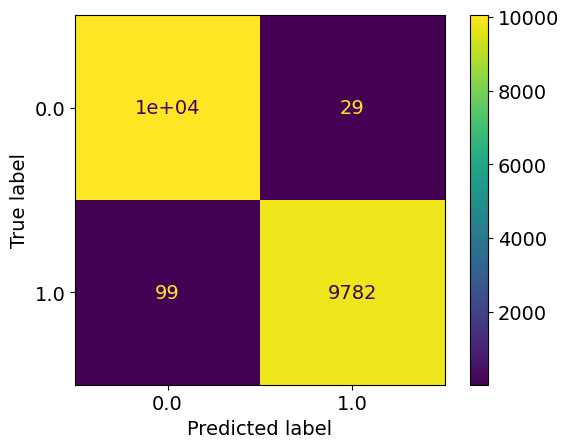

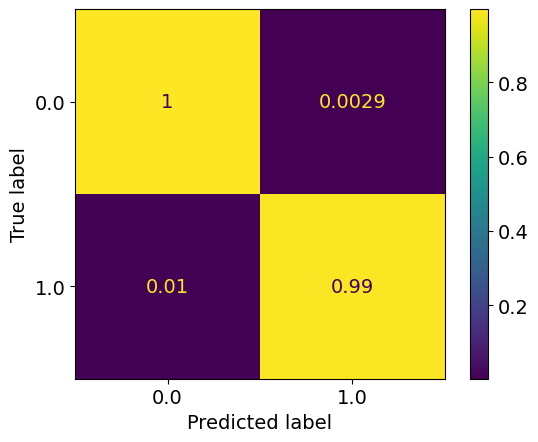

epoch: 220
Learning rate: 0.0006547314527436385


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.011537517606864557
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.014821791470988983
test acc: 0.99553955
epoch: 221
Learning rate: 0.0006245720115273845


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.011732173230185838
train acc: 0.99610317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.02973704378682134
test acc: 0.9932341
epoch: 222
Learning rate: 0.0005939209414931706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011100547853640086
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.024286079155418146
test acc: 0.99393576
epoch: 223
Learning rate: 0.0005628992084112796


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011418595530350652
train acc: 0.9961157


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.01724669779650867
test acc: 0.99448705
epoch: 224
Learning rate: 0.0005316292408897043


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012163615976668783
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.02056948740295518
test acc: 0.99423647
epoch: 225
Learning rate: 0.0005002344472043631


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01046746905509525
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.021566114453461897
test acc: 0.9936852
epoch: 226
Learning rate: 0.000468838728263015


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010805579726287923
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.016350849457975367
test acc: 0.994888
epoch: 227
Learning rate: 0.0004375659886249818


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010570700989285512
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.06it/s]


test loss: 0.02678858722998377
test acc: 0.9930838
epoch: 228
Learning rate: 0.0004065396475064592


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010760577458109873
train acc: 0.9961783


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.026037995525471428
test acc: 0.99423647
epoch: 229
Learning rate: 0.000375882151701255


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010097915110317946
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.027063940501059678
test acc: 0.9933845


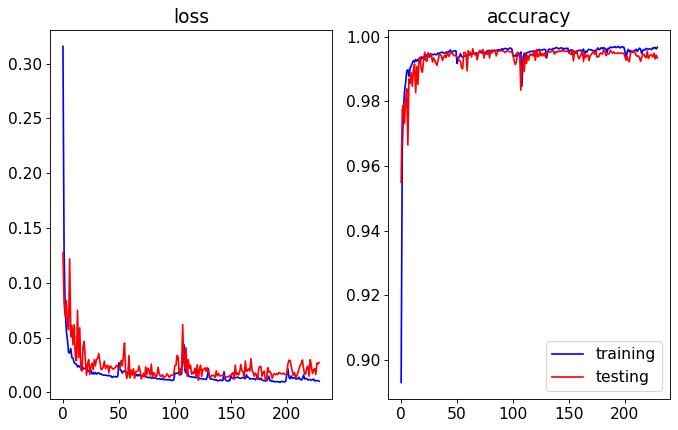

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.24it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


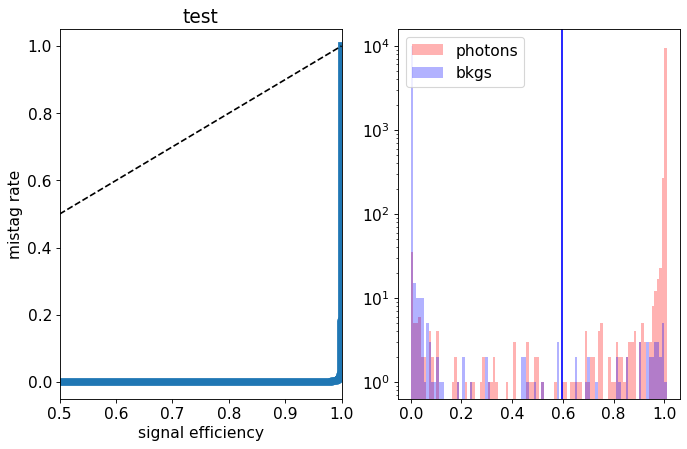

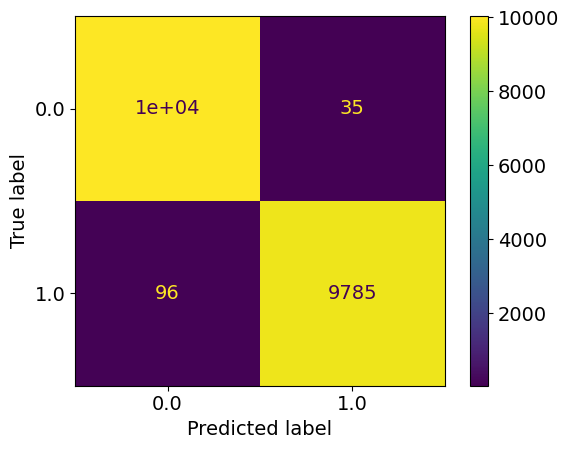

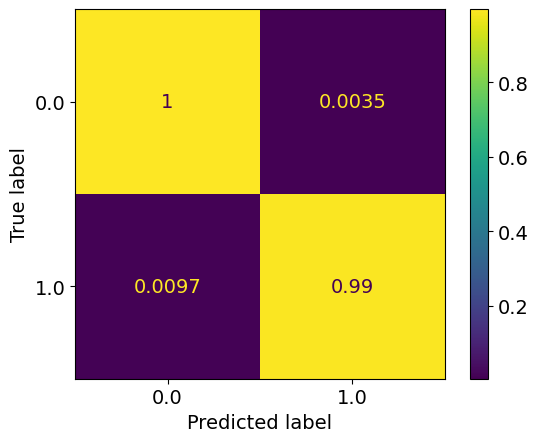

epoch: 230
Learning rate: 0.000345714492339235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010397023257155524
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.016528464699684477
test acc: 0.9948379
epoch: 231
Learning rate: 0.0003161557273896083


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012486049132213108
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.37it/s]


test loss: 0.022839519123355037
test acc: 0.99363506
epoch: 232
Learning rate: 0.0002873225117935158


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01499231414608905
train acc: 0.9948752


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.017664079896776992
test acc: 0.9949882
epoch: 233
Learning rate: 0.0002593286370802722


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01064529746308021
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.014822772436994402
test acc: 0.99523884
epoch: 234
Learning rate: 0.0002322845822841862


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.0096427347465877
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.26it/s]


test loss: 0.0187436323681408
test acc: 0.9948379
epoch: 235
Learning rate: 0.00020629707793428403


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01022060948280672
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.017037212444633684
test acc: 0.994888
epoch: 236
Learning rate: 0.00018146868483767353


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.010417102905927067
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.020368512836284935
test acc: 0.9941362
epoch: 237
Learning rate: 0.00015789738931889325


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010364912896861892
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.018308018553344643
test acc: 0.99478775
epoch: 238
Learning rate: 0.00013567621651265532


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.010248801552625624
train acc: 0.9966294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01970513883005718
test acc: 0.99418634
epoch: 239
Learning rate: 0.00011489286323613752


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009834319610830002
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.01830075789920931
test acc: 0.99478775


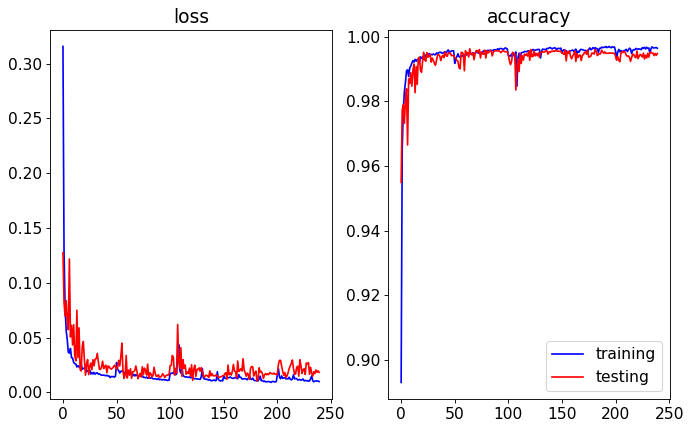

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


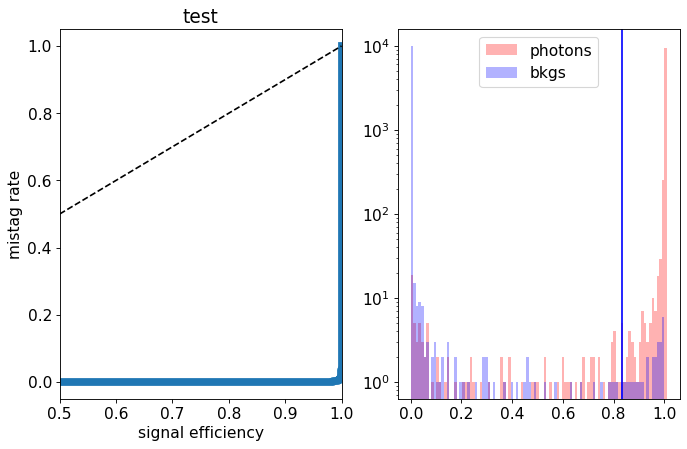

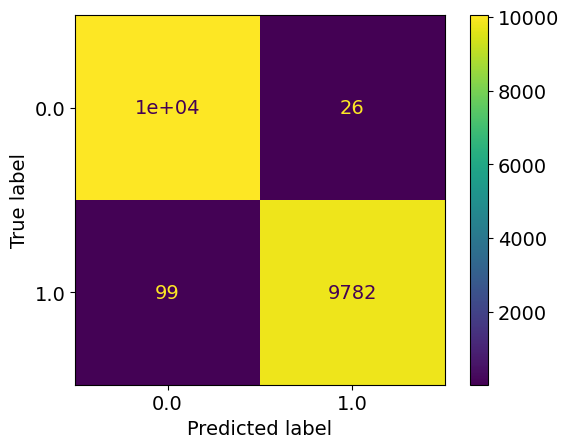

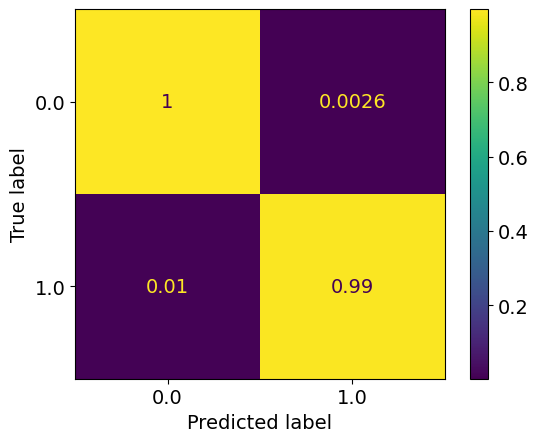

epoch: 240
Learning rate: 9.56293518897114e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009963333525924255
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.022381782663133516
test acc: 0.9941362
epoch: 241
Learning rate: 7.79617067520002e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009767968661096225
train acc: 0.9965918


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.01940332930569318
test acc: 0.99418634
epoch: 242
Learning rate: 6.195965394678321e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009743676765868991
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.021006838658221942
test acc: 0.99393576
epoch: 243
Learning rate: 4.7686346265839844e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00985182761742995
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.021269378140192096
test acc: 0.99403596
epoch: 244
Learning rate: 3.5198113933733125e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009103569801801083
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02220112324336215
test acc: 0.9940861
epoch: 245
Learning rate: 2.4544242298147e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.00943686115753545
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.018400942158597687
test acc: 0.9946875
epoch: 246
Learning rate: 1.5766777323136195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.009210676324046426
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.27it/s]


test loss: 0.020154509665992332
test acc: 0.99433666
epoch: 247
Learning rate: 8.900359652914802e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.009039327558286405
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02139199587947908
test acc: 0.99433666
epoch: 248
Learning rate: 3.972087901059351e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.73it/s]


train loss: 0.009182956162666374
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02090402867179364
test acc: 0.99433666
epoch: 249
Learning rate: 1.0014117046611704e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.46it/s]


train loss: 0.009342744125491147
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.021849310511777943
test acc: 0.99433666


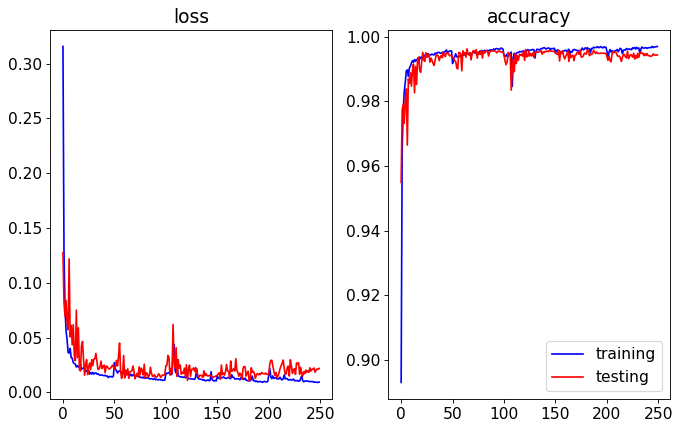

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


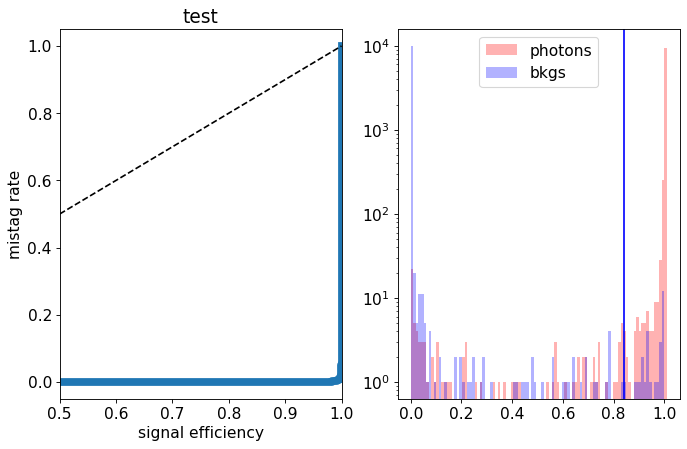

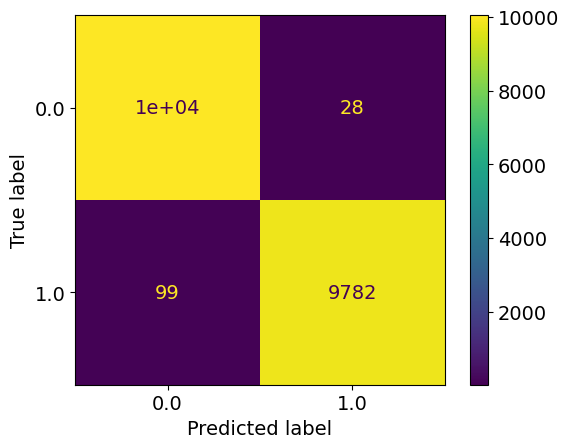

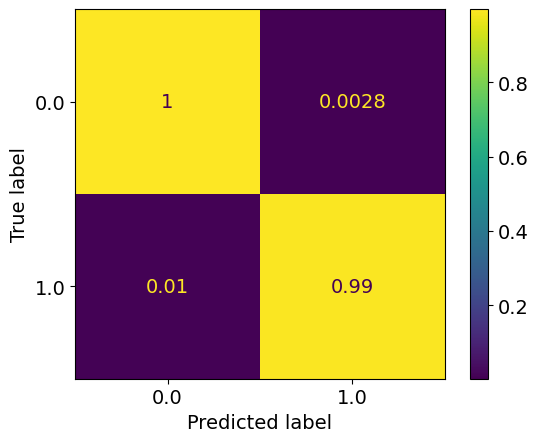

epoch: 250
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.01376100838941925
train acc: 0.995226


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.03546868674183155
test acc: 0.9920814
epoch: 251
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.01344866090655716
train acc: 0.9955393


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.028285358916036785
test acc: 0.99288327
epoch: 252
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01497366071553595
train acc: 0.9948627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.021454750882078183
test acc: 0.9940861
epoch: 253
Learning rate: 0.0009911875023977943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.012599133614037158
train acc: 0.9957899


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.022180949276148835
test acc: 0.9934847
epoch: 254
Learning rate: 0.0009843498319744622


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.012983194707654792
train acc: 0.9957147


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.023717617362682873
test acc: 0.9926327
epoch: 255
Learning rate: 0.0009756006540427168


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.013497222909519671
train acc: 0.9955518


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.021865133815855885
test acc: 0.99393576
epoch: 256
Learning rate: 0.0009649744976107356


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012439845091879516
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03592520160600543
test acc: 0.99273294
epoch: 257
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.01199313993574426
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.017552534159382478
test acc: 0.99388564
epoch: 258
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011899965712812568
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.020982570601250593
test acc: 0.9944369
epoch: 259
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.013095849449051294
train acc: 0.9955142


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.96it/s]


test loss: 0.01956487026387442
test acc: 0.9935348


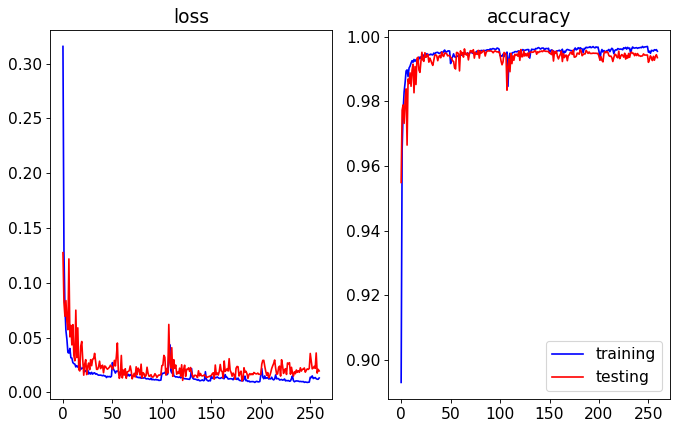

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


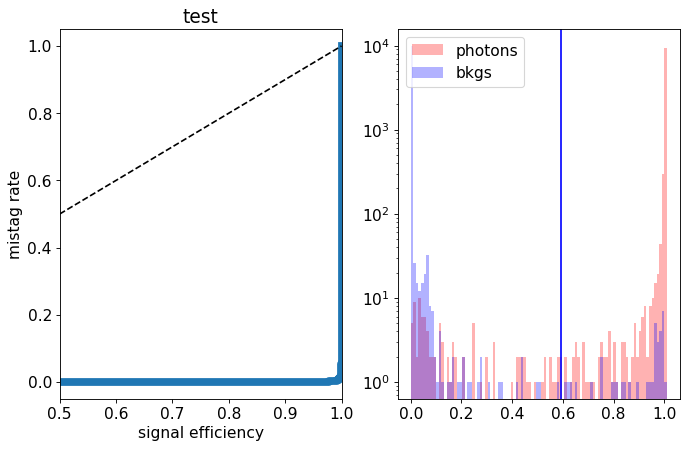

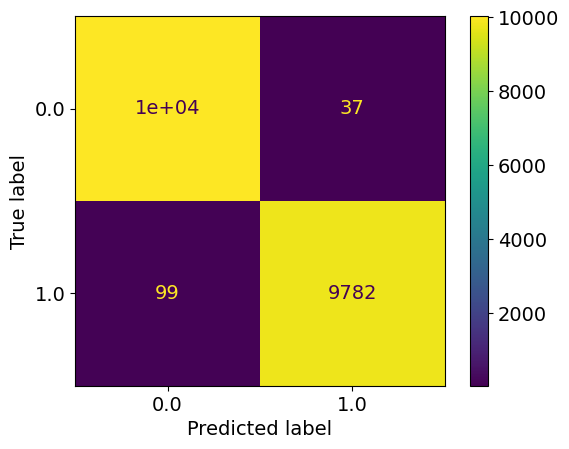

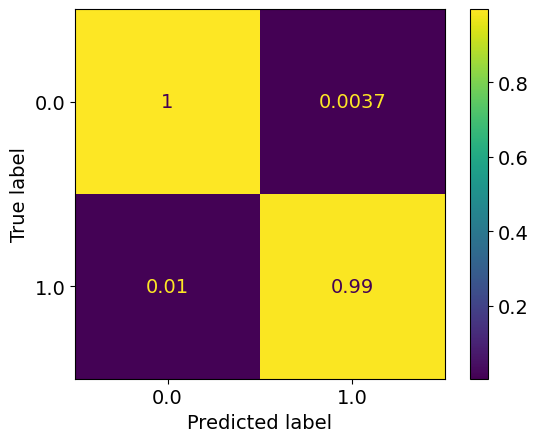

epoch: 260
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01170840099163811
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.03884394336765742
test acc: 0.9908786
epoch: 261
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011407165656929641
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.52it/s]


test loss: 0.02253581430105602
test acc: 0.9936852
epoch: 262
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012197846563167195
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.017957624493112022
test acc: 0.9947376
epoch: 263
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011376361593511998
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.03335114143898382
test acc: 0.9916303
epoch: 264
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.011075039192930028
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.02033292075879324
test acc: 0.99478775
epoch: 265
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.54it/s]


train loss: 0.010881985205781266
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.63it/s]


test loss: 0.0186556504914359
test acc: 0.99478775
epoch: 266
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.011475422453381115
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.58it/s]


test loss: 0.02081275069812203
test acc: 0.99388564
epoch: 267
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010942000089688741
train acc: 0.9961407


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.04331479790819097
test acc: 0.99022704
epoch: 268
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.011033083214205186
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.43it/s]


test loss: 0.02577313773519349
test acc: 0.9929334
epoch: 269
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.011637868166709173
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.023314815839779946
test acc: 0.99463737


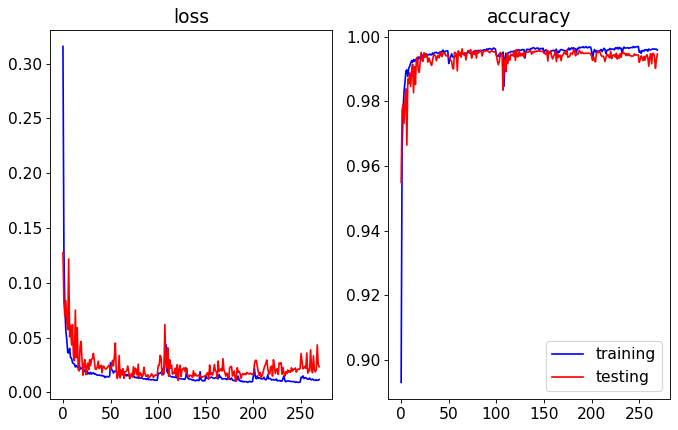

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


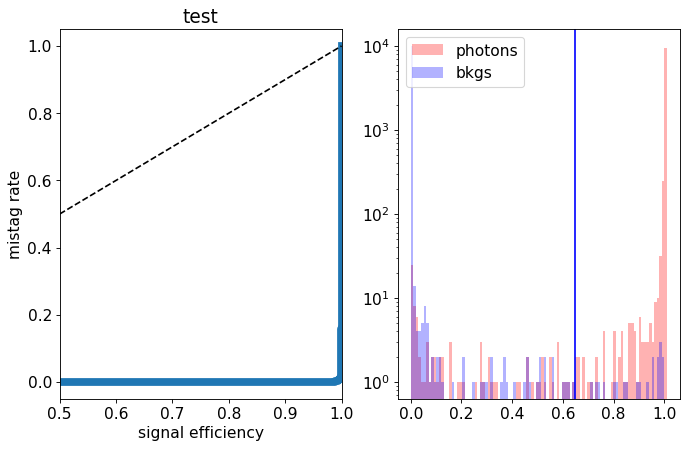

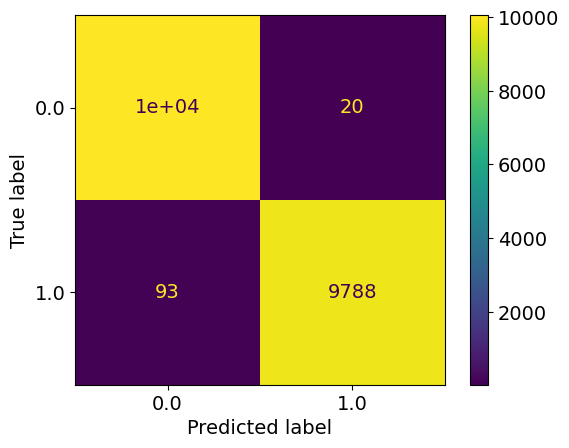

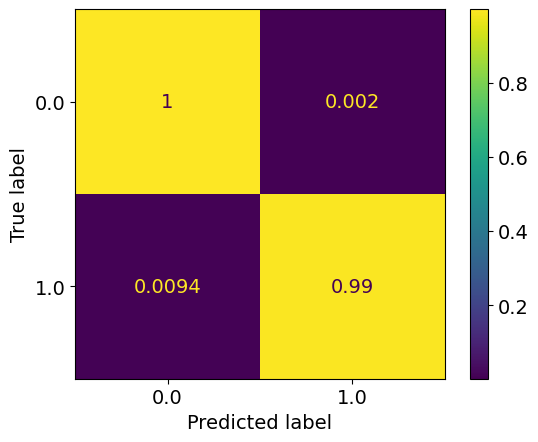

epoch: 270
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.011170311385149713
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.17it/s]


test loss: 0.029224977245629655
test acc: 0.99278307
epoch: 271
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.010904852912951912
train acc: 0.9963036


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.10it/s]


test loss: 0.021443963451447952
test acc: 0.9939859
epoch: 272
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.010596628110409989
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.02469605332076111
test acc: 0.99313384
epoch: 273
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.0108633013103338
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


test loss: 0.019101246061515722
test acc: 0.9940861
epoch: 274
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.30it/s]


train loss: 0.01070515433370793
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.58it/s]


test loss: 0.01976143788316917
test acc: 0.99423647
epoch: 275
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.56it/s]


train loss: 0.010784521659857023
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.69it/s]


test loss: 0.025661622578113833
test acc: 0.99358493
epoch: 276
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.010458358659916348
train acc: 0.9966294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.13it/s]


test loss: 0.03159831204068135
test acc: 0.9922317
epoch: 277
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011788803847539655
train acc: 0.99590266


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.027958096532315454
test acc: 0.9930838
epoch: 278
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009891015029191472
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.022878374852178453
test acc: 0.99363506
epoch: 279
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010597181096395005
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.02819862199591144
test acc: 0.9937854


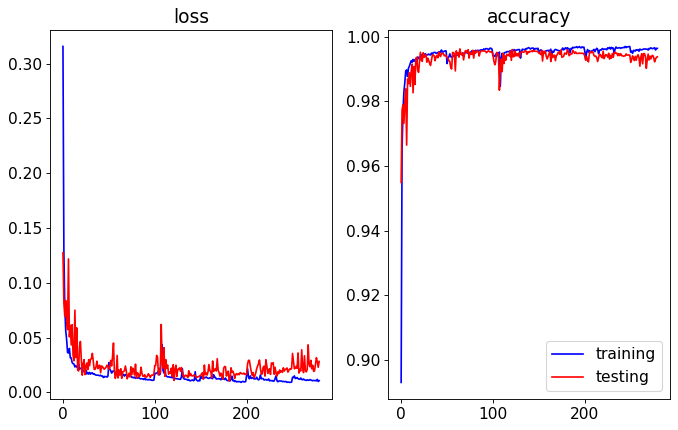

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


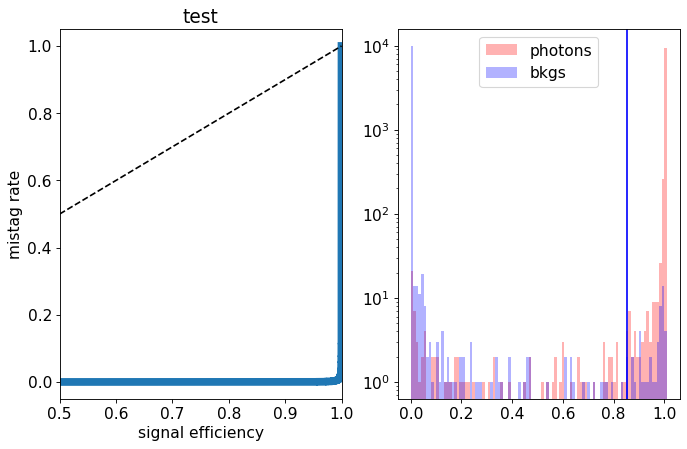

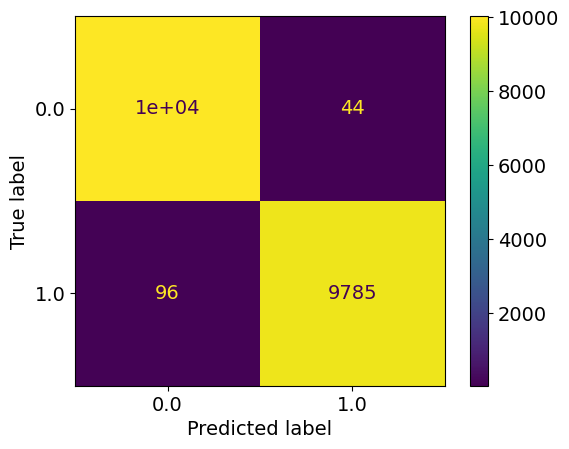

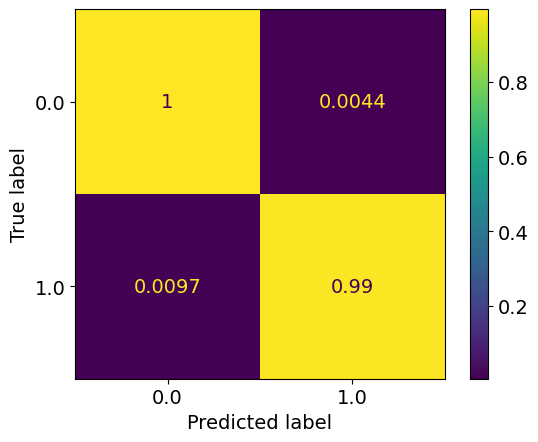

epoch: 280
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009244193574384336
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.028390173530330205
test acc: 0.993184
epoch: 281
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.009424669911334319
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.02954509626964436
test acc: 0.9932341
epoch: 282
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.63it/s]


train loss: 0.009249035334179817
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.022434479505618048
test acc: 0.9934847
epoch: 283
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.43it/s]


train loss: 0.009685873053743972
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.01786744574030094
test acc: 0.99448705
epoch: 284
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008952486751003385
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.029126599636476708
test acc: 0.99343455
epoch: 285
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.009201431390221245
train acc: 0.99688


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.029468584237346315
test acc: 0.99343455
epoch: 286
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009722610447210879
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.023997463785824093
test acc: 0.9940861
epoch: 287
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.009078097518863276
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.03302392736077309
test acc: 0.9926327
epoch: 288
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008955957763307074
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.0253167421940495
test acc: 0.99373525
epoch: 289
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008907396105029481
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.04it/s]


test loss: 0.025892883210497743
test acc: 0.9941362


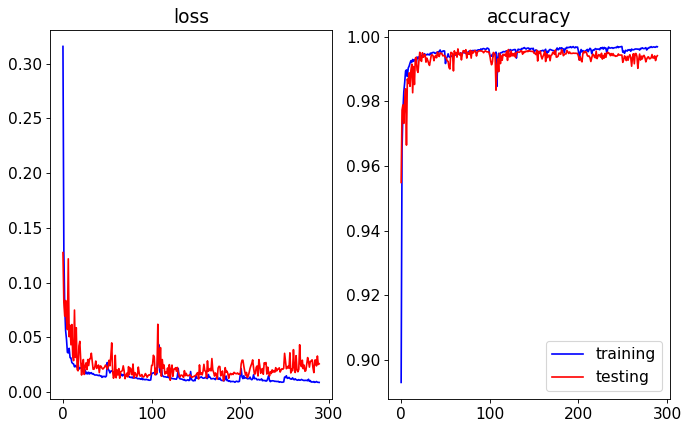

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


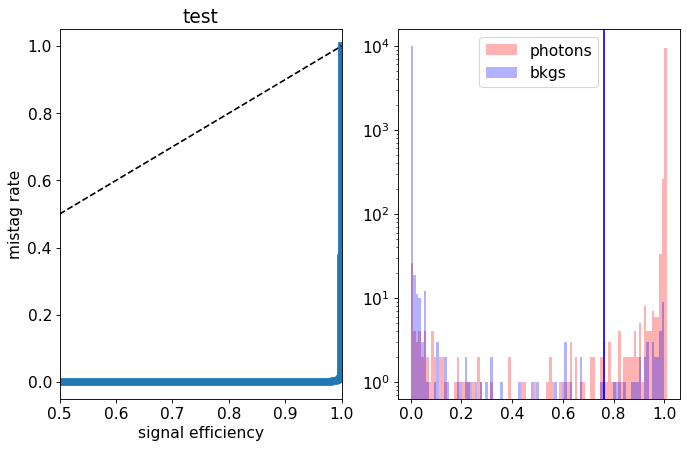

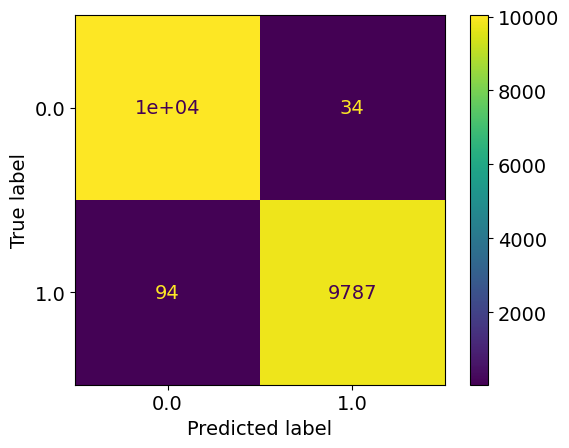

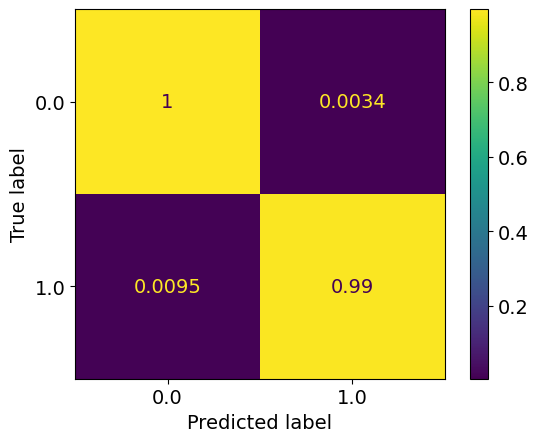

epoch: 290
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008627259068246653
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02885527381851502
test acc: 0.9934847
epoch: 291
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009283551008009637
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.34it/s]


test loss: 0.021559174100676662
test acc: 0.9944369
epoch: 292
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008847101728358904
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.02301235907276243
test acc: 0.99433666
epoch: 293
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009193537438613252
train acc: 0.9968926


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.026185055509867036
test acc: 0.99423647
epoch: 294
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008866540758471776
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.024567039934267728
test acc: 0.9939859
epoch: 295
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008643898880706472
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.025844419977682477
test acc: 0.99373525
epoch: 296
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008802886014876351
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.024457280221480793
test acc: 0.99403596
epoch: 297
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009077509101569294
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.023648598909751267
test acc: 0.99423647
epoch: 298
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008540076983709058
train acc: 0.9971682


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.0247560361509814
test acc: 0.9942866
epoch: 299
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00860222066855942
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.027465628867503256
test acc: 0.9942866


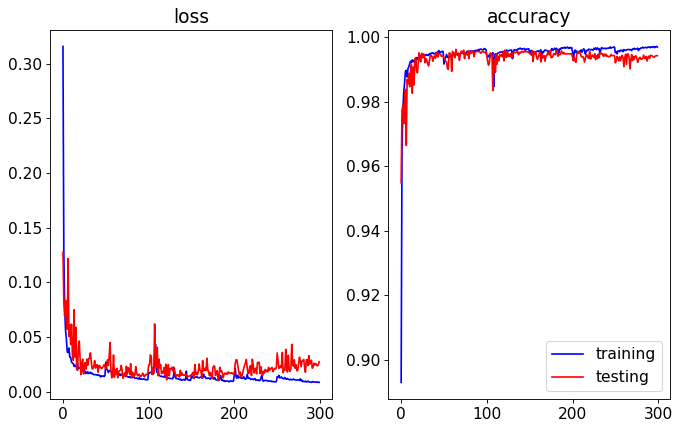

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


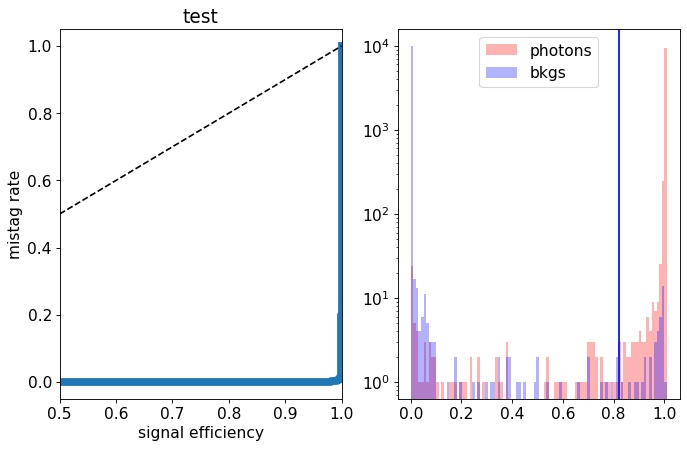

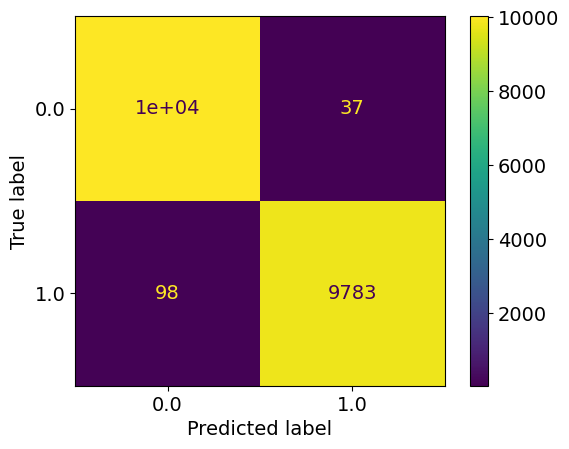

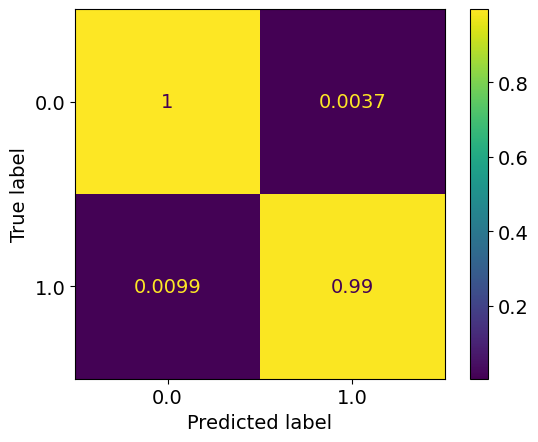

epoch: 300
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.012027916307379743
train acc: 0.99573976


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.03087300671648015
test acc: 0.9932341
epoch: 301
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012544775563230305
train acc: 0.99577737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.018285414190305507
test acc: 0.9941362
epoch: 302
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.01186904564253124
train acc: 0.995815


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.03574255968423506
test acc: 0.9926327
epoch: 303
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010705896869558952
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.027069679817513508
test acc: 0.9932842
epoch: 304
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01230393823753906
train acc: 0.9960029


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.01it/s]


test loss: 0.05056030021103866
test acc: 0.9902772
epoch: 305
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011558966927487514
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.020985176927163538
test acc: 0.99478775
epoch: 306
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011418392139494787
train acc: 0.9959653


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.03103412385098636
test acc: 0.9918308
epoch: 307
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01139632154624459
train acc: 0.99586505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.036645963322371244
test acc: 0.991931
epoch: 308
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011085541513374896
train acc: 0.996241


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.03735760277178248
test acc: 0.9920814
epoch: 309
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.011096252287901355
train acc: 0.9959152


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.026788855164982927
test acc: 0.9924823


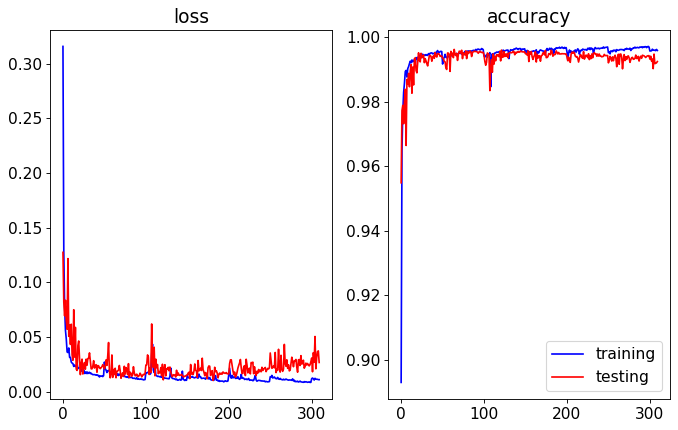

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


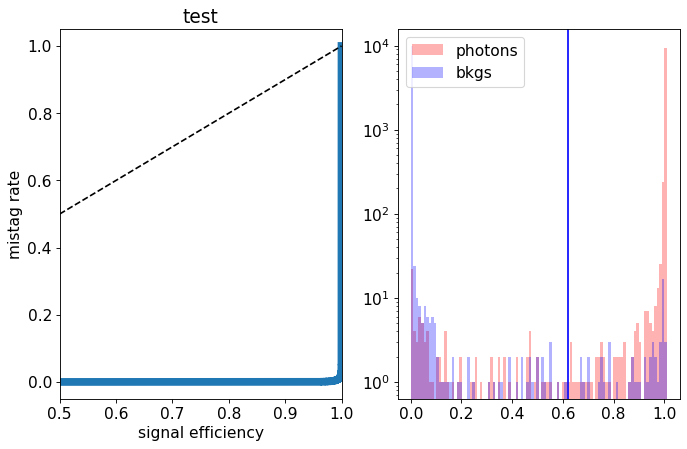

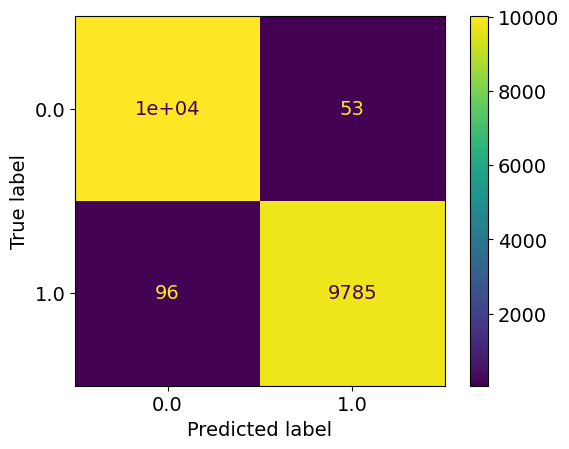

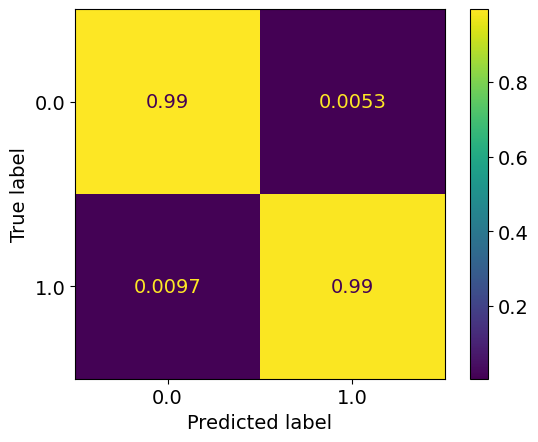

epoch: 310
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010907649425720213
train acc: 0.9959528


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.03385247893097317
test acc: 0.99137974
epoch: 311
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010805878443217006
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.03378817158997716
test acc: 0.9913296
epoch: 312
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011802068146105522
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03559628248844734
test acc: 0.9913296
epoch: 313
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.011349986733047946
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.016748979239149347
test acc: 0.9948379
epoch: 314
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01198413381492024
train acc: 0.99602795


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.59it/s]


test loss: 0.040332793117747366
test acc: 0.99283314
epoch: 315
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.010718594129725513
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.04602261262891047
test acc: 0.9912294
epoch: 316
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011259635274451393
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.033272299645057714
test acc: 0.99253243
epoch: 317
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.011096046848306016
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.0162247049909852
test acc: 0.9951386
epoch: 318
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010446855247562834
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.0298668588819804
test acc: 0.9923821
epoch: 319
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010534094547315973
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.23it/s]


test loss: 0.01900442218859954
test acc: 0.99448705


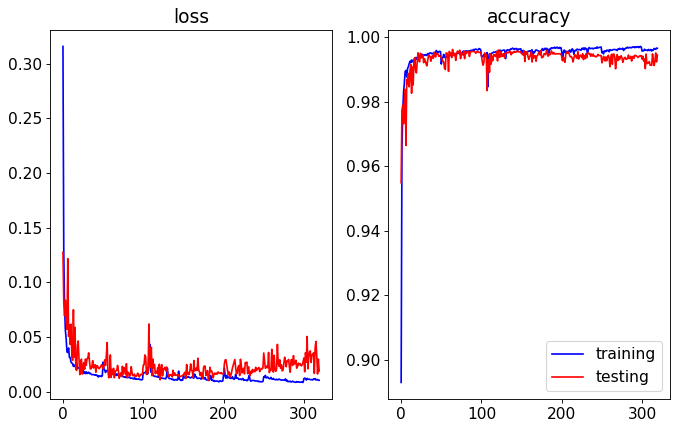

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


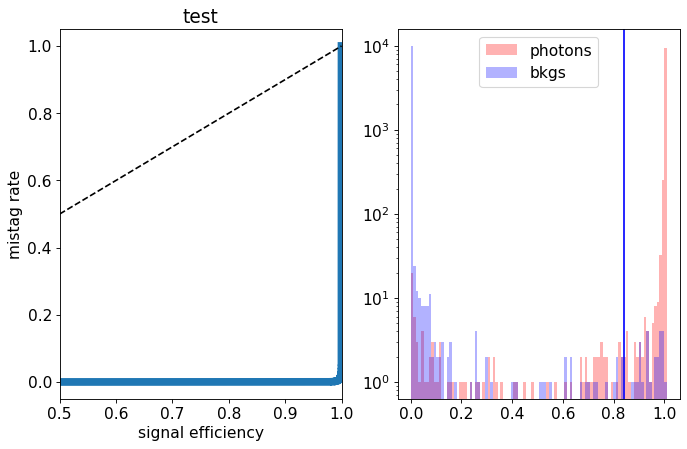

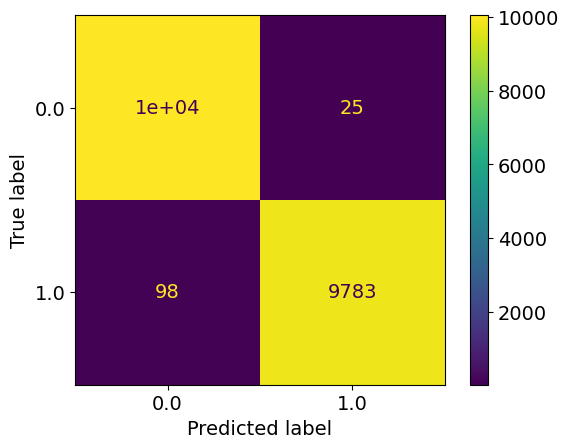

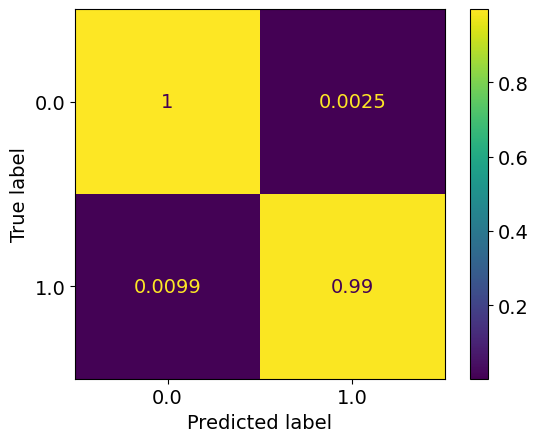

epoch: 320
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010016456407967455
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.02709971500136068
test acc: 0.9930838
epoch: 321
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.35it/s]


train loss: 0.010211329923902722
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.044304808086428026
test acc: 0.9912795
epoch: 322
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010821129629777661
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03212761822814012
test acc: 0.99198115
epoch: 323
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.014661326465889643
train acc: 0.9950757


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.027448927517980337
test acc: 0.9929334
epoch: 324
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.44it/s]


train loss: 0.009842750764062711
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.024621769409243238
test acc: 0.9936852
epoch: 325
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010086451250409387
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.02642626893323134
test acc: 0.9937854
epoch: 326
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.010237916661148419
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03404075185330037
test acc: 0.99148
epoch: 327
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01036706791013269
train acc: 0.9964039


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03278752343099126
test acc: 0.99303365
epoch: 328
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.009510764782664492
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.03785704886896008
test acc: 0.9923821
epoch: 329
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010020898377918986
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.027272602854282013
test acc: 0.99358493


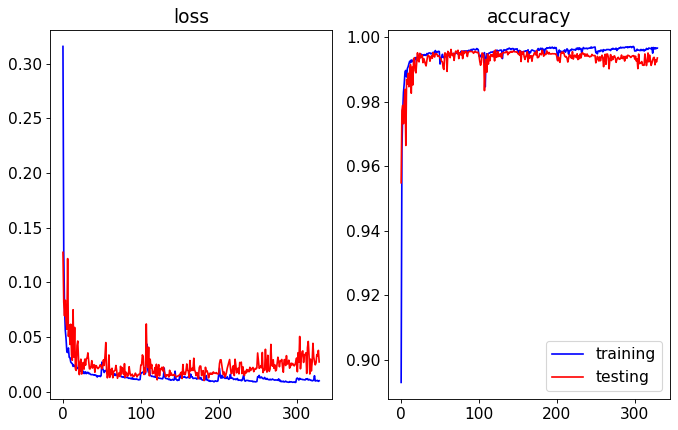

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


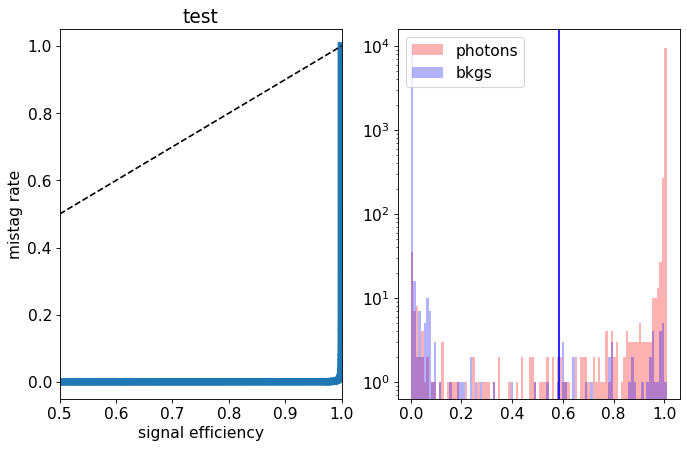

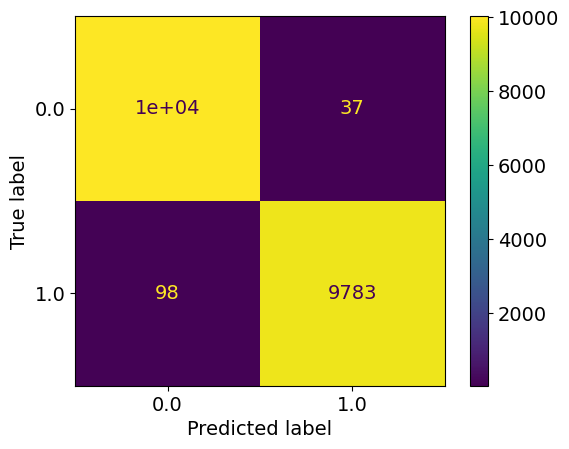

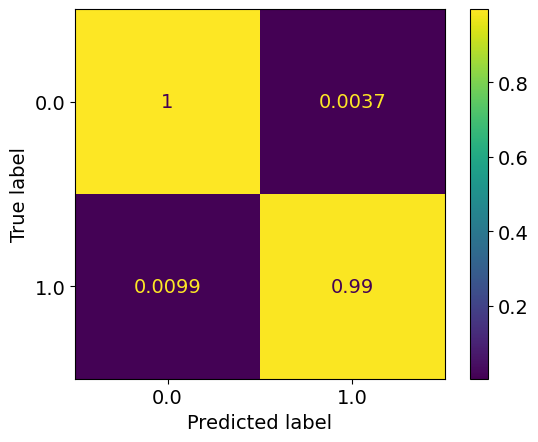

epoch: 330
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.009827376058027183
train acc: 0.9967798


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.02602200285079615
test acc: 0.9932341
epoch: 331
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009520583945034664
train acc: 0.99664193


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.027986146510503365
test acc: 0.9934847
epoch: 332
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.008804034344402918
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.03181675664210856
test acc: 0.99273294
epoch: 333
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.008856068339375623
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.43it/s]


test loss: 0.033063008901937044
test acc: 0.99273294
epoch: 334
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008813455639191583
train acc: 0.99699277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.06it/s]


test loss: 0.028578658887828866
test acc: 0.993184
epoch: 335
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008760385971377965
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.0338113660348908
test acc: 0.9926828
epoch: 336
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.009695740290266965
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.47it/s]


test loss: 0.029052733477917227
test acc: 0.9932341
epoch: 337
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008718874865788017
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.50it/s]


test loss: 0.03869944560231969
test acc: 0.99243224
epoch: 338
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.009038930572808282
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.03199790157925557
test acc: 0.9933845
epoch: 339
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.36it/s]


train loss: 0.008386541149463226
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03756198030211689
test acc: 0.99283314


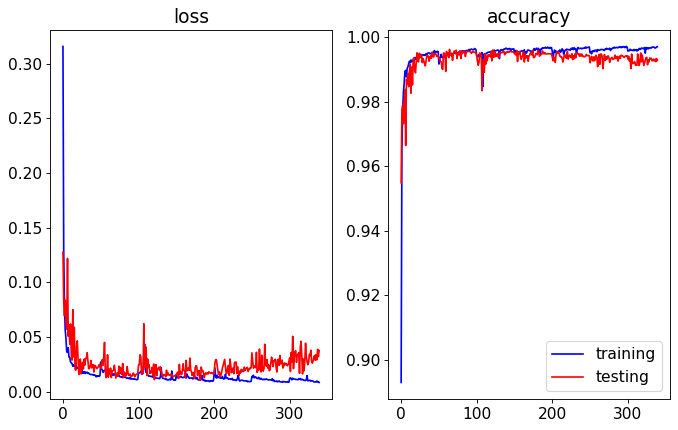

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


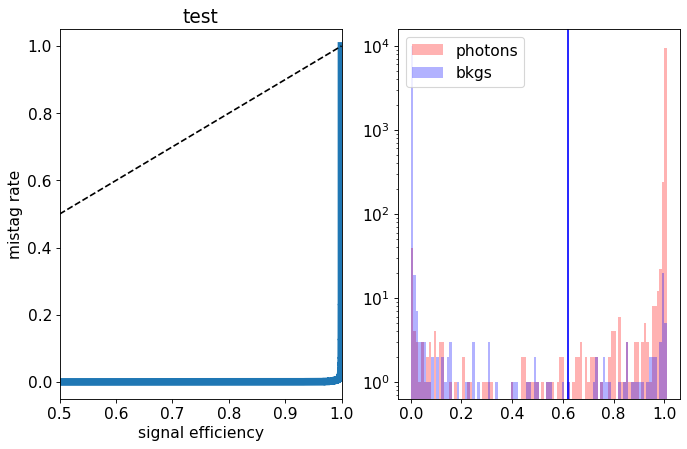

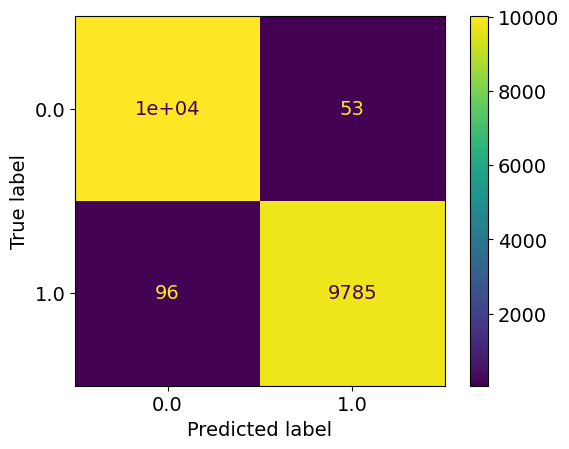

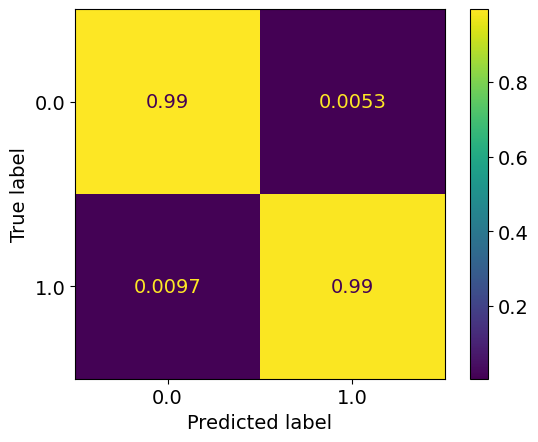

epoch: 340
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.00853032521630507
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.03157192723130506
test acc: 0.9932842
epoch: 341
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.00858748865352001
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.54it/s]


test loss: 0.03461426483708612
test acc: 0.99278307
epoch: 342
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.00814624813451633
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.21it/s]


test loss: 0.034298887332517874
test acc: 0.99278307
epoch: 343
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.45it/s]


train loss: 0.008620247734239769
train acc: 0.99701786


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03818405049798243
test acc: 0.99273294
epoch: 344
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.68it/s]


train loss: 0.008128340189243424
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03503989001268672
test acc: 0.99278307
epoch: 345
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008558412747537544
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.03457800190046649
test acc: 0.9929334
epoch: 346
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008314370963571084
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.033487419402637685
test acc: 0.99278307
epoch: 347
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008017501244521283
train acc: 0.9973311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.66it/s]


test loss: 0.033305737754905265
test acc: 0.99273294
epoch: 348
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00866514662619065
train acc: 0.99696773


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.03313091897186549
test acc: 0.99273294
epoch: 349
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008225145783629824
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03385495857390411
test acc: 0.99273294


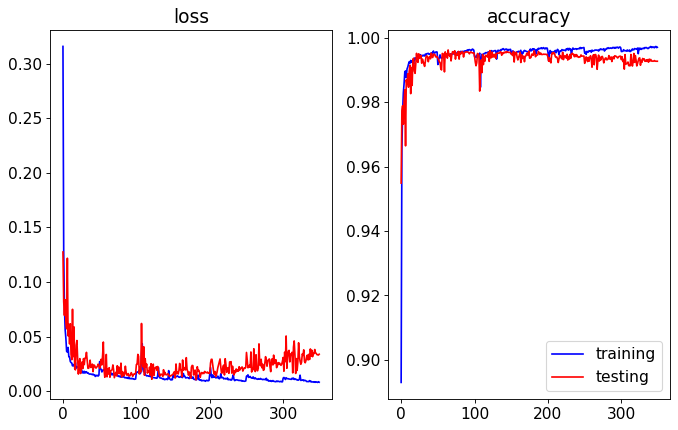

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.09it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


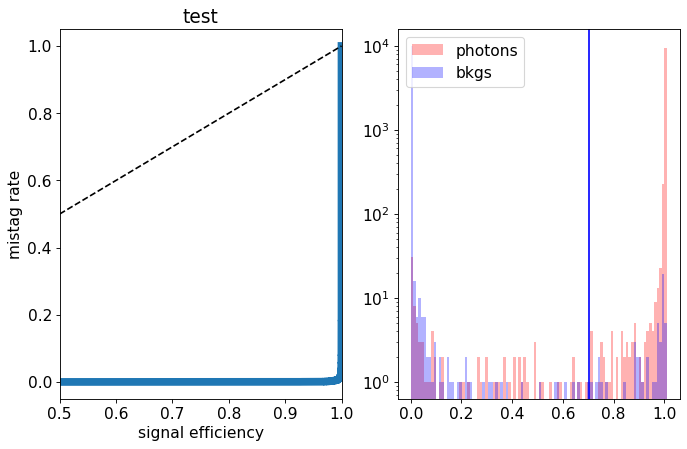

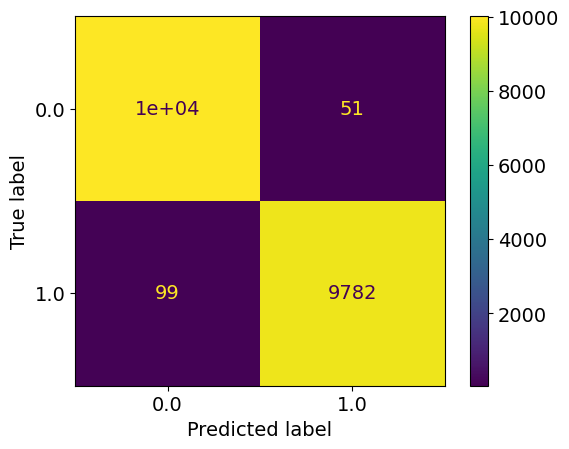

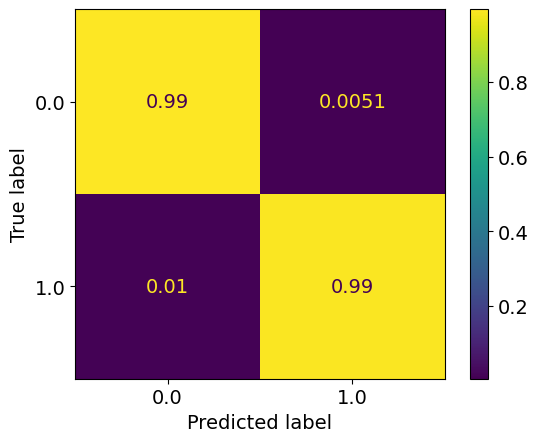

epoch: 350
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011890742822234004
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.024601160630802896
test acc: 0.99228185
epoch: 351
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011910415539274702
train acc: 0.9958275


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.99it/s]


test loss: 0.07373681691858698
test acc: 0.98887384
epoch: 352
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011864381249813335
train acc: 0.99621594


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.020868055084172416
test acc: 0.9951887
epoch: 353
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.01447555422782898
train acc: 0.99527615


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.03145561971777009
test acc: 0.9917807
epoch: 354
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010848555719511845
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.043393665517214686
test acc: 0.9926327
epoch: 355
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010800585108148908
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.04316422660999438
test acc: 0.9910289
epoch: 356
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.011078755136704378
train acc: 0.99619085


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.04303173821672852
test acc: 0.9922317
epoch: 357
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.012043290420368731
train acc: 0.9958776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03009373530992033
test acc: 0.9933845
epoch: 358
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.011096902690965112
train acc: 0.99631613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.02335751547669882
test acc: 0.9939859
epoch: 359
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011279136410618111
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.030712827971643385
test acc: 0.99273294


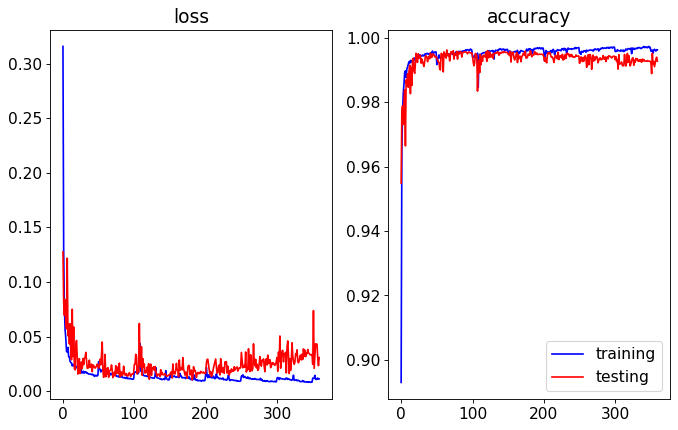

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


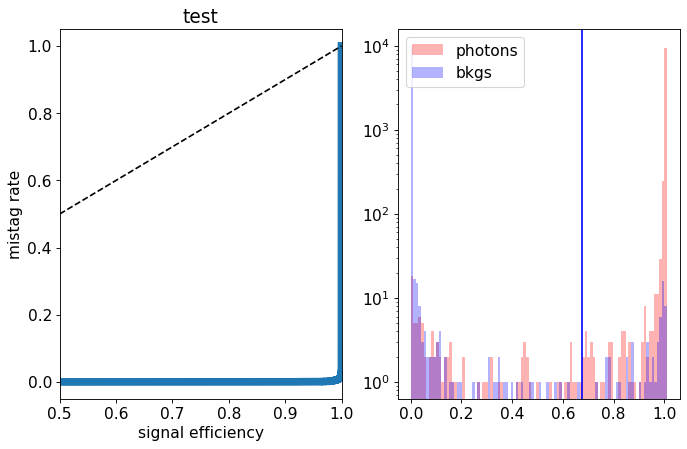

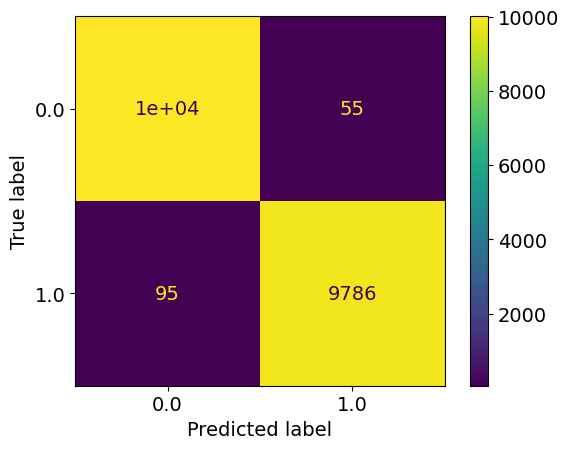

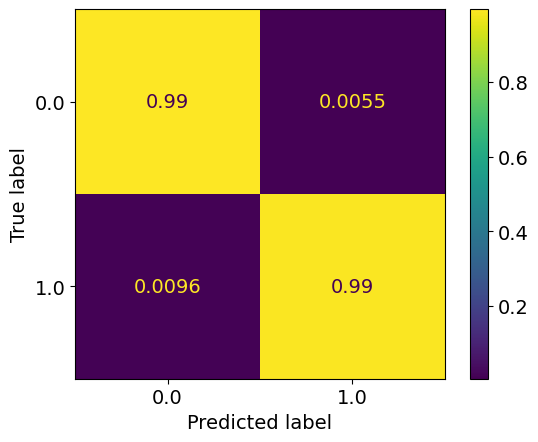

epoch: 360
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010438254996161186
train acc: 0.9963788


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.040575690981795025
test acc: 0.9917807
epoch: 361
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01073185557112056
train acc: 0.9964164


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03699511296444518
test acc: 0.9920814
epoch: 362
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009815798188464581
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.04806742008076981
test acc: 0.99112916
epoch: 363
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010842593683888997
train acc: 0.9961282


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.03820503385984065
test acc: 0.99283314
epoch: 364
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010965668736688128
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.95it/s]


test loss: 0.021111249906586155
test acc: 0.9936852
epoch: 365
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010945203522943071
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.023360690023229623
test acc: 0.9938355
epoch: 366
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009827659763361035
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.020018827919985223
test acc: 0.99433666
epoch: 367
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010332716718389137
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.06109603839542936
test acc: 0.99022704
epoch: 368
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010433964733998274
train acc: 0.99649155


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.030067319824250743
test acc: 0.9929835
epoch: 369
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.01029295696001222
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.04364238358924494
test acc: 0.9917807


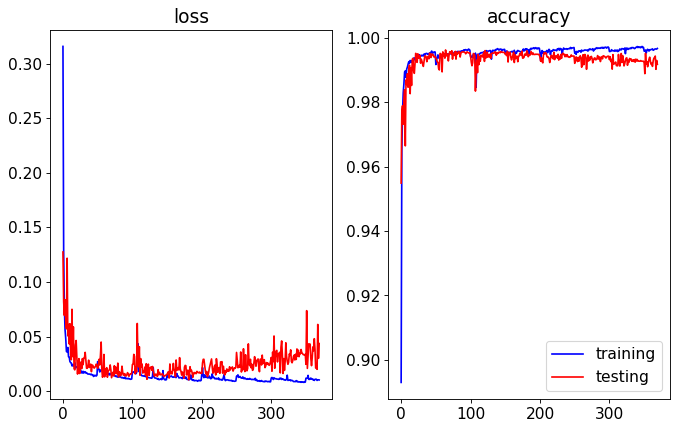

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


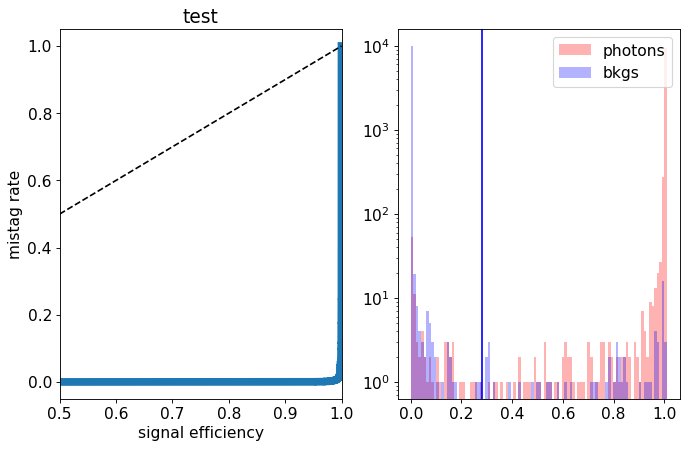

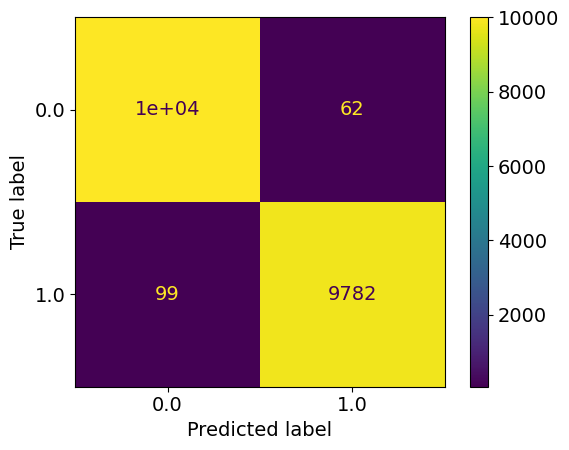

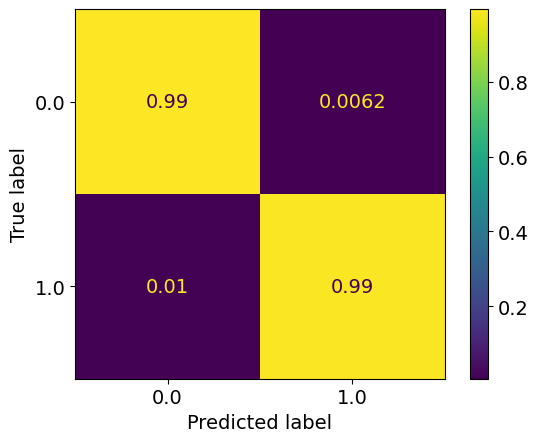

epoch: 370
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010349827520584049
train acc: 0.9963412


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.07373419283505749
test acc: 0.98857313
epoch: 371
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010125887009922029
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.96it/s]


test loss: 0.03150822873548725
test acc: 0.99243224
epoch: 372
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009430096637570115
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.03654443063115811
test acc: 0.99278307
epoch: 373
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01147777528707077
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.02370555875570383
test acc: 0.99358493
epoch: 374
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01222455260168358
train acc: 0.99605304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.0193881388507126
test acc: 0.9945372
epoch: 375
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.009662284736547387
train acc: 0.99681735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.027094044839031994
test acc: 0.9935348
epoch: 376
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009477603416381675
train acc: 0.9967672


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.040154363090336764
test acc: 0.9921816
epoch: 377
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010127290300898942
train acc: 0.9966294


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.029125225815839845
test acc: 0.9932341
epoch: 378
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01006739290840333
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.034592460991595596
test acc: 0.9926828
epoch: 379
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.01002643330616932
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.02424748407622032
test acc: 0.99423647


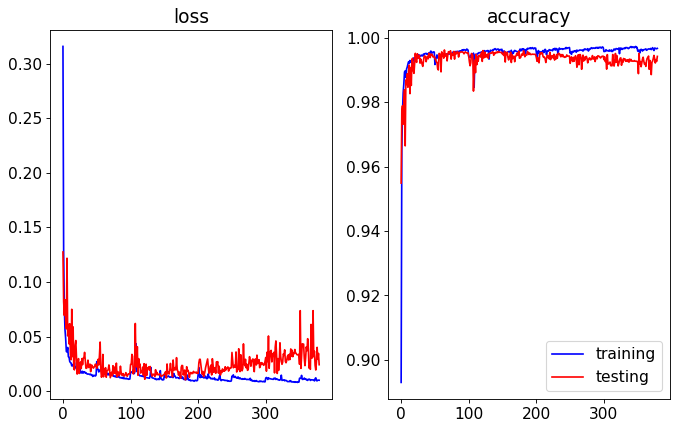

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


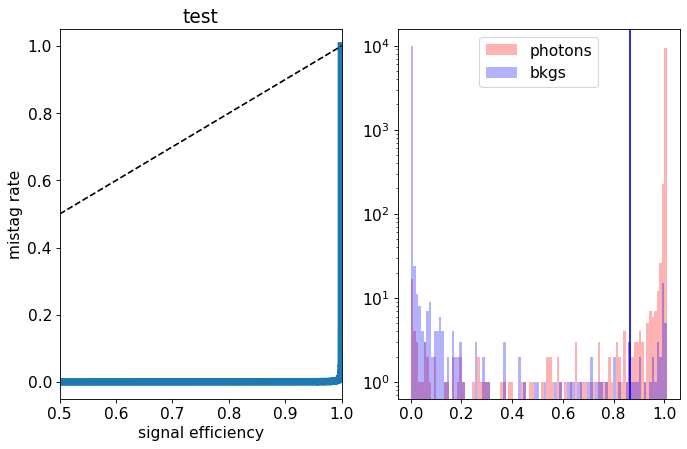

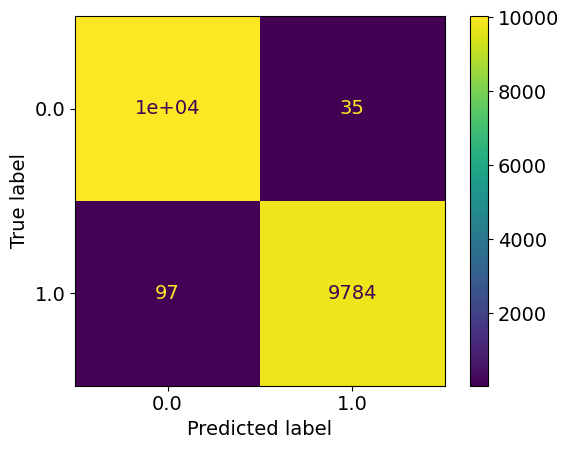

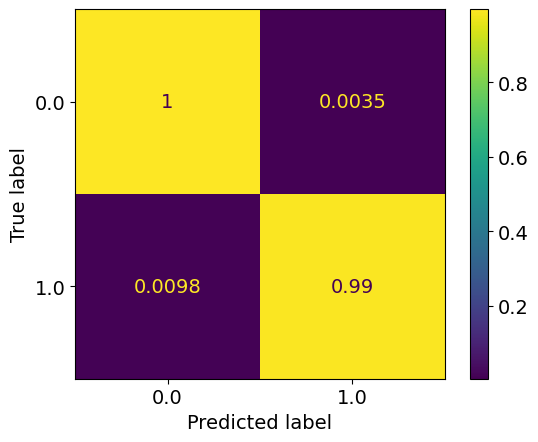

epoch: 380
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008839275669471583
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.04626269179725034
test acc: 0.9912795
epoch: 381
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00913188232749547
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00,  9.95it/s]


test loss: 0.0411005761638722
test acc: 0.9915802
epoch: 382
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008771201427750262
train acc: 0.9969301


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.03853449254871949
test acc: 0.9923821
epoch: 383
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00884690010179974
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.027512302923509303
test acc: 0.99373525
epoch: 384
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008718234364381199
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.03905142630751738
test acc: 0.9923821
epoch: 385
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00875723287275045
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.04819582528708612
test acc: 0.99142987
epoch: 386
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.00839764158541557
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.030393537195563754
test acc: 0.99363506
epoch: 387
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008793929227169374
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.041000293506145036
test acc: 0.9921816
epoch: 388
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008064090695628285
train acc: 0.99713063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.03393049775074948
test acc: 0.9932341
epoch: 389
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008109434269728686
train acc: 0.99728096


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.22it/s]


test loss: 0.03908618917664759
test acc: 0.9926327


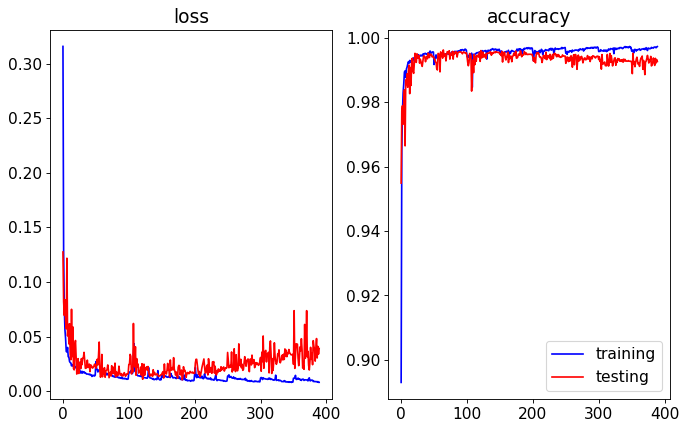

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


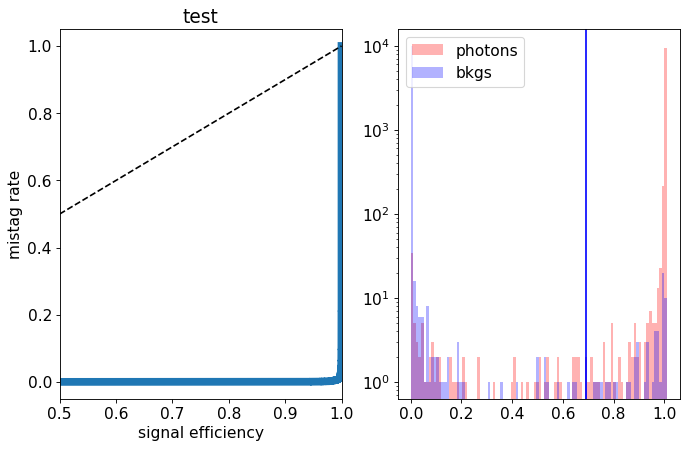

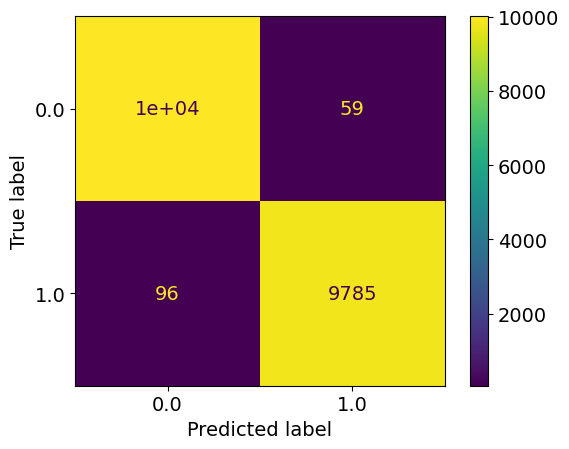

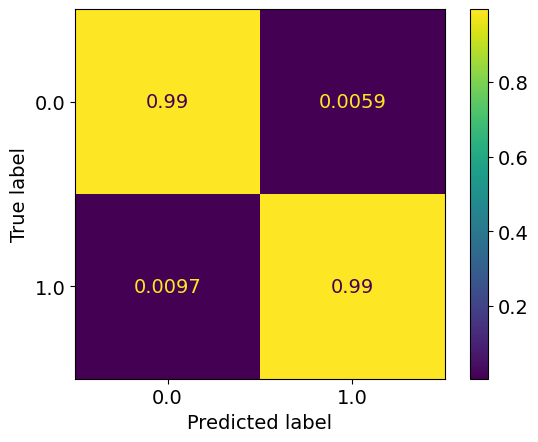

epoch: 390
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.008166855283766991
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.03521049558185041
test acc: 0.99303365
epoch: 391
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.007993833716148625
train acc: 0.9972058


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.03802339116908329
test acc: 0.99253243
epoch: 392
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.008299634371459393
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.03090279984890538
test acc: 0.99343455
epoch: 393
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008400234828934742
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.03128654327627052
test acc: 0.9932842
epoch: 394
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.00841874967906068
train acc: 0.9973562


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.03337549959884628
test acc: 0.99333435
epoch: 395
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008096530079574765
train acc: 0.9974188


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.0320191907162285
test acc: 0.993184
epoch: 396
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.007927986684297872
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.03182979772271424
test acc: 0.9930838
epoch: 397
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008265512286070318
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.03405649903202977
test acc: 0.9930838
epoch: 398
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009210761594360194
train acc: 0.9973311


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.036184334937441984
test acc: 0.993184
epoch: 399
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.0084071016145884
train acc: 0.99710554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.034794521223589336
test acc: 0.9932842


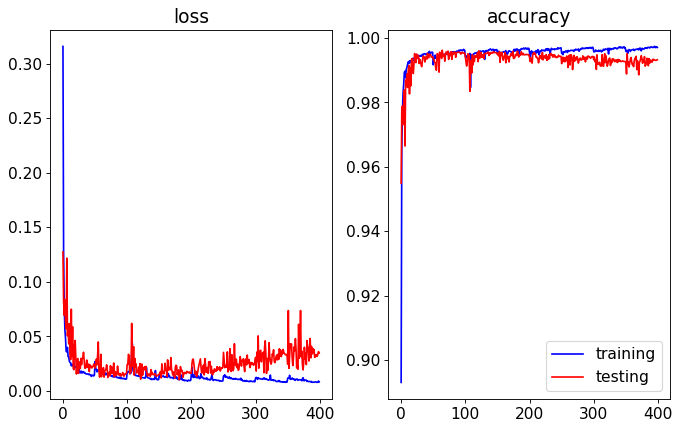

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


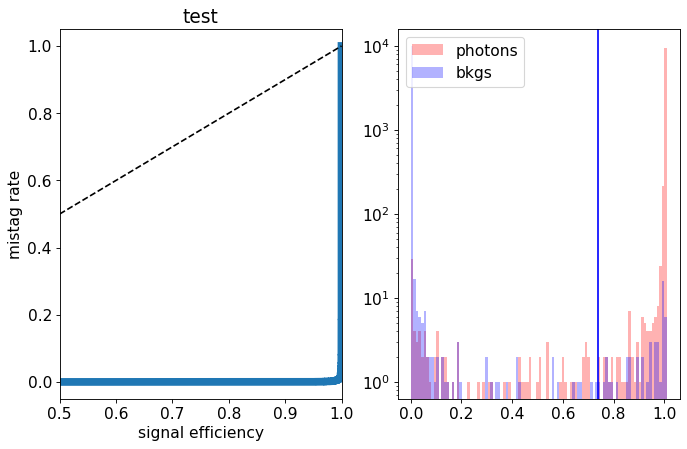

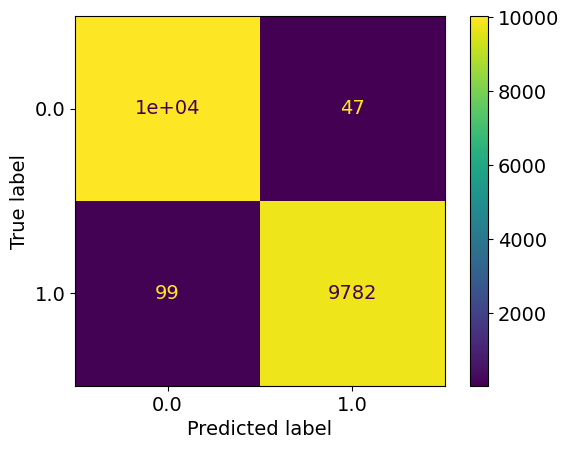

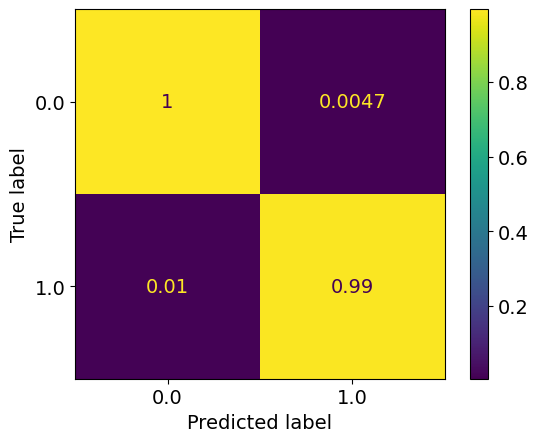

epoch: 400
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.67it/s]


train loss: 0.011923959393813553
train acc: 0.9959778


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.029691021909992045
test acc: 0.9934847
epoch: 401
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.012652846220723758
train acc: 0.9959904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.051009586094604695
test acc: 0.9895755
epoch: 402
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011322915929790114
train acc: 0.9961533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.0616193142007379
test acc: 0.9878214
epoch: 403
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.01150292049869982
train acc: 0.9960154


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.04336708006175125
test acc: 0.9901268
epoch: 404
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.010945257674746299
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.025774351629318997
test acc: 0.9932341
epoch: 405
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.010708546380997245
train acc: 0.99622846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.03875306365080178
test acc: 0.990628
epoch: 406
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.011155374144002406
train acc: 0.99620336


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.03189227382159408
test acc: 0.9924823
epoch: 407
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.01042034264380041
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.0476292846724391
test acc: 0.9913296
epoch: 408
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.01087194776037402
train acc: 0.9963287


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.058588311240515285
test acc: 0.9912795
epoch: 409
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.010794499769994517
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.24it/s]


test loss: 0.02812670233234873
test acc: 0.99418634


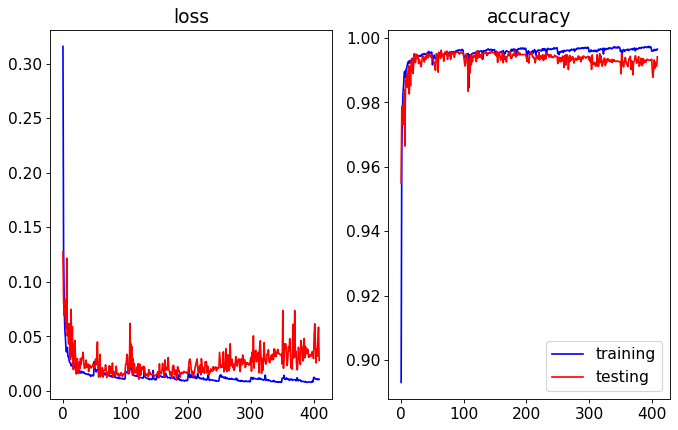

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


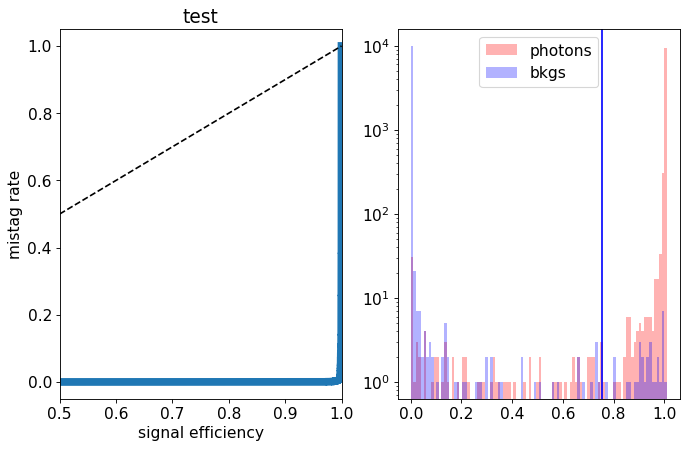

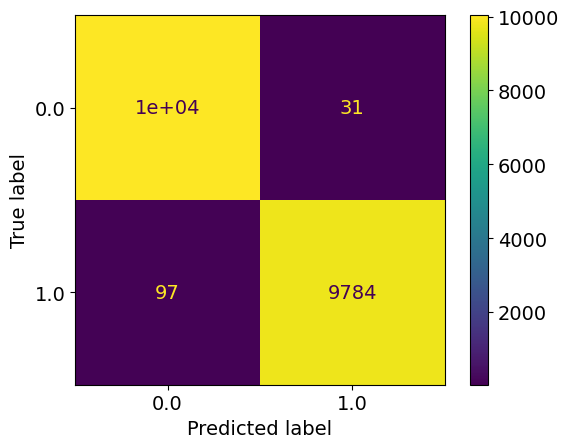

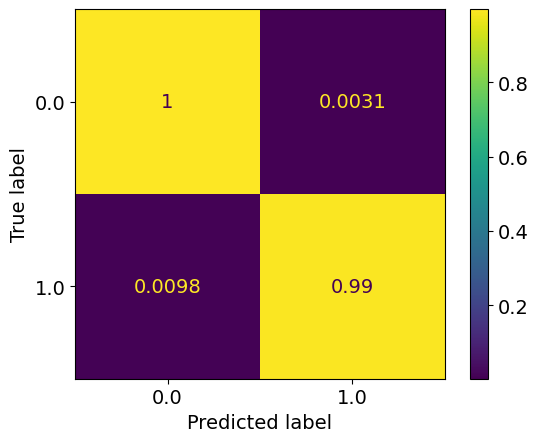

epoch: 410
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.60it/s]


train loss: 0.01073556604995844
train acc: 0.9962911


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.017739314063767192
test acc: 0.9946875
epoch: 411
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.36it/s]


train loss: 0.010401360806357464
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.031062738612972145
test acc: 0.9922317
epoch: 412
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.010122097183481326
train acc: 0.9964665


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.022276572087374755
test acc: 0.99343455
epoch: 413
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010465444446260757
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.01703881353537059
test acc: 0.99423647
epoch: 414
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010669082212114435
train acc: 0.996454


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.024273289531907615
test acc: 0.99433666
epoch: 415
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010238186627628156
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.030758038272752482
test acc: 0.99358493
epoch: 416
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010157583572951956
train acc: 0.99652916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.0495943528103988
test acc: 0.9911793
epoch: 417
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009965320898959702
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.02850829148391152
test acc: 0.9935348
epoch: 418
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009844447988252254
train acc: 0.99655426


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.029801590510032838
test acc: 0.99278307
epoch: 419
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.011159741478483887
train acc: 0.99636626


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.31it/s]


test loss: 0.04541175198905608
test acc: 0.99107903


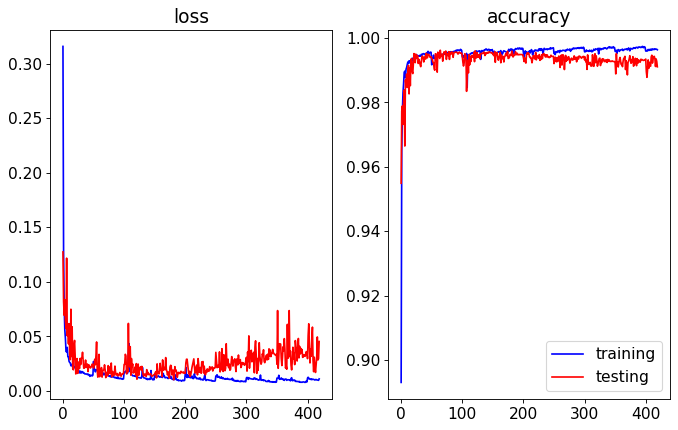

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


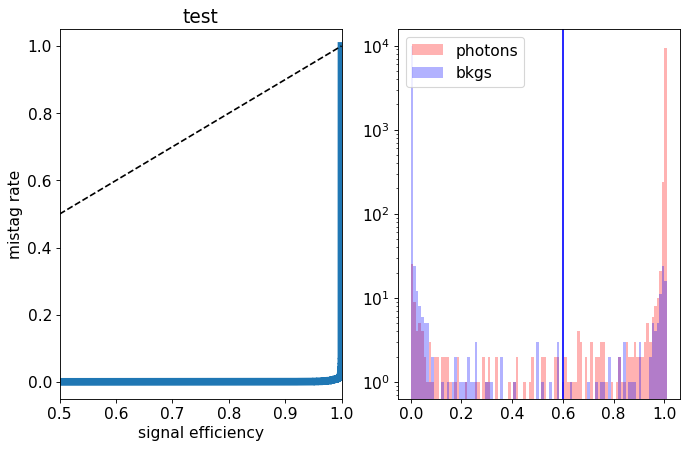

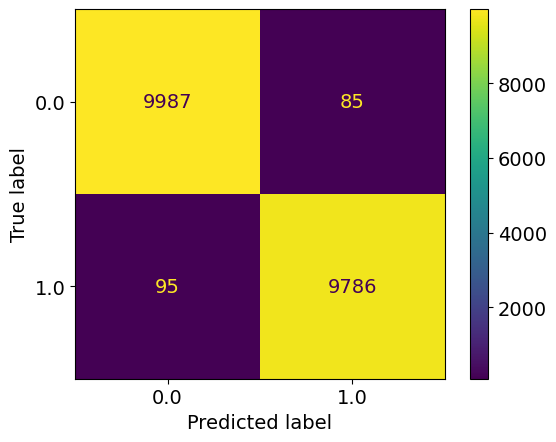

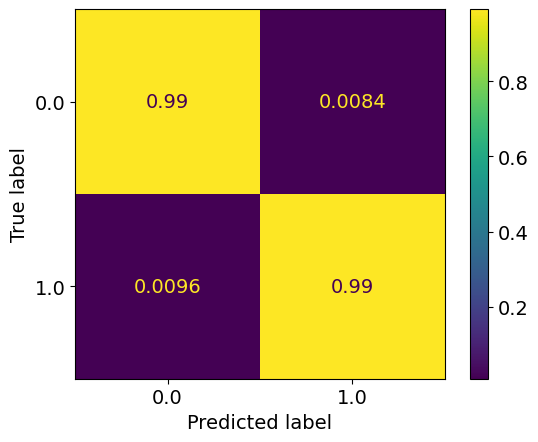

epoch: 420
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.38it/s]


train loss: 0.00965339950580664
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.05401125142131658
test acc: 0.9910289
epoch: 421
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008946837912961865
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.33it/s]


test loss: 0.02861568093409433
test acc: 0.99403596
epoch: 422
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.009463991721348528
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.20it/s]


test loss: 0.03505920540705761
test acc: 0.9932842
epoch: 423
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.010933566272932925
train acc: 0.9967422


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.0377776187241954
test acc: 0.99278307
epoch: 424
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.01564667172688268
train acc: 0.9948877


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.19it/s]


test loss: 0.03488820049952825
test acc: 0.99258256
epoch: 425
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.0088380082784509
train acc: 0.9970304


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.038045573294820154
test acc: 0.99253243
epoch: 426
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009558376751454543
train acc: 0.9965041


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03505929926519885
test acc: 0.992332
epoch: 427
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.014341002540860964
train acc: 0.99667954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.25it/s]


test loss: 0.059429490034851956
test acc: 0.9888237
epoch: 428
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.016086700973587473
train acc: 0.9950005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.03174058536944144
test acc: 0.9918308
epoch: 429
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010163738834715115
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.0374074535416987
test acc: 0.992332


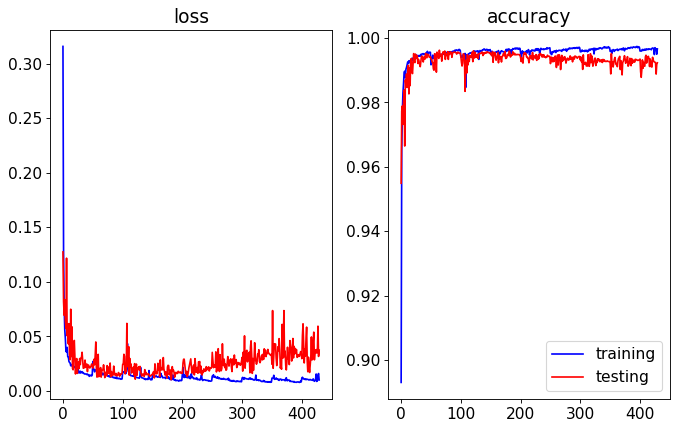

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


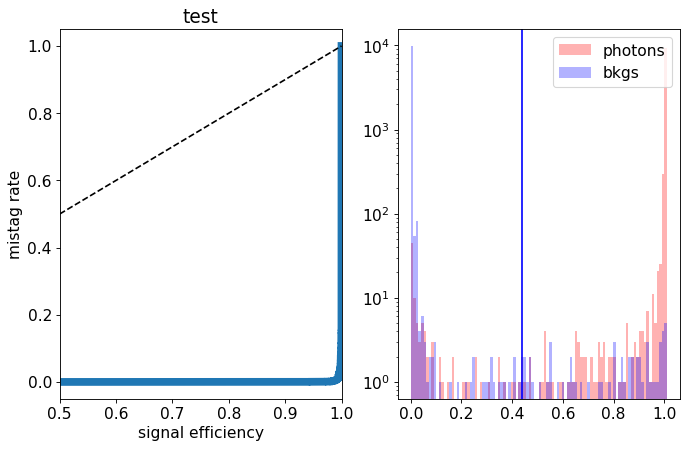

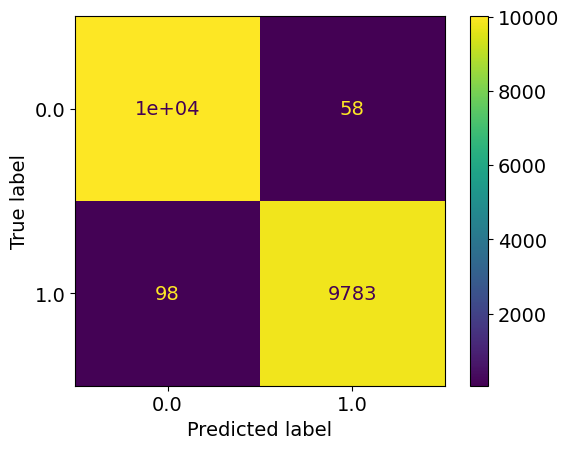

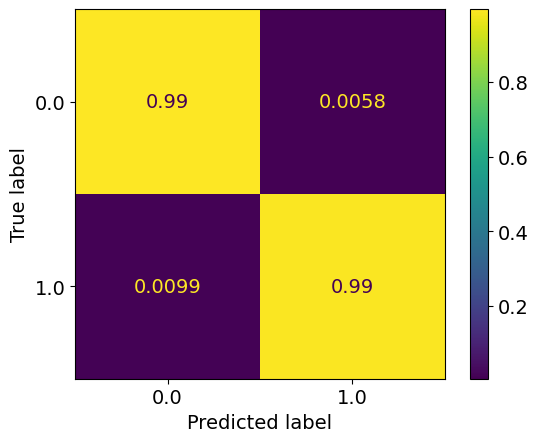

epoch: 430
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.009388638468313296
train acc: 0.99685496


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.61it/s]


test loss: 0.03058204902952318
test acc: 0.99278307
epoch: 431
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.33it/s]


train loss: 0.009495640544248172
train acc: 0.9967547


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.025827135140870643
test acc: 0.99358493
epoch: 432
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009010780093050735
train acc: 0.9969051


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.031004771905239013
test acc: 0.99343455
epoch: 433
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.00902852406650356
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.03272521326674477
test acc: 0.99278307
epoch: 434
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.62it/s]


train loss: 0.008201197806171415
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.37it/s]


test loss: 0.03125027349383077
test acc: 0.99373525
epoch: 435
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008318245197633774
train acc: 0.99729353


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.030470569794381258
test acc: 0.9926828
epoch: 436
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008513452565890854
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.03439551584511612
test acc: 0.9929334
epoch: 437
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008585453614655104
train acc: 0.9972559


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.36it/s]


test loss: 0.02922705406158724
test acc: 0.9932341
epoch: 438
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.008896285915941021
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.029817229520310375
test acc: 0.993184
epoch: 439
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008658949933414446
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.34it/s]


test loss: 0.027502396626326062
test acc: 0.99358493


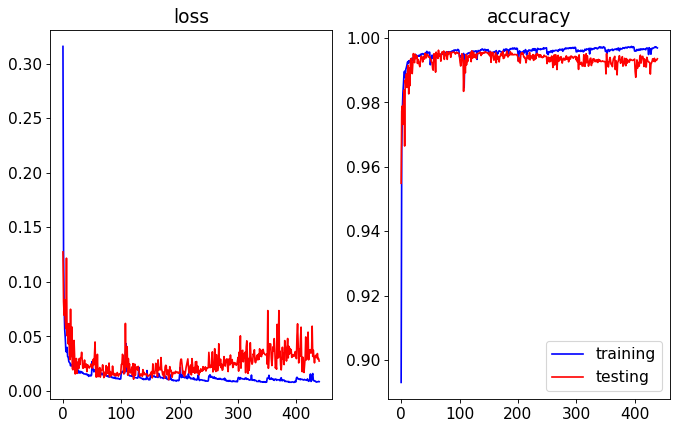

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.51it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


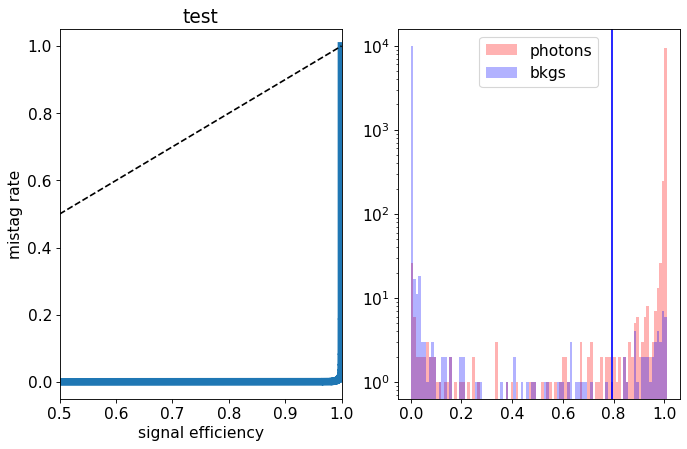

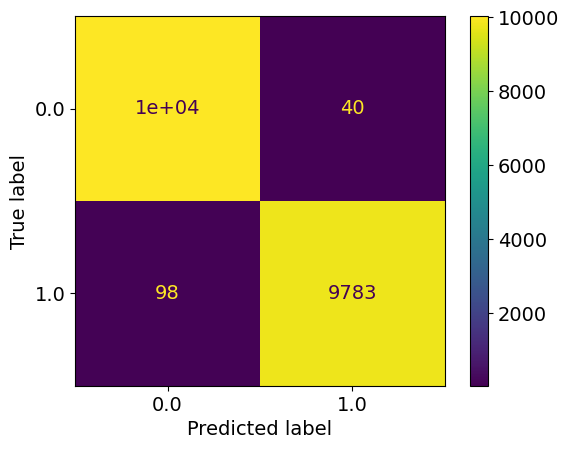

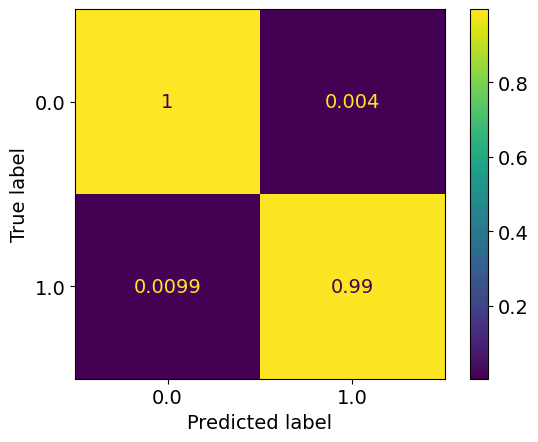

epoch: 440
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008378095076933725
train acc: 0.9969552


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.46it/s]


test loss: 0.030935448549879604
test acc: 0.993184
epoch: 441
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008310244339585172
train acc: 0.9971933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.17it/s]


test loss: 0.0315160622327205
test acc: 0.9930838
epoch: 442
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00900155001293013
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.02908533056239214
test acc: 0.9933845
epoch: 443
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008346548912817553
train acc: 0.9970805


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.23it/s]


test loss: 0.030266271746607825
test acc: 0.99313384
epoch: 444
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.008603275297507174
train acc: 0.99718076


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.029744305202792233
test acc: 0.99333435
epoch: 445
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008192263026252639
train acc: 0.99730605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.030033265966374206
test acc: 0.9933845
epoch: 446
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.008317929674973782
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.0298188178361777
test acc: 0.9933845
epoch: 447
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.008332043945003208
train acc: 0.99731857


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.32it/s]


test loss: 0.029528496480505803
test acc: 0.9933845
epoch: 448
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008061759730385823
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.029362400307410795
test acc: 0.9933845
epoch: 449
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.008245837160146364
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.02938002801281126
test acc: 0.9933845


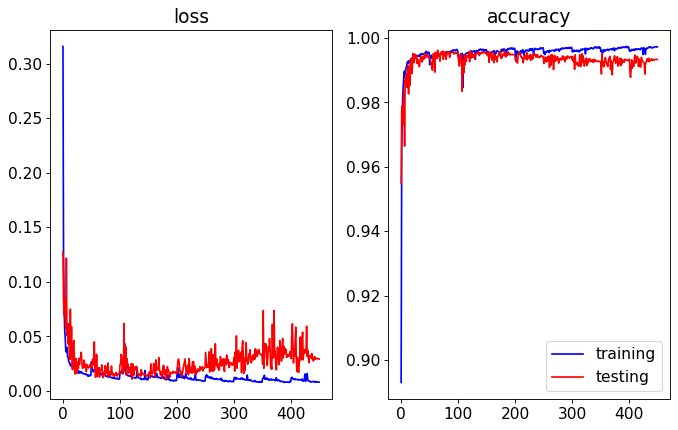

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


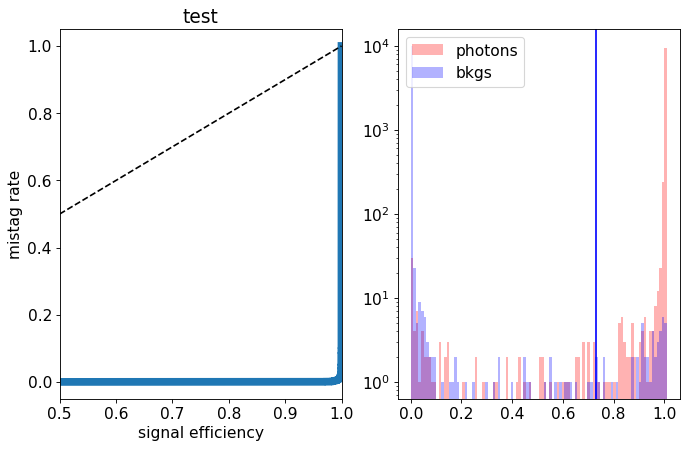

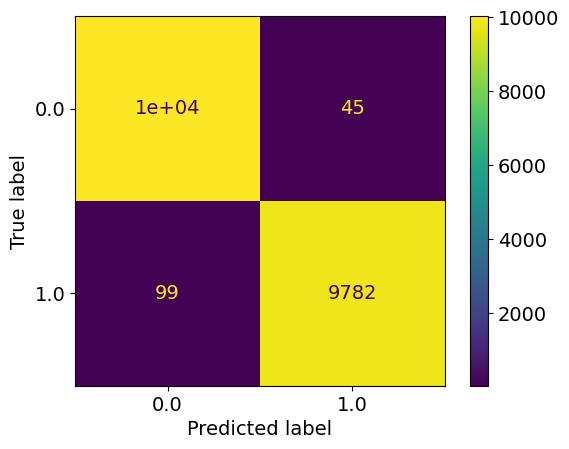

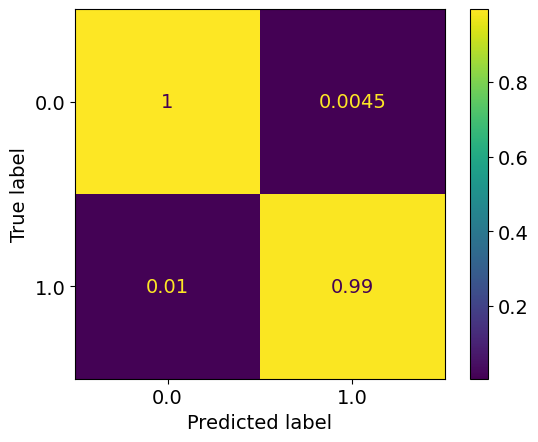

epoch: 450
Learning rate: 5.4965494655778717e-11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.009615256142982372
train acc: 0.9969176


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.05308288399999797
test acc: 0.99002653
epoch: 451
Learning rate: 0.0009990280304188672


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.011252338950237287
train acc: 0.9961658


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.29it/s]


test loss: 0.021587059155161327
test acc: 0.9939859
epoch: 452
Learning rate: 0.0009960866801513866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010549166688192531
train acc: 0.9965668


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.020662295255426538
test acc: 0.99433666
epoch: 453
Learning rate: 0.0009911875023977945


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009946046517849128
train acc: 0.99665445


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.026327889450305307
test acc: 0.9930838
epoch: 454
Learning rate: 0.0009843498319744624


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.010085053144217426
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.30it/s]


test loss: 0.03213788587002936
test acc: 0.9932842
epoch: 455
Learning rate: 0.0009756006540427171


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009936887760465883
train acc: 0.99647903


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.28it/s]


test loss: 0.02925048498710727
test acc: 0.9923821
epoch: 456
Learning rate: 0.000964974497610736


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010176983556611143
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.040407895925454795
test acc: 0.9912294
epoch: 457
Learning rate: 0.0009525132992633268


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.00995124874186073
train acc: 0.9964415


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.24it/s]


test loss: 0.05119996024843525
test acc: 0.9894251
epoch: 458
Learning rate: 0.0009382662376573869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009882068815722417
train acc: 0.9967171


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.04299952722538043
test acc: 0.99142987
epoch: 459
Learning rate: 0.0009222895394362116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.00976403603242183
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.44it/s]


test loss: 0.03263659187702134
test acc: 0.9932341


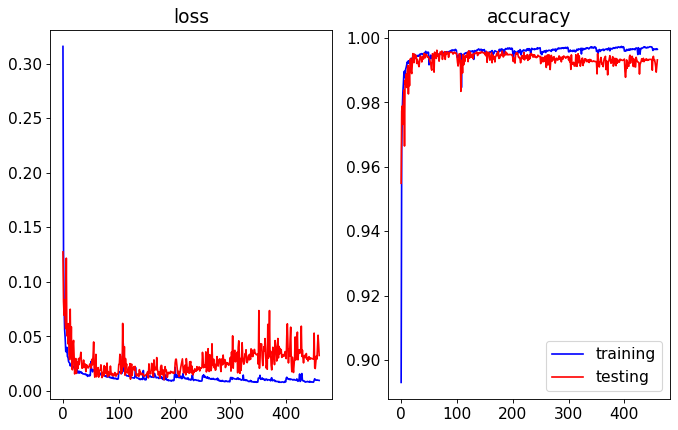

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


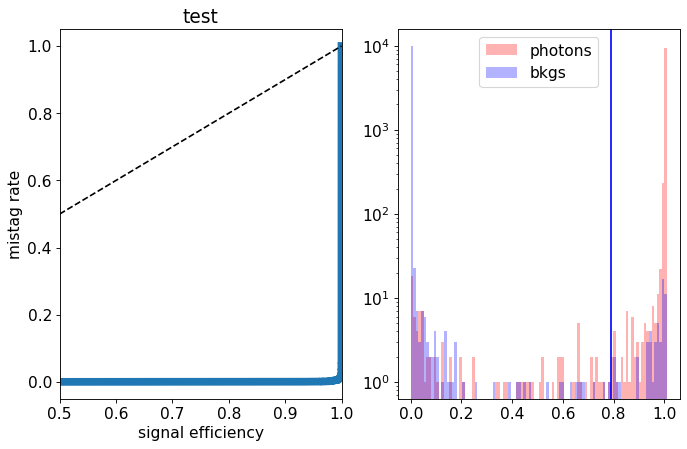

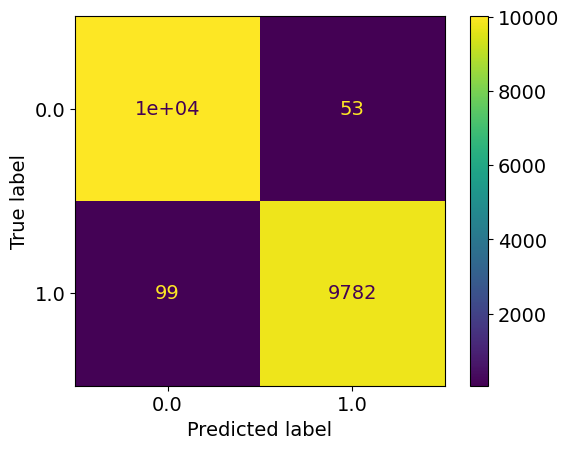

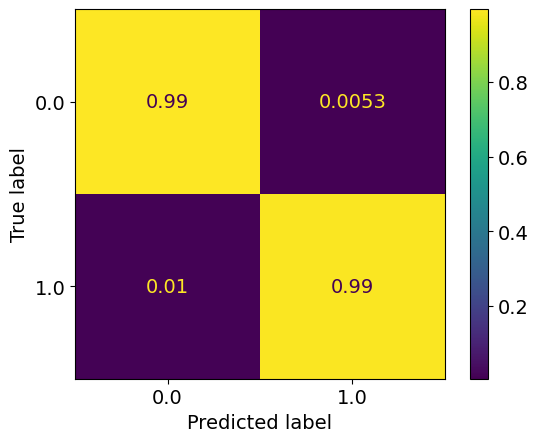

epoch: 460
Learning rate: 0.0009046462573286207


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009763310285486564
train acc: 0.99669206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.36it/s]


test loss: 0.0420174308528658
test acc: 0.99213153
epoch: 461
Learning rate: 0.0008854060213086441


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.010571250694942028
train acc: 0.99626607


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.027298460176954156
test acc: 0.99303365
epoch: 462
Learning rate: 0.0008646447637978249


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010177625326696894
train acc: 0.9965793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.027820417746518028
test acc: 0.99373525
epoch: 463
Learning rate: 0.0008424444199946421


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009802516541116323
train acc: 0.996667


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.35it/s]


test loss: 0.03063636292833561
test acc: 0.9932842
epoch: 464
Learning rate: 0.0008188926045137141


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.00910574118189736
train acc: 0.9967046


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.38it/s]


test loss: 0.042643652078421676
test acc: 0.9918308
epoch: 465
Learning rate: 0.0007940822656109436


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.009983151736269607
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.025605351540862638
test acc: 0.99433666
epoch: 466
Learning rate: 0.0007681113183592139


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.00972394355305176
train acc: 0.9967297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.18it/s]


test loss: 0.042184834862864055
test acc: 0.99168044
epoch: 467
Learning rate: 0.0007410822582223305


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.37it/s]


train loss: 0.009433777851664849
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 13.49it/s]


test loss: 0.04070064660182277
test acc: 0.9917306
epoch: 468
Learning rate: 0.0007131017565522505


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009173296643907565
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.06it/s]


test loss: 0.03961250705041868
test acc: 0.9930838
epoch: 469
Learning rate: 0.0006842802396059906


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.010100449942775182
train acc: 0.9965417


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.01it/s]


test loss: 0.05423646206584047
test acc: 0.98992634


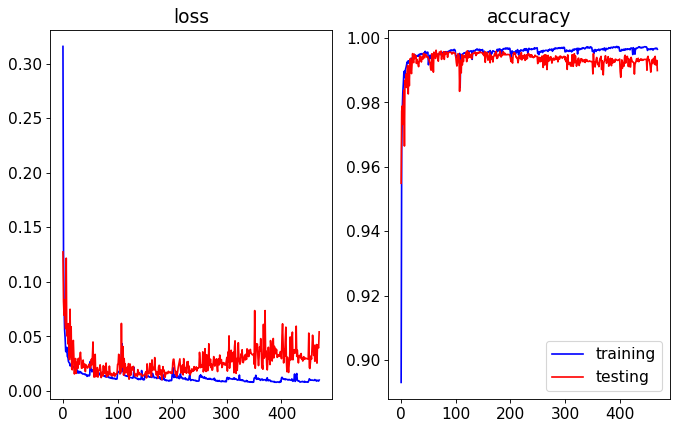

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


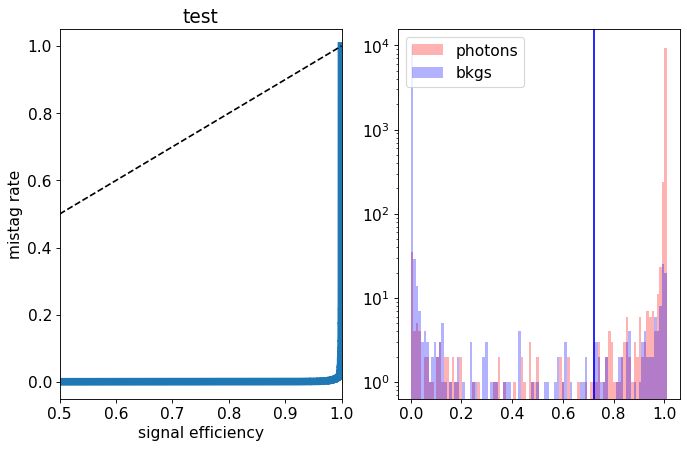

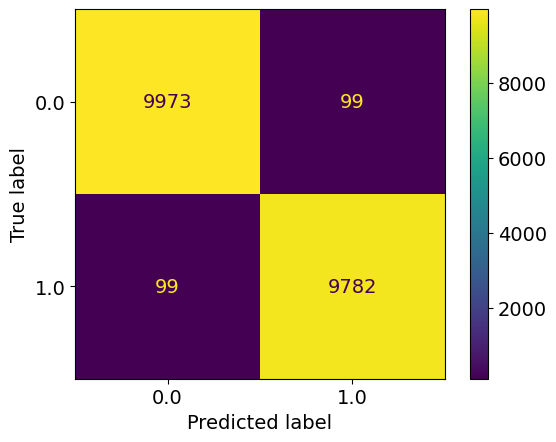

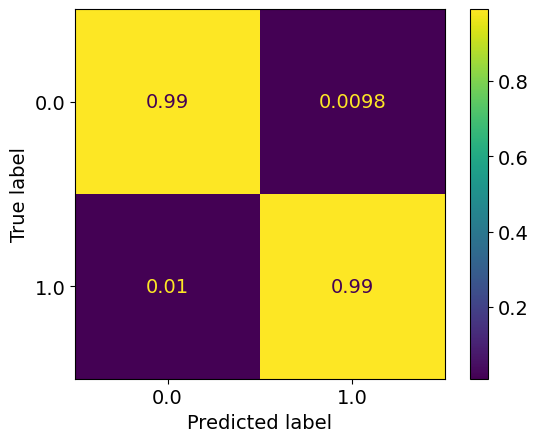

epoch: 470
Learning rate: 0.0006547314527436393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009368384319836267
train acc: 0.9966169


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.03033714706886231
test acc: 0.99358493
epoch: 471
Learning rate: 0.0006245720115273854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00946574990373494
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.01it/s]


test loss: 0.042976574903792315
test acc: 0.99198115
epoch: 472
Learning rate: 0.0005939209414931715


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009136894122694183
train acc: 0.99698025


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.34it/s]


test loss: 0.05711908972657779
test acc: 0.9911793
epoch: 473
Learning rate: 0.0005628992084112805


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.009100659015421658
train acc: 0.9968675


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.042943811393984906
test acc: 0.9917807
epoch: 474
Learning rate: 0.0005316292408897053


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.008851058463176796
train acc: 0.99684244


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.035086065006052033
test acc: 0.99288327
epoch: 475
Learning rate: 0.0005002344472043639


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009087123637588923
train acc: 0.99682987


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.05795784009730115
test acc: 0.9893249
epoch: 476
Learning rate: 0.0004688387282630159


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.008807777445218195
train acc: 0.99680483


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.044040876742014116
test acc: 0.9926327
epoch: 477
Learning rate: 0.0004375659886249827


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009158119499780602
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.04718551019151859
test acc: 0.9915301
epoch: 478
Learning rate: 0.00040653964750646005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.40it/s]


train loss: 0.008391367857962987
train acc: 0.99694264


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.48it/s]


test loss: 0.049562289954765755
test acc: 0.9916303
epoch: 479
Learning rate: 0.00037588215170125596


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009728570503474617
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.044003246592798376
test acc: 0.9915301


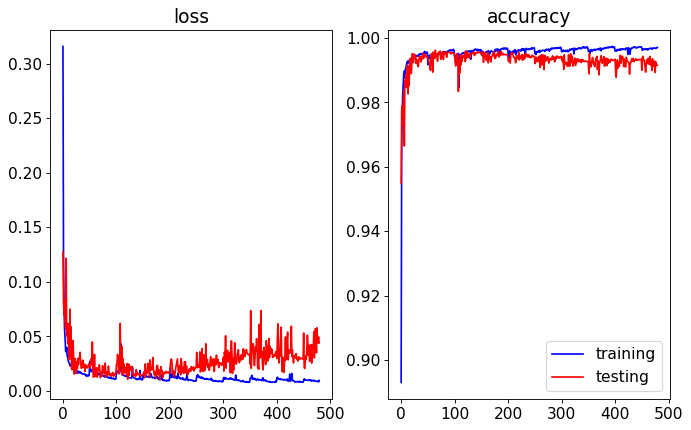

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


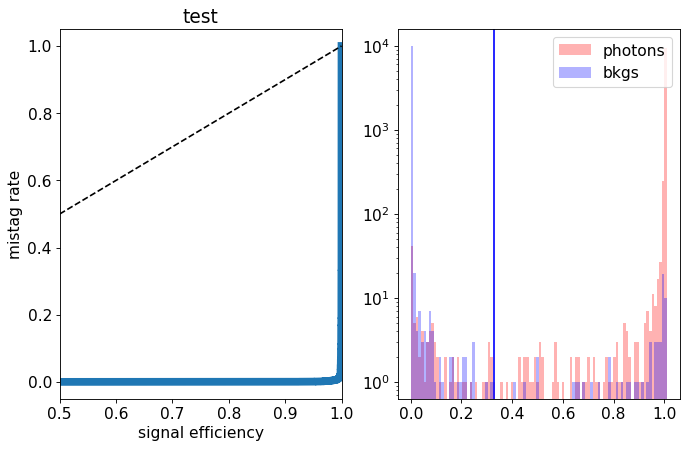

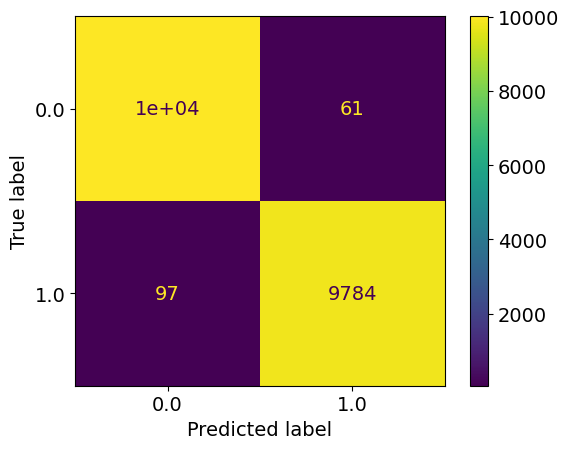

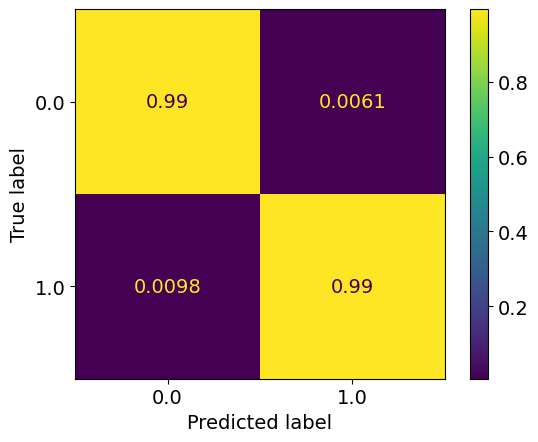

epoch: 480
Learning rate: 0.0003457144923392358


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.010039974075269454
train acc: 0.99651664


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.04632051333593314
test acc: 0.9912795
epoch: 481
Learning rate: 0.000316155727389609


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.008133329188280893
train acc: 0.99715567


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.40it/s]


test loss: 0.04582902533002198
test acc: 0.99213153
epoch: 482
Learning rate: 0.00028732251179351654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.42it/s]


train loss: 0.010758901132208142
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.39it/s]


test loss: 0.04384299691574758
test acc: 0.9924823
epoch: 483
Learning rate: 0.0002593286370802732


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.0123786644227351
train acc: 0.99572724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.19it/s]


test loss: 0.032755022101542526
test acc: 0.9926327
epoch: 484
Learning rate: 0.000232284582284187


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.009613627064000093
train acc: 0.9967923


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.25it/s]


test loss: 0.03214954330264043
test acc: 0.9924823
epoch: 485
Learning rate: 0.00020629707793428477


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.65it/s]


train loss: 0.009467347939525058
train acc: 0.9966043


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.03272488744422684
test acc: 0.99258256
epoch: 486
Learning rate: 0.00018146868483767426


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008634624573881125
train acc: 0.9970429


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.67it/s]


test loss: 0.030355802535161597
test acc: 0.99343455
epoch: 487
Learning rate: 0.00015789738931889407


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.29it/s]


train loss: 0.008399287274200947
train acc: 0.997068


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]


test loss: 0.04077859632396961
test acc: 0.99228185
epoch: 488
Learning rate: 0.00013567621651265594


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.008294068997147677
train acc: 0.9970554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.64it/s]


test loss: 0.034856756703982895
test acc: 0.9935348
epoch: 489
Learning rate: 0.00011489286323613807


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.008156581490766257
train acc: 0.9972183


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.64it/s]


test loss: 0.04059659816523302
test acc: 0.9926327


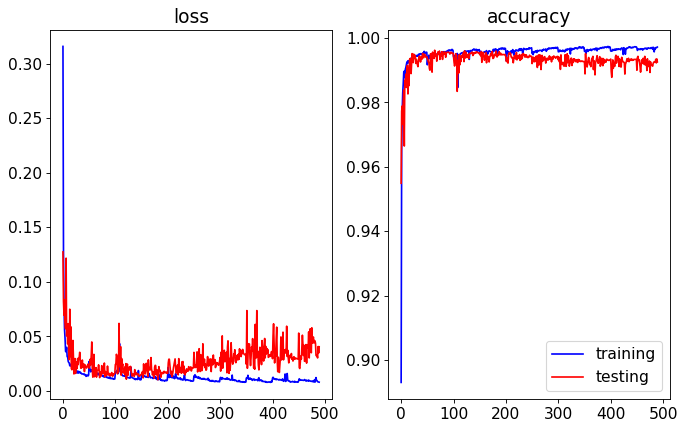

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.65it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


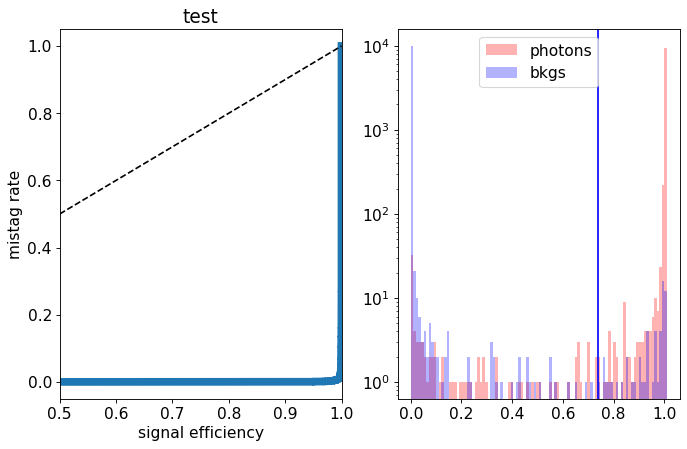

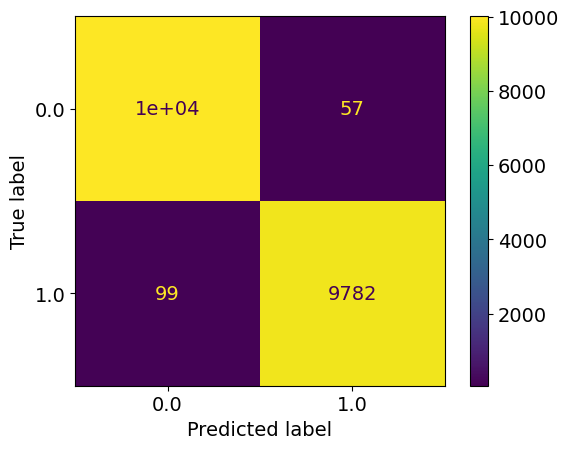

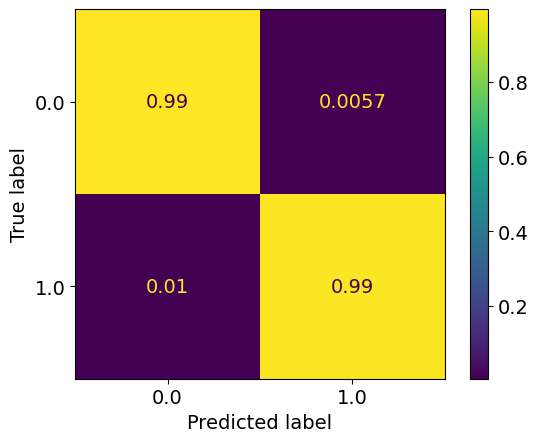

epoch: 490
Learning rate: 9.562935188971195e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.55it/s]


train loss: 0.008154779384000646
train acc: 0.9970053


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.62it/s]


test loss: 0.04194826545084224
test acc: 0.9920313
epoch: 491
Learning rate: 7.796170675200065e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:25<00:00,  5.31it/s]


train loss: 0.008202123777365743
train acc: 0.9972308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.48it/s]


test loss: 0.03911482111331733
test acc: 0.9926327
epoch: 492
Learning rate: 6.195965394678355e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.64it/s]


train loss: 0.007733613996579287
train acc: 0.9972434


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.03962074421061141
test acc: 0.9926828
epoch: 493
Learning rate: 4.7686346265840285e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.41it/s]


train loss: 0.008136646515355951
train acc: 0.9971933


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.04469983263697941
test acc: 0.9922317
epoch: 494
Learning rate: 3.519811393373346e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00797890768944514
train acc: 0.997519


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.45it/s]


test loss: 0.042512937668053544
test acc: 0.992332
epoch: 495
Learning rate: 2.454424229814728e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:24<00:00,  5.39it/s]


train loss: 0.007981409743139798
train acc: 0.99726844


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.43it/s]


test loss: 0.043685954611967594
test acc: 0.9926327
epoch: 496
Learning rate: 1.5766777323136415e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


train loss: 0.00789813659372809
train acc: 0.9973436


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.41it/s]


test loss: 0.04068848822156296
test acc: 0.99273294
epoch: 497
Learning rate: 8.90035965291497e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.61it/s]


train loss: 0.008433257565840579
train acc: 0.997093


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.14it/s]


test loss: 0.04206045677967589
test acc: 0.9926828
epoch: 498
Learning rate: 3.972087901059462e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008000418237139428
train acc: 0.99711806


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.42it/s]


test loss: 0.04154863094513798
test acc: 0.9926327
epoch: 499
Learning rate: 1.0014117046612258e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.59it/s]


train loss: 0.008196587809749615
train acc: 0.99714315


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.23it/s]


test loss: 0.04163441824836328
test acc: 0.9926327


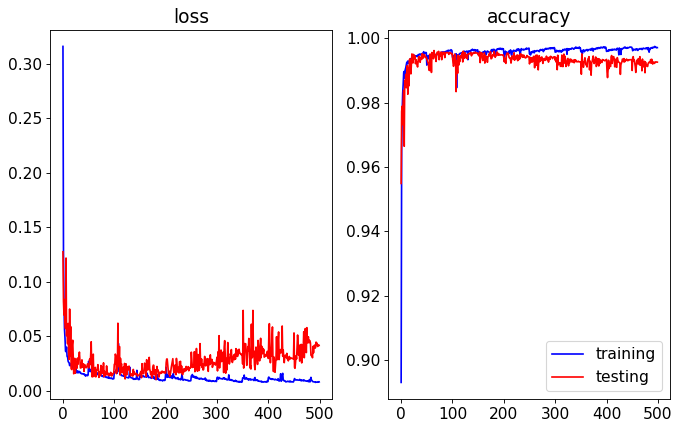

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.02it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


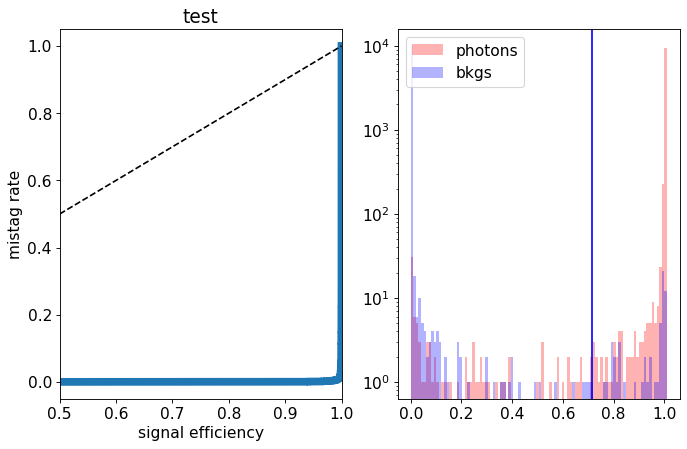

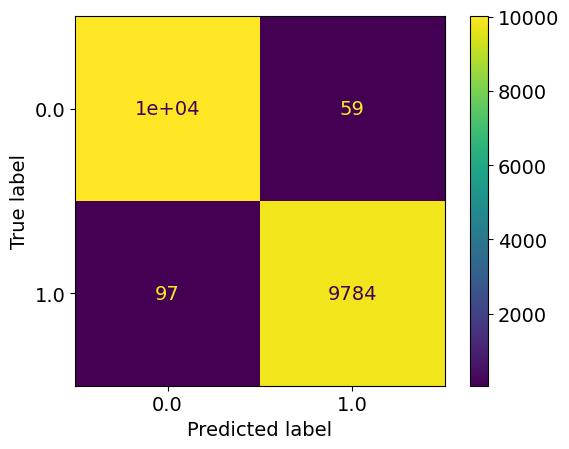

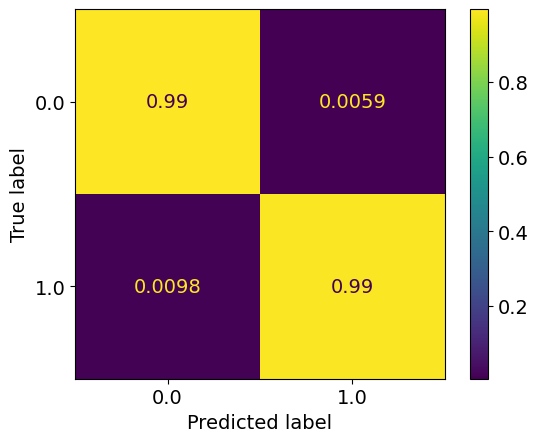

In [11]:
from tqdm import tqdm as tqdm

## OUTPUT directory
checkpoint_dir ="/grid_mnt/data__data.polcms/cms/cappati/250207_outdir_PID_train_30-70_noLowPho"
os.makedirs(checkpoint_dir, exist_ok=True)


nepoch=500
best_loss = 99999999
best_acc = 0.
losst = []
lossv = []
acct = []
accv = []
epochs = []
for epoch in range(nepoch):
    print ('epoch:',epoch)
    print("Learning rate:", optimizer.param_groups[0]['lr'])
    loss_t, acc_t = train(epoch)
    losst.append(loss_t)
    acct.append(acc_t)
    loss_v, acc_v = test(epoch)
    loss_epoch = loss_v
    lossv.append(loss_epoch)
    accv.append(acc_v)
    epochs.append(epoch)

    
     
    
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    
#     if loss_epoch < best_loss:
#         best_loss = loss_epoch
#         print('new best test loss:',best_loss)
#         torch.save(checkpoint,
#                    os.path.join(checkpoint_dir,'model_checkpoint_best.pth.tar' ))
    
    
    if acc_v > best_acc:
        print('new best acc:',acc_v)
        best_acc = acc_v
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_bestacc.pth.tar' ))
    
    if ((epoch+1)%10 == 0):
        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        
        ax0.plot(np.array(epochs),np.array(losst),c='b',label='training')
        ax0.plot(np.array(epochs),np.array(lossv),c='r',label='testing')
        ax0.title.set_text("loss")
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        #plt.legend()
        #plt.show()
        ax1.plot(np.array(epochs),np.array(acct),c='b',label='training')
        ax1.plot(np.array(epochs),np.array(accv),c='r',label='testing')
        ax1.title.set_text("accuracy")
        plt.legend()
        #if ((epoch+1) == nepoch):
        #    plt.savefig('%s/TrainvsValLoss_ep%d.png'%(plot_dir, epoch), bbox_inches='tight')
        plt.show()
        
        
        model.eval()
        scores = []
        trues = []
        true_preds, num_preds = 0., 0.
        for data in tqdm(testloader): ### change to loaderDNN for DNN
                datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
                optimizer.zero_grad()
                #label = label.to(torch.long).squeeze()
                result = model(datax, masks, info3d)
                scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
                trues.append(label.detach().cpu().numpy().flatten())
        
        
        truesa = np.hstack(trues)
        scoresa = np.hstack(scores)
        fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
        aucv = metrics.auc(fpr, tpr)

        tpr90,fpr90,threshold90 = 0,0,0
        for i,j,k in zip(tpr,fpr,thresholds):
            if i >0.99:
                tpr90 = i
                fpr90 = j
                threshold90 = k
                break

        fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10, 6),dpi=80)
        plt.rcParams['font.size'] = '14'
        ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
        ax0.set_xlabel("signal efficiency")
        ax0.set_ylabel("mistag rate")
        ax0.set_xlim([0.5,1])
        ax0.plot([0.,1], [0.,1], 'k--')
        ax0.title.set_text("test")
        plt.legend()
        #ax.text(0.6,0.6,aucv,)
        #plt.yscale("log")
        
        ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
        ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
        ax1.axvline(threshold90,c="b")
        plt.yscale("log")
        plt.legend()
        plt.show()

        
        
        
        
        
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
        plt.show()
        ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
        plt.show()
        

In [33]:
#print(epoch_size)

## Inference with model of last epoch

### Confusion matrix and Accuracy on test dataset

In [12]:
device = torch.device('cuda:1')
model.to(device)
model.eval()
scores = []
trues = []
true_preds, num_preds = 0., 0.
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        optimizer.zero_grad()
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        scores.append(torch.exp(result)[:,1].detach().cpu().flatten().numpy())
        trues.append(label.detach().cpu().numpy().flatten())
        #break

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.90it/s]


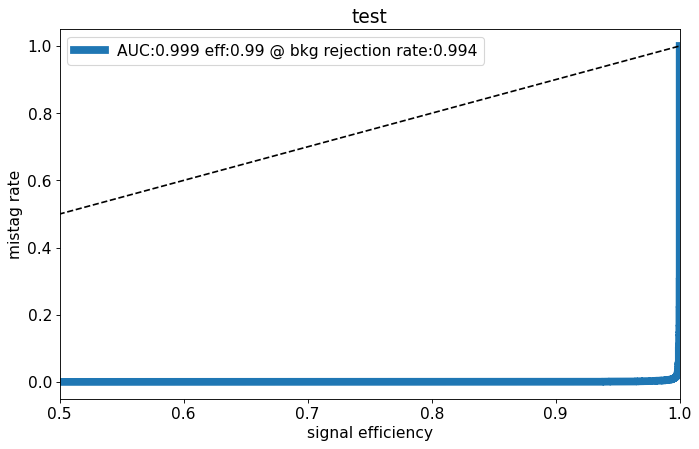

In [13]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.hstack(trues), np.hstack(scores), pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.99:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break

fig, ax = plt.subplots(figsize=(10, 6),dpi=80)
plt.rcParams['font.size'] = '14'
ax.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax.set_xlabel("signal efficiency")
ax.set_ylabel("mistag rate")
ax.set_xlim([0.5,1])
ax.plot([0.,1], [0.,1], 'k--')
ax.title.set_text("test")
#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
plt.legend()
plt.show()

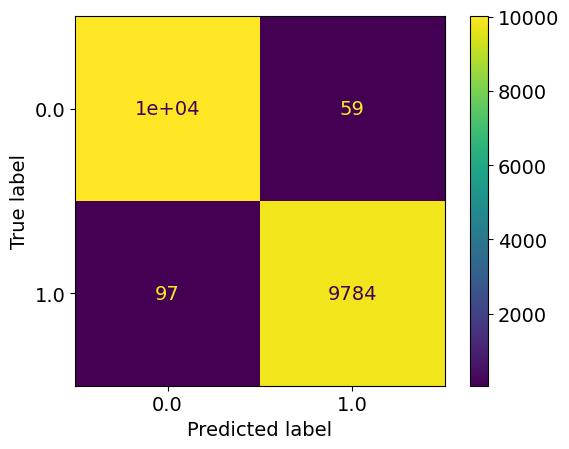

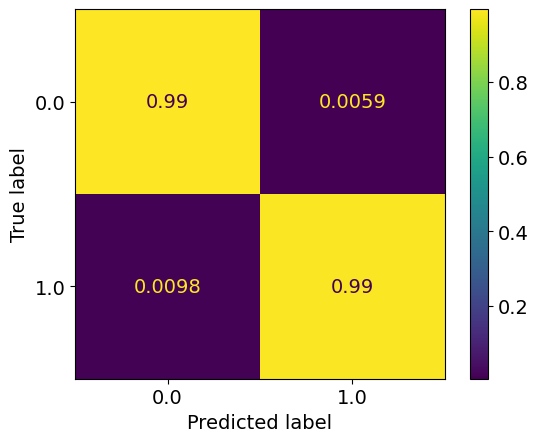

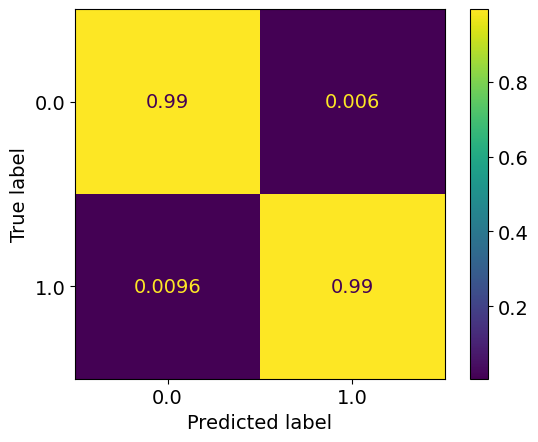

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#confusion_matrix(np.hstack(trues), np.where(np.hstack(scores)>0.5, 1, 0))

ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="true")
plt.show()
ConfusionMatrixDisplay.from_predictions(np.hstack(trues), np.where(np.hstack(scores)>threshold90, 1, 0), normalize="pred")
plt.show()

## Inference with model of best accuracy checkpoint

### Load best accuracy checkpoint and define model

In [15]:
### REMEMBER: specify the correct input model

device = torch.device('cuda:1')#('cuda' if torch.cuda.is_available() else 'cpu')
model_load = torch.load("/grid_mnt/data__data.polcms/cms/cappati/250207_outdir_PID_train_30-70_noLowPho/model_checkpoint_bestacc.pth.tar")


model = MHA_model(n_seq=150,
        input_dim = 4,
        dim_emb = 16,#32
        n_heads = 16,
        num_enclayers = 6,#4
        dim_feedforward = 64,
        output_dim = 2)


model.to(device)
model.load_state_dict(model_load["state_dict"])
model.eval()

/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/jit/_recursive.py:266: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


MHA_model(
  (emb_inp): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Dropout)
    (2): RecursiveScriptModule(original_name=ELU)
    (3): RecursiveScriptModule(original_name=Linear)
    (4): RecursiveScriptModule(original_name=Dropout)
    (5): RecursiveScriptModule(original_name=ELU)
  )
  (transformer_encoder): RecursiveScriptModule(
    original_name=TransformerEncoder
    (layers): RecursiveScriptModule(
      original_name=ModuleList
      (0): RecursiveScriptModule(
        original_name=TransformerEncoderLayer
        (self_attn): RecursiveScriptModule(
          original_name=MultiheadAttention
          (out_proj): RecursiveScriptModule(original_name=NonDynamicallyQuantizableLinear)
        )
        (linear1): RecursiveScriptModule(original_name=Linear)
        (dropout): RecursiveScriptModule(original_name=Dropout)
        (linear2): RecursiveScriptModule(original_name=Lin

### Confusion matrix and accuracy on test dataset (testloader)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 14.36it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.99624115
threshold : 0.62568307


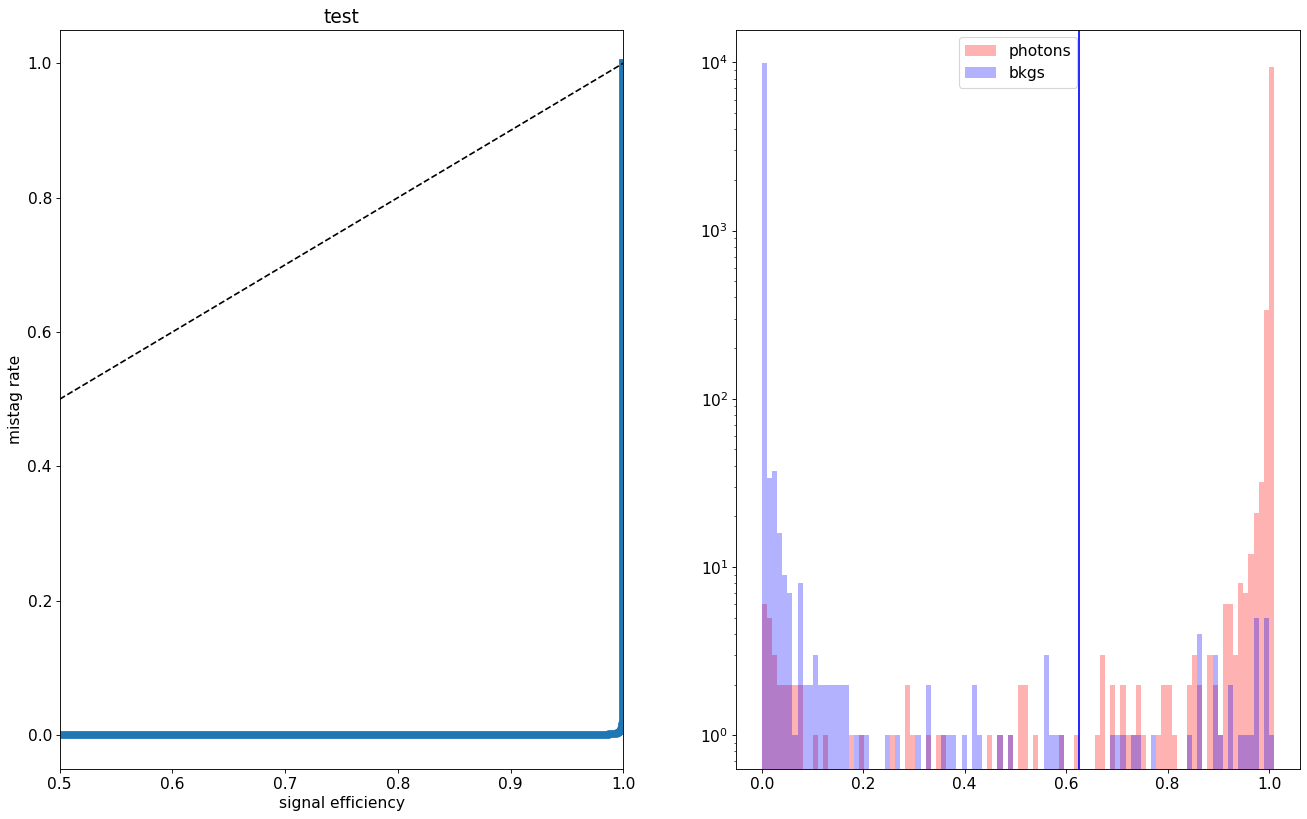

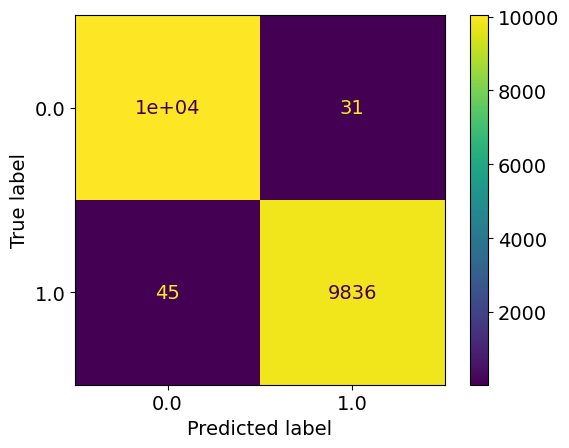

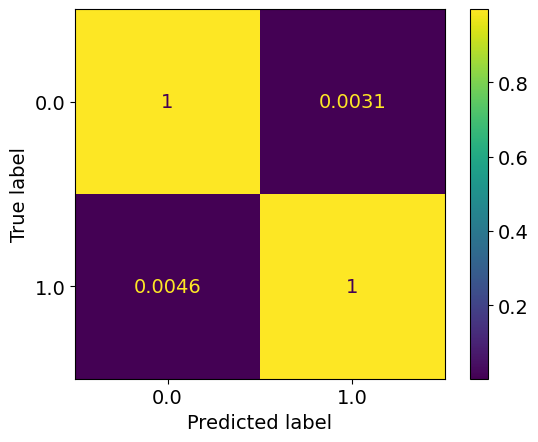

In [16]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

#        opt = np.where(np.hstack(op)>threshold90, 1, 0)
#        if (ip == 1)&(opt == 0):
#            mispredpho.append(datax.detach().cpu().numpy())
#        elif (ip == 0)&(opt == 1):
#            mispredbkg.append(datax.detach().cpu().numpy())

        
        
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break
print("threshold :",threshold90)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90, 1, 0), normalize="true")
plt.show()

### Confusion matrix and accuracy on full dataset (totalloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:11<00:00, 14.48it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


accuracy: 0.9963412
threshold : 0.7506036


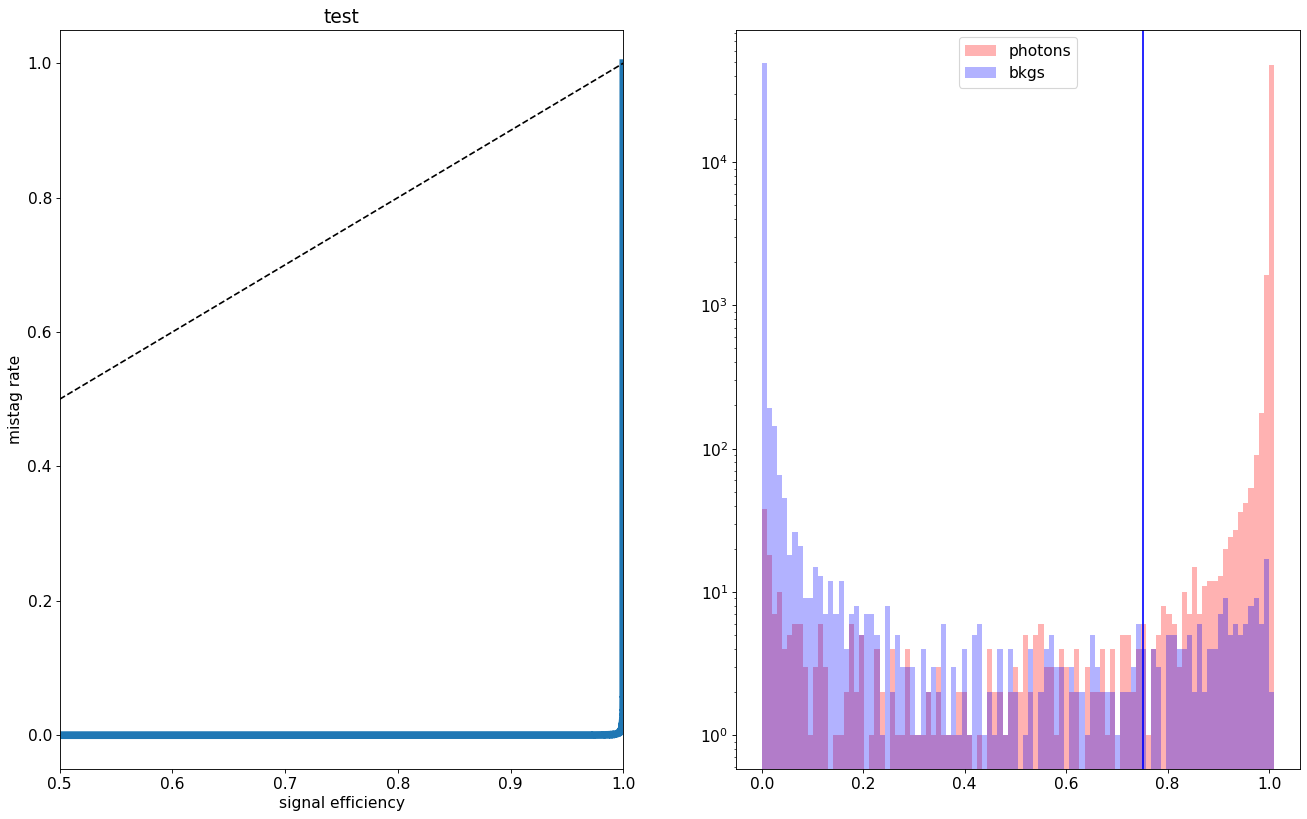

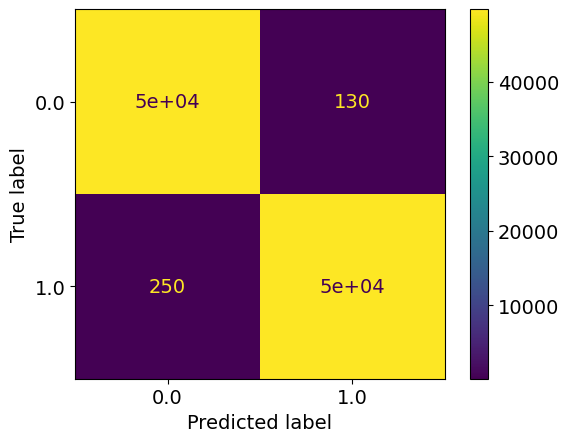

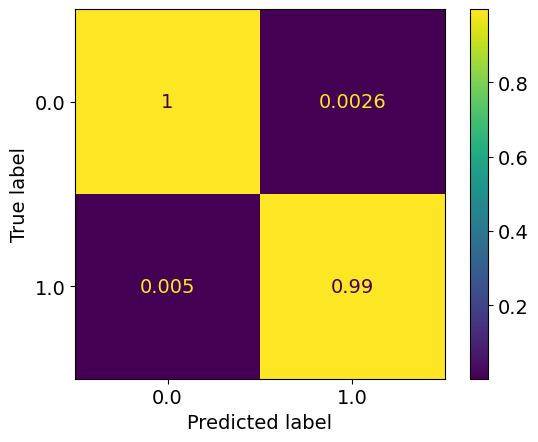

In [17]:
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = 0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )
     
        ######## use the following lines if you want just the overall scores for accuracy etc (Use this when you want to extract threshold and plot confusion matrices)
        
        label = label.to(torch.long).squeeze()
        pred_labels = torch.argmax(result.cpu(), dim=-1) 
        true_preds += (pred_labels == label.cpu()).sum()
        num_preds += label.shape[0]
        
acc = true_preds / num_preds
print("accuracy:",np.mean(np.array(acc)))

########################### this part extracts the threshold value and plots overall confusion matrices

truesa = np.hstack(trues)
scoresa = np.hstack(scores)
fpr, tpr, thresholds = metrics.roc_curve(truesa, scoresa, pos_label=1)
aucv = metrics.auc(fpr, tpr)

tpr90,fpr90,threshold90 = 0,0,0
for i,j,k in zip(tpr,fpr,thresholds):
    if i >0.995:
        tpr90 = i
        fpr90 = j
        threshold90 = k
        break
print("threshold :",threshold90)
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(20, 12),dpi=80)
plt.rcParams['font.size'] = '14'
### plot AUC
ax0.plot(tpr,fpr, linewidth=7.0, label= "AUC:"+str(round(aucv,3))+" eff:"+str(round(tpr90,3))+" @ bkg rejection rate:"+str(round(1-fpr90,3)))
ax0.set_xlabel("signal efficiency")
ax0.set_ylabel("mistag rate")
ax0.set_xlim([0.5,1])
ax0.plot([0.,1], [0.,1], 'k--')
ax0.title.set_text("test")
plt.legend()
#plt.show()

## plot signal-bkg distribution
ax1.hist(scoresa[truesa == 1],bins=100, range=[0,1.01], label='photons',linewidth=2.0, color="r" , alpha=0.3)
ax1.hist(scoresa[truesa == 0],bins=100, range=[0,1.01], label='bkgs',linewidth=2.0, color="b", alpha=0.3 )
ax1.axvline(threshold90,c="b")
plt.yscale("log")
plt.legend()
plt.show()

#ax.text(0.6,0.6,aucv,)
#plt.yscale("log")
#plt.legend()
#plt.show()



### plot confusion matrices
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90, 1, 0))
plt.show()
ConfusionMatrixDisplay.from_predictions(truesa, np.where(scoresa>threshold90, 1, 0), normalize="true")
plt.show()

### Plot mispredicted events

In [19]:
### set batch_size=1
testloader = torch.utils.data.DataLoader(tsdata, batch_size=1,shuffle=True)#, num_workers=2)
totalloader = torch.utils.data.DataLoader(combdataset, batch_size=1,shuffle=True)#, num_workers=2)

#### mispredicted events on test dataset (testloader)

  0%|                                                                                                                                                                                     | 0/19953 [00:00<?, ?it/s]/opt/exp_soft/vo.gridcl.fr/software/torch/2.0.1/py311-cuda117/lib/python3.11/site-packages/torch/nn/modules/module.py:1501: UserWarning: FALLBACK path has been taken inside: runCudaFusionGroup. This is an indication that codegen Failed for some reason.
To debug try disable codegen fallback path via setting the env variable `export PYTORCH_NVFUSER_DISABLE=fallback`
 (Triggered internally at ../third_party/nvfuser/csrc/manager.cpp:335.)
  return forward_call(*args, **kwargs)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19953/19953 [01:24<00:00, 237.27it/s]


threshold 0.62568307
mispred_pho 44


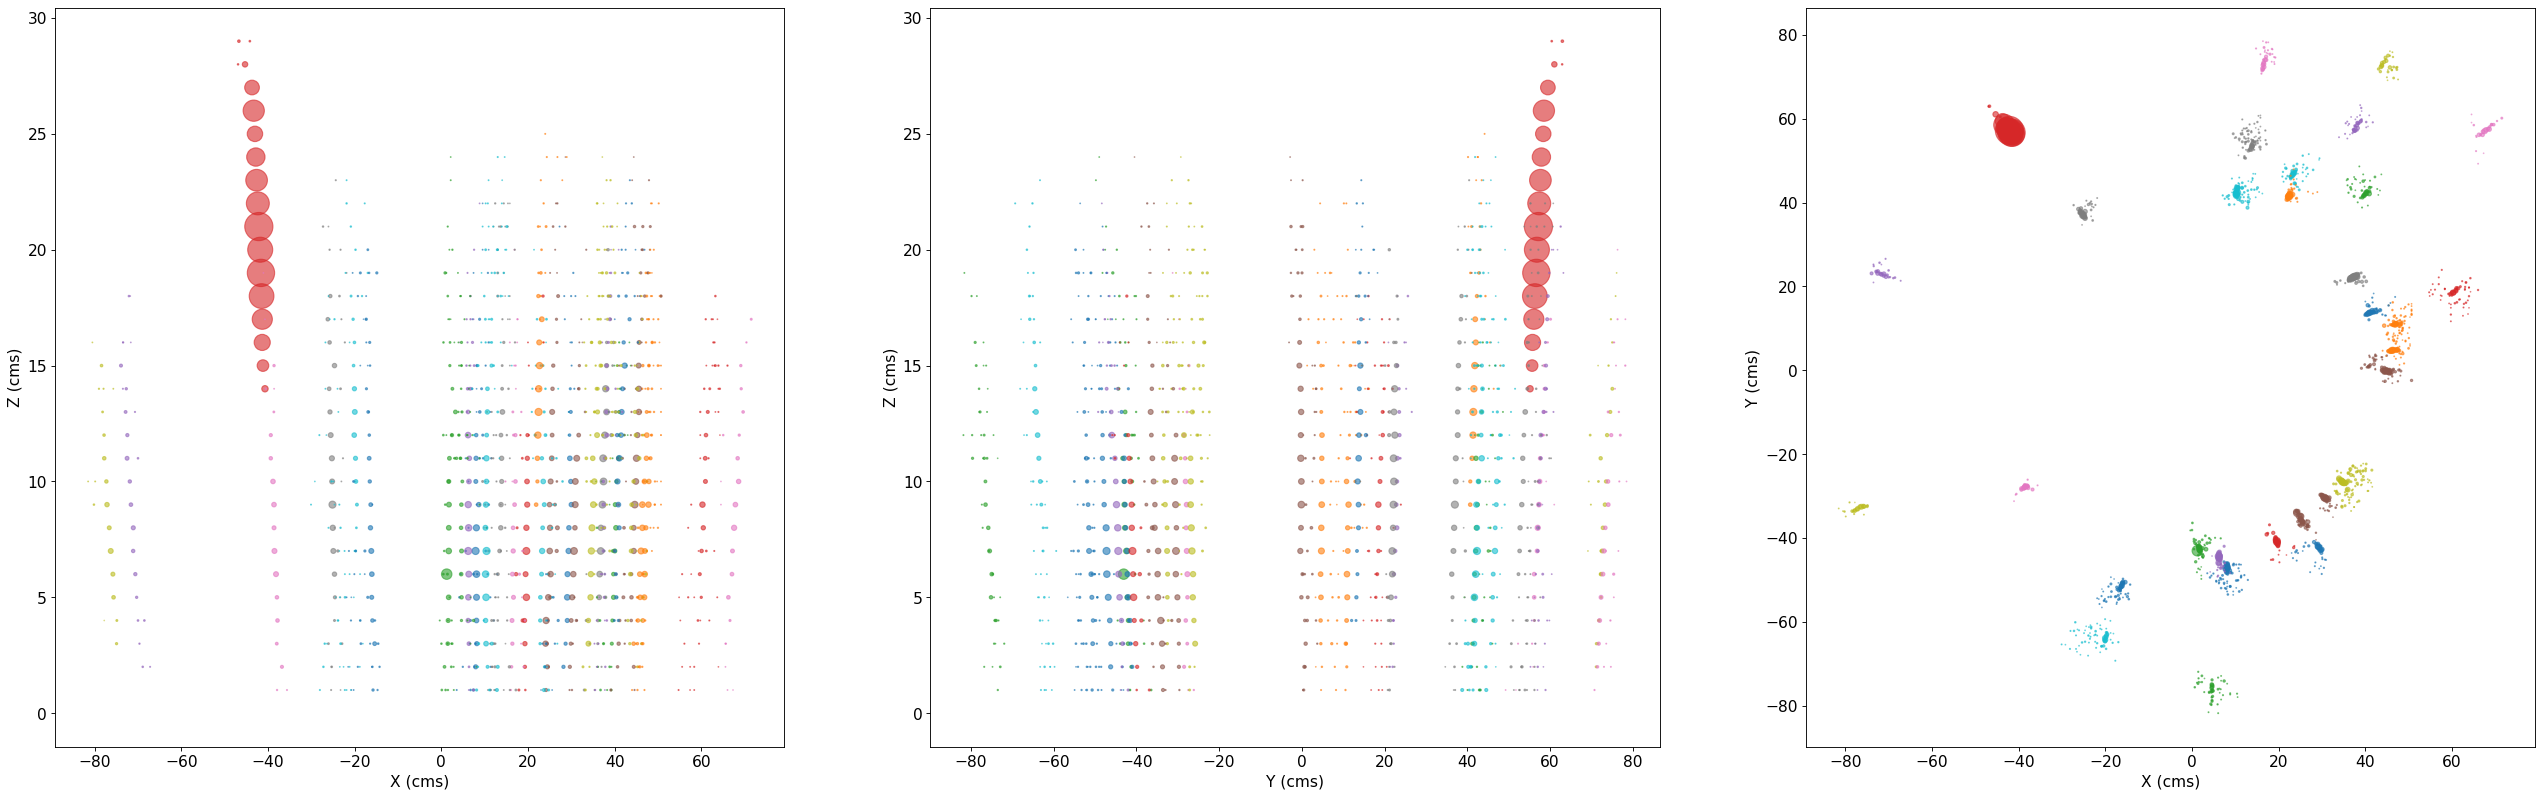

mispred_bkg 31


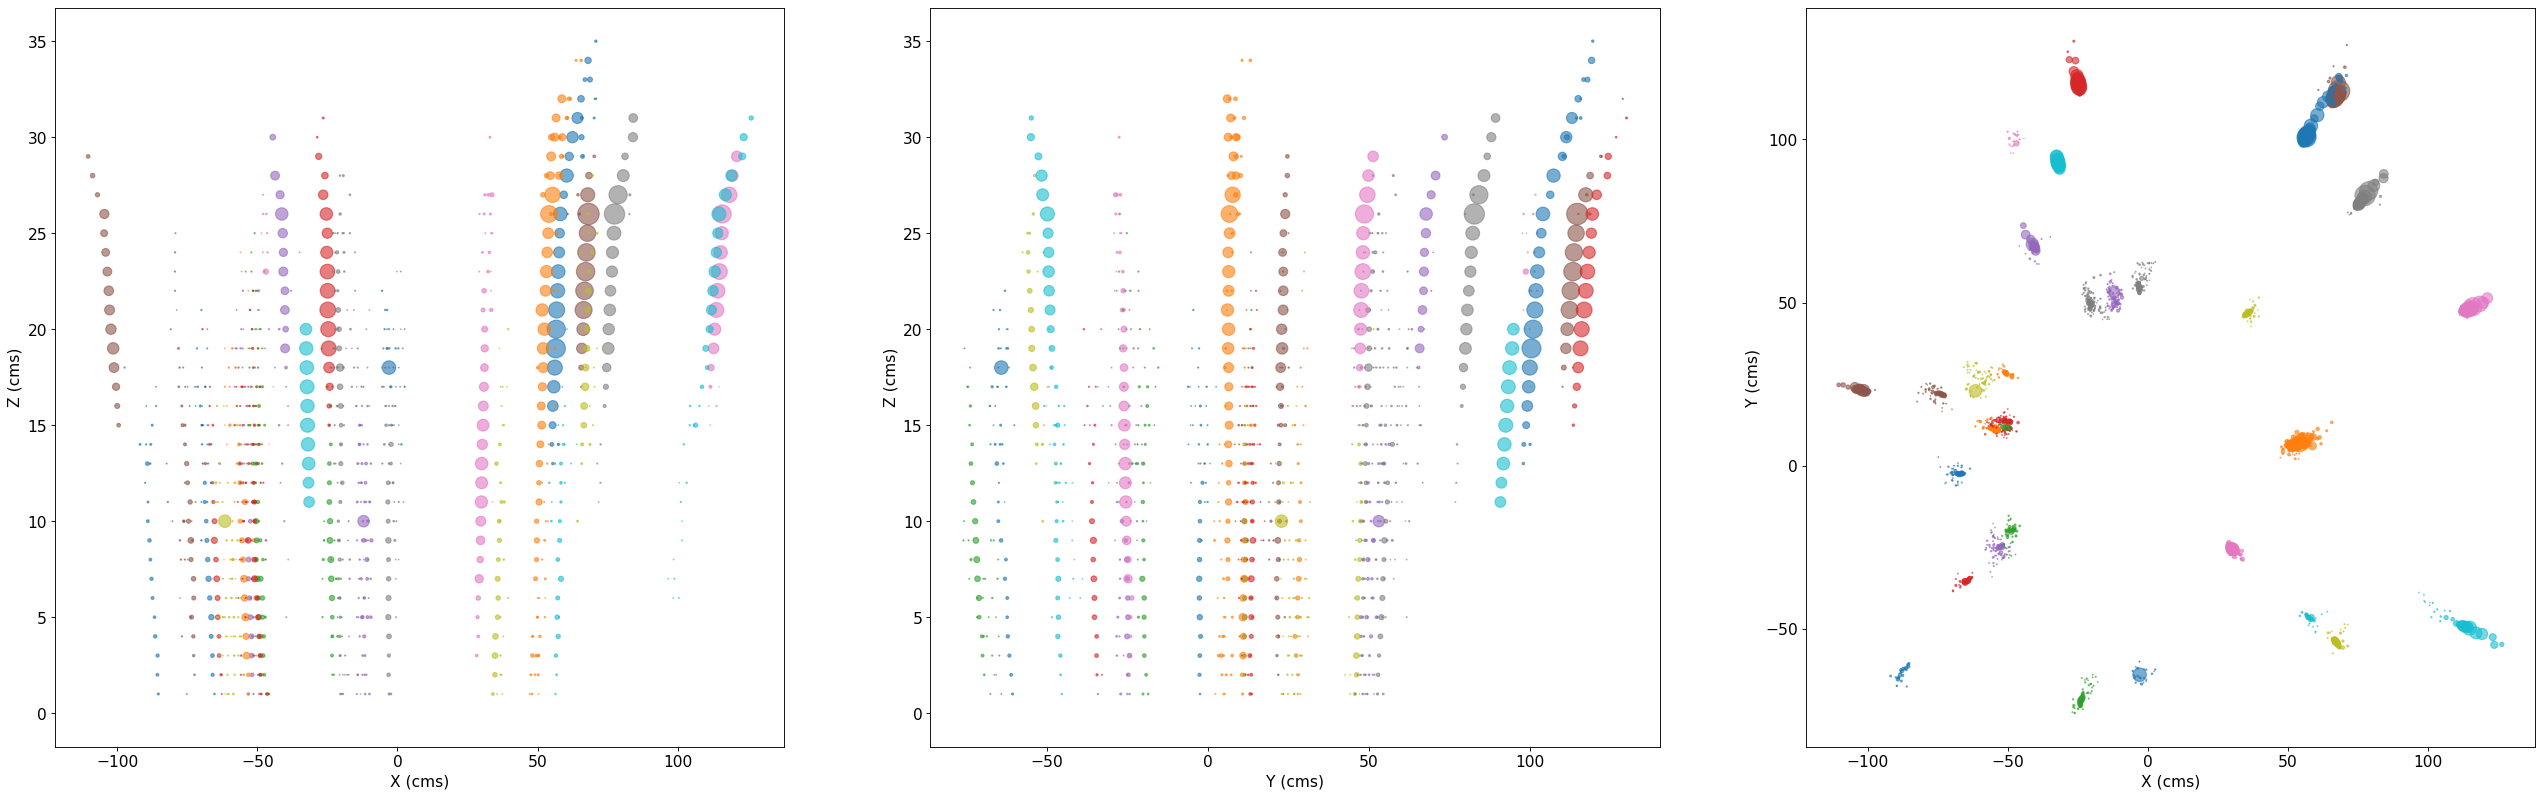

In [20]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = 0.62568307 #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(testloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

#### mispredicted events on full dataset (totalloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99761/99761 [06:59<00:00, 237.68it/s]


threshold 0.7506036
mispred_pho 249


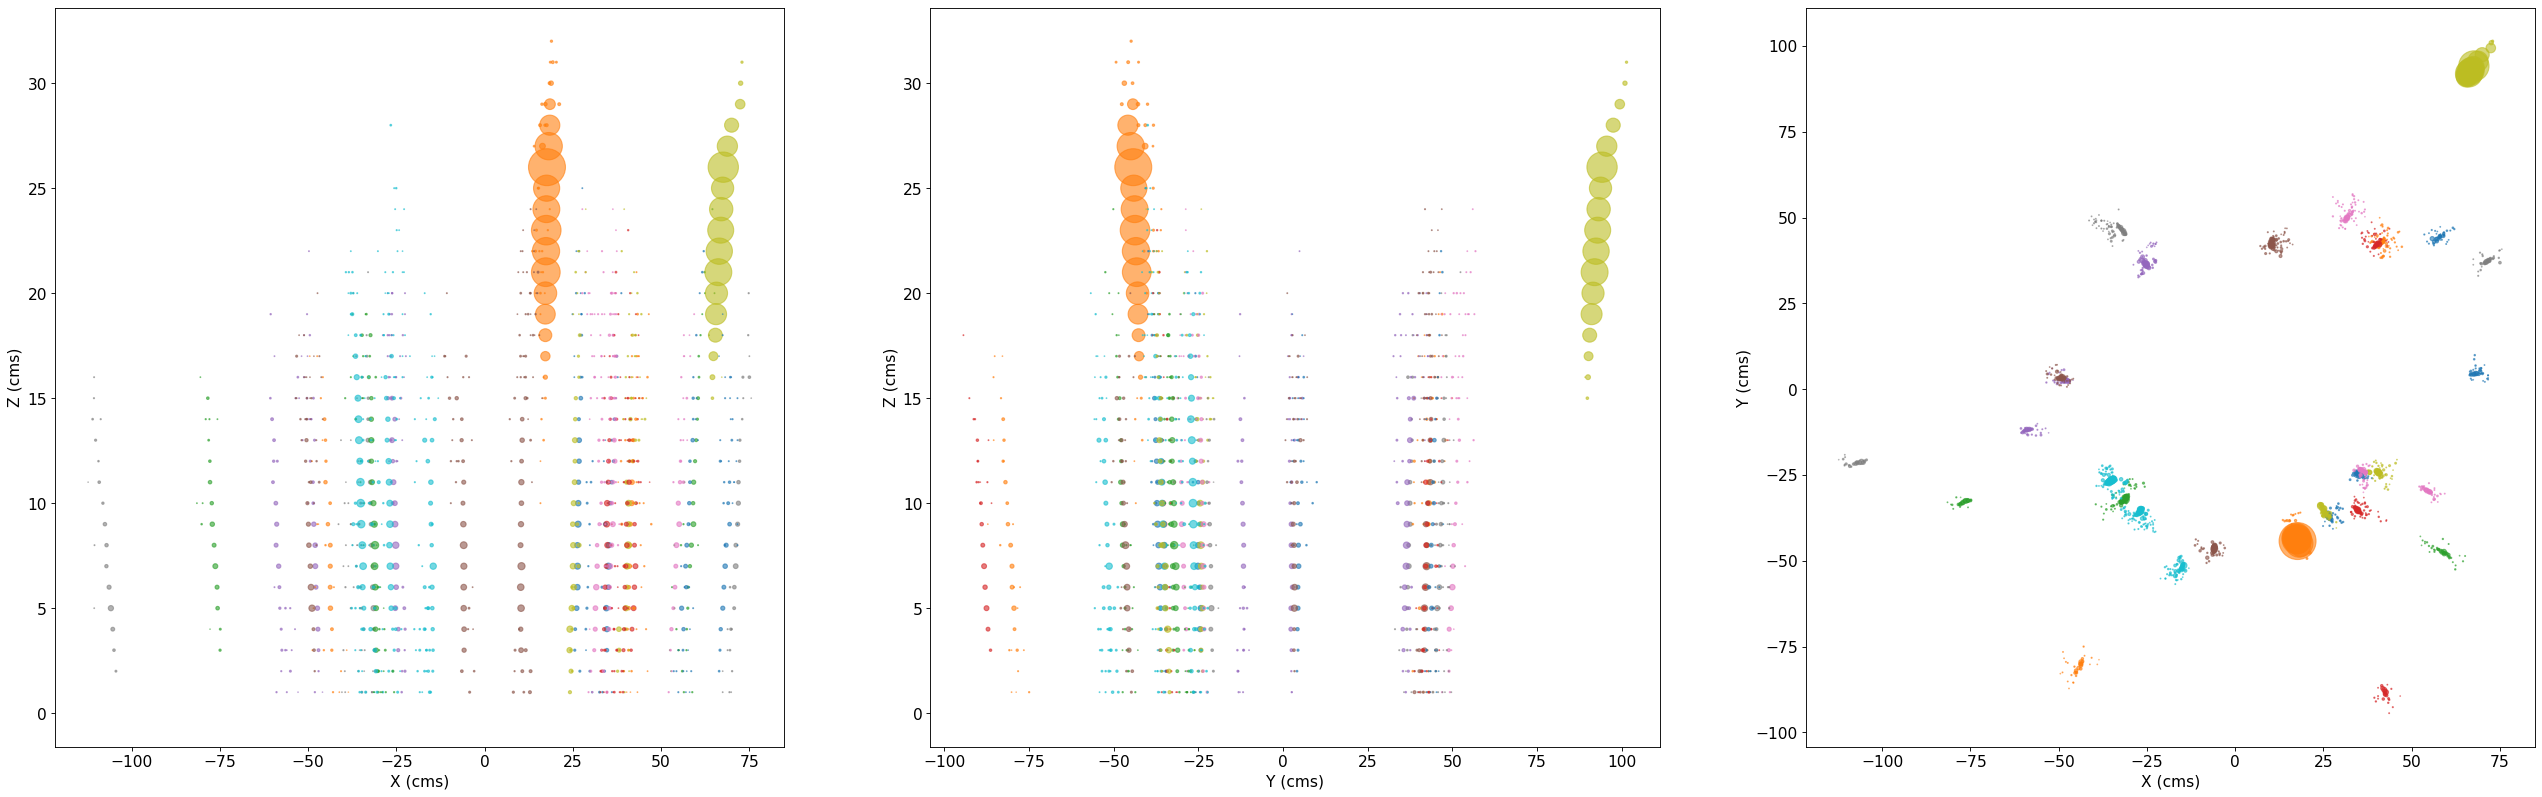

mispred_bkg 130


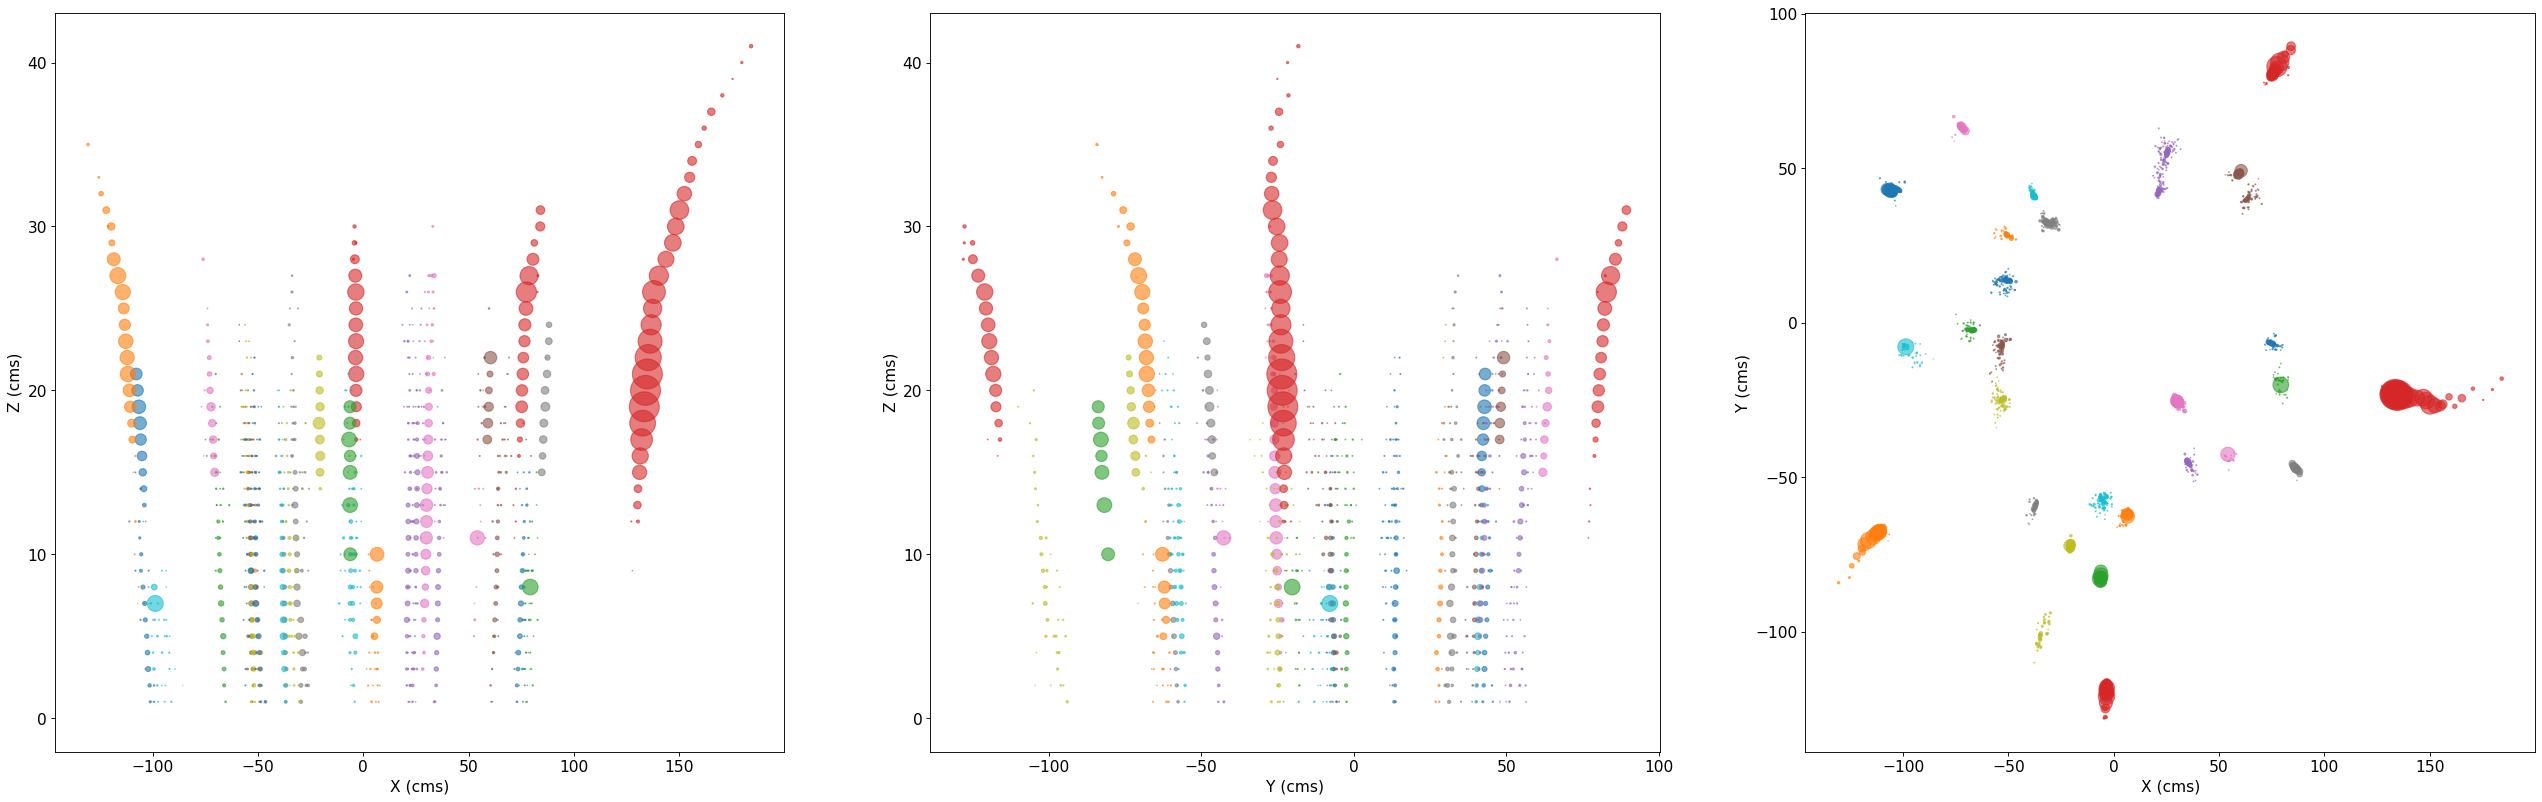

In [21]:
## REMEMBER to specify the threshold (to match the one obtained above)
scores = []
trues = []
true_preds, num_preds = 0., 0.
threshold90 = 0.7506036 #0.152
mispredpho = []
mispredbkg = []
for data in tqdm(totalloader): ### change to loaderDNN for DNN
        datax, label, masks, info3d = data[0].to(device), data[1].to(device), data[2].to(device), data[3].to(device)
        #label = label.to(torch.long).squeeze()
        result = model(datax, masks, info3d)
        op = torch.exp(result)[:,1].detach().cpu().flatten().numpy()
        ip = label.detach().cpu().numpy().flatten()
        scores.append(op)
        trues.append( ip )

######## use the following lines if you want to store mispredicted event indices for plotting  (REMEMBER to set batch_size=1)

        opt = np.where(np.hstack(op)>threshold90, 1, 0)
        if (ip == 1)&(opt == 0):
            mispredpho.append(datax.detach().cpu().numpy())
        elif (ip == 0)&(opt == 1):
            mispredbkg.append(datax.detach().cpu().numpy())



#Plot mispredicted events:
print("threshold", threshold90)

## mispredicted PHOTONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_pho",len(mispredpho))
cc = 0
for uarray in mispredpho:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()

## mispredicted PIONS
fig, (ax0,ax1, ax2) = plt.subplots(1,3,figsize=(40, 12),dpi=80)
print("mispred_bkg",len(mispredbkg))
cc = 0
for uarray in mispredbkg:
    
    uarray = uarray.reshape(uarray.shape[1],uarray.shape[2])
    #uarray = uarray[uarray[:,2]>0]
    ax0.scatter(uarray[:,0],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax0.set_xlabel('X (cms)')
    ax0.set_ylabel('Z (cms)')
    ax1.scatter(uarray[:,1],uarray[:,2],s=uarray[:,3]*10,alpha=0.6)
    ax1.set_xlabel('Y (cms)')
    ax1.set_ylabel('Z (cms)')

    ax2.scatter(uarray[:,0],uarray[:,1],s=uarray[:,3]*10,alpha=0.6)
    ax2.set_xlabel('X (cms)')
    ax2.set_ylabel('Y (cms)')
    cc += 1
    if cc > 30:
        break    

plt.show()